# TODO

In [1]:
# Add union of cumulative dh and dV panels of plot_evolving_and_stationary_comparison and plot_evolving_and_stationary_comparison_sequential functions

# (non-urgent) Re-run visualize_and_save_evolving_outlines on all lakes but byrd_1 to make evolving outlines geojson the latest format

Code to do data analysis of re-examined active subglacial lakes and create Fig. S1 in Sauthoff and others, 202X, _Journal_.

Written 2023-07-11 by W. Sauthoff (wsauthoff.github.io).

# Set up computing environment

This code runs continental-scale operations on multiple datasets and requires a ~32 GB server or local memory.

In [2]:
%pip install earthaccess --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install openpyxl --quiet

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install opencv-python --quiet

In [ ]:
%pip install pyogrio --quiet

In [ ]:
# Import libraries
from aiohttp import ClientResponseError
from collections import defaultdict
import cv2
import datetime
import earthaccess
import fiona
import gc
import geopandas as gpd
import glob
import holoviews as hv
hv.extension('bokeh')
import hvplot.pandas
from IPython.display import clear_output
import logging
import matplotlib
matplotlib.use('Agg')  # Set backend to Agg to avoid NavigationToolbar issue
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import os
from os import path
from pathlib import Path
import pandas as pd
import psutil
import pyogrio
from pyproj import CRS, Geod, Transformer
import re
import rioxarray
from rioxarray.exceptions import NoDataInBounds
from shapely.geometry import box, MultiPolygon, Point, Polygon
from shapely.ops import unary_union
from shapely.validation import make_valid
import shutil
from skimage import measure
import time
import traceback
from typing import Dict, List, Tuple
import warnings
import xarray as xr

# Magic functions
%matplotlib widget
# %matplotlib inline

# Define data directories dependent on home environment
# Replace with your directory file paths
if os.getenv('HOME') == '/home/jovyan':
    DATA_DIR = '/home/jovyan/data'
    OUTPUT_DIR = '/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods'
    OUTPUT_DIR_GIT = '/home/jovyan/1_evolving_lakes/Sauthoff-202X-evolving-lakes/output'

# Define constants and coordinate transforms for the geodesic area calculation
CRS_LL = "EPSG:4326" # wgs84 in lon,lat
GEOD = CRS(CRS_LL).get_geod() # geod object for calculating geodesic area on defined ellipsoid
CRS_XY = "EPSG:3031" # Antarctic Polar Stereographic in x, y
XY_TO_LL = Transformer.from_crs(CRS_XY, CRS_LL, always_xy = True) # make coord transformer
geod = Geod(ellps="WGS84") # Create a Geod object for calculating area on the WGS84 ellipsoid

# Change default font to increase font size
plt.rcParams.update({'font.size': 8})

# Define functions

In [ ]:
def date_to_quarter_year(date):
    """Convert datetime64 to year.quarter."""
    if isinstance(date, np.datetime64):
        date = pd.Timestamp(date)
    
    return date.year + (date.quarter - 1) * 0.25

In [ ]:
def area_multiple_buffer(ref_polygon, area_multiple, precision=100, exclude_inner=False):
    '''
    This function takes a polygon and returns a polygon with a buffer such that the area of the buffered polygon
    is approximately the specified multiple of the original polygon area. Optionally excludes the inner polygon
    to create a ring-like shape.
    
    Inputs:
    * param polygon: Shapely Polygon object
    * param area_multiple: the multiple of the original polygon area you wish the buffered polygon to be
    * param precision: Precision for the iterative process to find the buffer distance
    * param exclude_inner: If True, returns the difference between the buffered area and original polygon
    * return: Buffered Polygon or Ring-like Polygon (if exclude_inner=True)
    '''
    # Ensure we're working with a single geometry, not a Series
    if hasattr(ref_polygon, 'iloc'):
        ref_polygon = ref_polygon.iloc[0]
        
    original_area = ref_polygon.area
    target_area = area_multiple * original_area
    buffer_distance = 0
    area_multiple_polygon = ref_polygon
    
    while area_multiple_polygon.area < target_area:
        buffer_distance += precision
        area_multiple_polygon = ref_polygon.buffer(buffer_distance)
    
    if exclude_inner:
        # Return the difference between the buffered polygon and the original polygon
        return area_multiple_polygon.difference(ref_polygon)
    else:
        return area_multiple_polygon

In [ ]:
def filter_gdf_by_folder_contents(gdf, folder_path, exclude=True, prefix=None, suffix=None, suffix_pattern=None, file_extension=None):
    '''
    Filter the GeoDataFrame based on processed lake names from the folder contents.
    
    Args:
    gdf: GeoDataFrame to be filtered.
    folder_path: Path to the directory containing files and/or subdirectories.
    exclude: If True, excludes gdf rows where the 'name' is in the folder_path directories or files.
             If False, includes only gdf rows where the 'name' is in the folder_path directories or files.
    prefix: Optional string to remove from the beginning of filenames.
    suffix: Optional string to remove from the end of filenames.
    suffix_pattern: Optional regex pattern to remove from the end of filenames.
    file_extension: Optional string specifying the file extension to filter (e.g., 'png', 'txt').
    
    Returns:
    GeoDataFrame filtered based on the presence of 'name' in folder_path.

    # Example usage:
    remaining_lakes = filter_gdf_by_folder_contents(
        stationary_outlines_gdf, 
        folder_path,
        # prefix='plot_evolving_outlines_time_series_', 
        suffix_pattern=r'\d+\.\d+m-level_\d+x-with',
        file_extension='txt'
    )
    '''
    # Return empty GeoDataFrame if input is empty
    if gdf is None or gdf.empty:
        return gdf

    def process_name(name):
        """Helper function to remove prefix and suffix from a name"""
        processed_name = name
        
        # First strip the file extension if it exists
        processed_name = os.path.splitext(processed_name)[0]
        
        # if prefix and processed_name.startswith(prefix):
        #     processed_name = processed_name[len(prefix):]
            
        if suffix_pattern:
            processed_name = re.sub(suffix_pattern + '$', '', processed_name)
        elif suffix and processed_name.endswith(suffix):
            processed_name = processed_name[:-len(suffix)]
            
        return processed_name.lower().strip()
    
    # Get all files and filter by extension if specified
    all_files = os.listdir(folder_path)
    if file_extension:
        clean_extension = file_extension.lstrip('.')
        all_files = [f for f in all_files if f.lower().endswith(f'.{clean_extension.lower()}')]
    
    # Process filenames to get lake names
    names_in_folder = {
        process_name(name)
        for name in all_files
    }
    
    # Filter without adding and then dropping a new column
    gdf_filtered = gdf[gdf['name'].str.lower().str.strip().apply(
        lambda x: (x not in names_in_folder) if exclude else (x in names_in_folder)
    )]
    
    return gdf_filtered.reset_index(drop=True)

## find_and_save_optimal_parameters

In [ ]:
def find_and_save_optimal_parameters(lake_gdf, within_area_multiples=range(2, 16)):
    '''
    Find and save optimal levels for each lake at various within evaluation boundaries.
    '''
    results = find_optimal_parameters(lake_gdf=lake_gdf, within_area_multiples=within_area_multiples)
    save_search_results(lake_gdf, results)
    clear_output(wait=True)

def find_optimal_parameters(lake_gdf, 
                          within_area_multiples=range(2, 16),
                          initial_level=0.01,
                          level_increment=0.01,
                          within_fraction_target=0.95):
    '''
    Find optimal search extent and level parameters for a lake.     
    '''
    # Initialize results DataFrame
    results_df = pd.DataFrame(
        columns=['within_area_multiple', 'level', 'within_percent', 'dataset_dois'])

    # Prepare datasets
    dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 30)
    
    try:
        for area_multiple in within_area_multiples:
            print('Finding optimal levels at within evaluation boundaries for', lake_gdf['name'].iloc[0])
            level = initial_level
            # found_for_current_multiple = False  # Track if we found result for this multiple
            # stop_incrementing = False
            
            # while level <= 2.0 and not found_for_current_multiple and not stop_incrementing:
            while level <= 2.0:
                outlines_gdf = find_evolving_outlines(
                    lake_gdf=lake_gdf,
                    within_area_multiple=area_multiple,
                    level=level,
                    dataset1_masked=dataset1_masked,
                    dataset2_masked=dataset2_masked, 
                    search_extent_poly=search_extent_poly,
                    plot=False
                )

                if outlines_gdf is not None and not outlines_gdf.empty:
                    within_fraction = calculate_within_fraction(
                        outlines_gdf, lake_gdf['geometry'], area_multiple)
                    print(f"within_area_multiple: {area_multiple}, level: {level}, within: {round(within_fraction*100)}%")

                    if within_fraction == 0.0:
                        print(f"Within fraction is 0.0, stopping search for area_multiple: {area_multiple}")
                        # stop_incrementing = True
                        break

                    if within_fraction >= within_fraction_target:
                        onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                            outlines_gdf, lake_gdf['geometry'].iloc[0]
                        )
                        
                        if not onlake_outlines.empty:
                            # Add result
                            dois = [doi for doi in [dataset1_doi, dataset2_doi] if doi is not None]
                            results_df.loc[len(results_df)] = {
                                'within_area_multiple': area_multiple,
                                'level': level,
                                'within_percent': within_fraction * 100,
                                'dataset_dois': ', '.join(dois)
                            }
                            found_for_current_multiple = True  # Mark that we found result for this area_multiple
                            break  # Found a good result for this area_multiple, move to next
                        else:
                            print("onlake_outlines is empty, continuing search")
                else:
                    print(f"within_area_multiple: {area_multiple}, level: {level}, within: no outlines found")
                    print(f"No outlines found, stopping search for area_multiple: {area_multiple}")
                    # stop_incrementing = True  # Stop if no outlines found
                    break

                # # Only increment level if we haven't found a result
                # if not found_for_current_multiple:
                #     level = round(level + level_increment, 2)
                level = round(level + level_increment, 2)

            # Clear output for each within_area_multiple
            clear_output(wait=True)
            
    except Exception as e:
        print(f"Error processing lake {lake_gdf['name']}: {str(e)}")
        return pd.DataFrame()
    finally:
        gc.collect()

    # Sort the DataFrame
    results_df = results_df.sort_values(
        by=['level', 'within_area_multiple'], 
        ascending=[True, True])

    results_df = remove_higher_duplicates(results_df)
        
    return results_df

def calculate_within_fraction(evolving_outlines_gdf, stationary_outline, area_multiple):
    """
    Calculate fraction of evolving outlines that fall within the search extent.
    
    Parameters:
    -----------
    evolving_outlines_gdf : GeoDataFrame
        The evolving outlines to analyze
    stationary_outline : Geometry
        The original lake outline
    area_multiple : int
        Area multiple for within evaluation boundary
        
    Returns:
    --------
    float
        Fraction of outlines that are within the search extent (0.0 to 1.0)
    """
    # Create search extent boundary
    within_evaluation_poly = area_multiple_buffer(
        ref_polygon=stationary_outline, 
        area_multiple=area_multiple)
    within_evaluation_gdf = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries([within_evaluation_poly]), 
        crs=3031)

    # Validate geometries
    valid_outlines = evolving_outlines_gdf.loc[
        evolving_outlines_gdf.is_valid & ~evolving_outlines_gdf.is_empty].copy()
    valid_within_evaluation_poly = within_evaluation_gdf.loc[
        within_evaluation_gdf.is_valid & ~within_evaluation_gdf.is_empty].copy()
    
    if valid_outlines.empty or valid_within_evaluation_poly.empty:
        return 0.0

    # Convert geometries to ensure they're polygons
    valid_outlines.loc[:, 'geometry'] = valid_outlines['geometry'].apply(
        lambda geom: geom if isinstance(geom, Polygon) else Polygon())
    valid_within_evaluation_poly.loc[:, 'geometry'] = valid_within_evaluation_poly['geometry'].apply(
        lambda geom: geom if isinstance(geom, Polygon) else Polygon())

    # Perform spatial analysis
    within = gpd.sjoin(valid_outlines, within_evaluation_gdf, predicate='within')
    overlaps = gpd.sjoin(valid_outlines, within_evaluation_gdf, predicate='overlaps')

    # Calculate fraction that are within
    total = len(within) + len(overlaps)
    if total > 0:
        return round(len(within) / total, 2)
    return 0.0

def remove_higher_duplicates(df):
    """
    Remove rows that have duplicate 'level' values at higher 'within_area_multiple' values.
    Assumes the dataframe is already sorted by 'level' and 'within_area_multiple'.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with 'level' and 'within_area_multiple' columns
    
    Returns:
    pandas.DataFrame: DataFrame with duplicates removed
    """
    # Keep track of levels we've seen
    seen_levels = set()
    # Create a boolean mask for rows to keep
    mask = []
    
    for _, row in df.iterrows():
        # If we haven't seen this level before, keep the row
        if row['level'] not in seen_levels:
            mask.append(True)
            seen_levels.add(row['level'])
        else:
            # If we have seen this level, don't keep the row
            mask.append(False)
    
    # Return filtered dataframe
    return df[mask]

def save_search_results(lake_gdf, results_df):
    '''
    Save search results to files. Creates appropriate files for lakes with no results.
    
    Parameters:
    -----------
    lake_gdf : GeoDataFrame row
        Single lake record containing name
    results_df : DataFrame  
        Results from find_optimal_parameters, may be empty
    '''
    os.makedirs(OUTPUT_DIR + '/levels', exist_ok=True)
    lake_name = lake_gdf['name'].iloc[0]
    
    if not results_df.empty:
        results_df.to_csv(
            OUTPUT_DIR + f'/levels/{lake_name}.csv',
            index=False
        )
        print(f"Saved optimal parameters for {lake_name}")
    else:
        print(f"No outlines found for {lake_name}")
        write_no_outlines(OUTPUT_DIR + f'/levels/{lake_name}.txt')
        write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{lake_name}.txt')

def write_no_outlines(filepath):
    """Write file indicating no outlines found"""
    try:
        # Ensure directory exists
        os.makedirs(os.path.dirname(filepath), exist_ok=True)
        # Write file
        with open(filepath, 'w') as f:
            f.write("There are no evolving outlines for this lake.")
    except Exception as e:
        print(f"Error writing no outlines file to {filepath}: {str(e)}")
        traceback.print_exc()

def prepare_datasets(lake_gdf, area_multiple):
    """
    Prepare masked datasets based on lake parameters
    
    Parameters:
    -----------
    lake_gdf : GeoDataFrame row
        Single lake record containing CS2_SARIn_start and geometry
    area_multiple : int
        Area multiple for buffering
        
    Returns:
    --------
    tuple
        (dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked))
    """
    # Extract CS2_SARIn_start as a single value, not a Series
    if isinstance(lake_gdf, pd.Series):
        CS2_SARIn_start = lake_gdf['CS2_SARIn_start']
    else:
        CS2_SARIn_start = lake_gdf.iloc[0]['CS2_SARIn_start']
    
    # Initialize dataset1
    dataset1 = None
    dataset1_doi = None
    
    # Check time period using proper null checking
    if pd.isna(CS2_SARIn_start) or str(CS2_SARIn_start) == '<NA>':
        dataset1 = None
        dataset1_doi = None
    elif CS2_SARIn_start == '2013.75':
        dataset1 = CS2_Smith2017.sel(time=slice(np.datetime64('2013-10-01T22:30:00.000000000'), None))
        dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
    elif CS2_SARIn_start == '2010.5':
        dataset1 = CS2_Smith2017
        dataset1_doi = dataset1.attrs.get('identifier_product_DOI', 'Unknown')
    
    dataset2 = ATL15_dh
    dataset2_doi = dataset2.attrs.get('identifier_product_DOI', 'Unknown')
    
    # Get geometry properly
    geometry = lake_gdf['geometry'] if isinstance(lake_gdf, pd.Series) else lake_gdf.iloc[0]['geometry']
    
    # Mask datasets
    search_extent_poly = area_multiple_buffer(geometry, area_multiple)
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    
    dataset1_masked, dataset2_masked = mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max)
    
    return dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked)
    
def mask_datasets(dataset1, dataset2, search_extent_poly, x_min, x_max, y_min, y_max):
    """Apply masks to both datasets"""
    dataset1_masked = None
    if dataset1 is not None:
        dataset1_masked = apply_mask_to_dataset(dataset1, search_extent_poly, x_min, x_max, y_min, y_max)
    
    dataset2_masked = apply_mask_to_dataset(dataset2, search_extent_poly, x_min, x_max, y_min, y_max)
    return dataset1_masked, dataset2_masked

def apply_mask_to_dataset(dataset, search_extent_poly, x_min, x_max, y_min, y_max):
    """Apply mask to a single dataset"""
    dataset_sub = dataset.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    mask = np.array([[search_extent_poly.contains(Point(x, y)) 
                     for x in dataset_sub['x'].values] 
                     for y in dataset_sub['y'].values])
    mask_da = xr.DataArray(mask, coords=[dataset_sub.y, dataset_sub.x], dims=["y", "x"])
    return dataset.where(mask_da, drop=True)

## find_evolving_outlines

In [ ]:
def find_evolving_outlines(lake_gdf, 
                           within_area_multiple, 
                           level, 
                           dataset1_masked, 
                           dataset2_masked, 
                           search_extent_poly, 
                           plot=False): 
    '''
    Create time-variable outlines using skimage contour to generate evolving outlines from surface height anomalies and optionally plot.
    If plot=True, create planview dh/dt plots of ice surface height changes with evolving outlines found,
    along with a subplot showing data counts used in the gridded dh data.

    Inputs:
    * lake_gdf: GeoDataFrame containing lake information
    * within_area_multiple: Factor used elsewhere to multiply lake area to create a polygon used to calculate the within_fraction
    * level: vertical dh in meters to delineate ice surface dh anomaly contour
    * dataset1_masked: masked dataset1 to be analyzed
    * dataset2_masked: masked dataset2 to be analyzed
    * search_extent_poly: buffered polygon that is the extent of masked data available for making outlines
    * plot: boolean, if True, create and save plots; default is False for faster production when searching for optimal levels at search extents
    using find_and_save_optimal_parameters func
    
    Outputs: 
    * geopandas geodataframe of polygons created at each step
    * If plot=True, sequence of planview dh visuals with variable ice surface dh contours 
    plotted to delineate evolving lake boundaries, along with data count subplot.

    # Example usage
    >>> outlines_gdf = find_evolving_outlines(lake_gdf=lake_gdf, within_area_multiple=2, level=0.1, 
        dataset1_masked=dataset1_masked, dataset2_masked=dataset2_masked, plot=False)
    '''    
    # Define lake name and polygon
    lake_name = lake_gdf['name'].iloc[0]
    lake_poly = lake_gdf['geometry'].iloc[0]

    # Get the time period for this lake
    time_period = lake_gdf['CS2_SARIn_start'].iloc[0]

    # Establish x_min, x_max, y_min, y_max
    x_min, y_min, x_max, y_max = search_extent_poly.bounds
    x_buffer, y_buffer = abs(x_max-x_min)*0.05, abs(y_max-y_min)*0.05
    
    # Create empty lists to store polygons, areas, dh's, dV's and dates
    polys = []
    areas = []
    dhs = []
    dVs = []
    midcyc_datetimes = []

    # Calculate time steps and diffs for each dataset
    if dataset1_masked is not None:
        # Get dh values of cycle-to-cycle change instead of relative to datum for dataset1
        dataset1_dh = dataset1_masked['delta_h'].diff('time')
        # Get the original time values for calculating mid-cycle dates
        dataset1_times = dataset1_masked['time'].values
        # Calculate mid-cycle dates (average of current and previous time)
        dataset1_midcyc_times = dataset1_times[1:] + np.diff(dataset1_times) / 2
        # Write CRS after diff operation
        dataset1_dh.rio.write_crs("epsg:3031", inplace=True)

    else:
        dataset1_dh = None
        dataset1_midcyc_times = np.array([])

    # Get dh values of cycle-to-cycle change instead of relative to datum for dataset2
    dataset2_dh = dataset2_masked['delta_h'].diff('time')
    # Get the original time values for calculating mid-cycle dates
    dataset2_times = dataset2_masked['time'].values
    # Calculate mid-cycle dates (average of current and previous time)
    dataset2_midcyc_times = dataset2_times[1:] + np.diff(dataset2_times) / 2
    # Write CRS after diff operation
    dataset2_dh.rio.write_crs("epsg:3031", inplace=True)

    # Only proceed with plotting if plot=True
    if plot:
        # Find magnitude of dh for colorbar mapping across all time slices
        height_anom_pos = []
        height_anom_neg = []
        max_counts = []

        # Process dataset1 if available
        if dataset1_masked is not None:
            for dh_slice in dataset1_dh:
                if np.any(~np.isnan(dh_slice)):
                    pos = np.nanmax(dh_slice)
                    neg = np.nanmin(dh_slice)
                    height_anom_pos.append(pos)
                    height_anom_neg.append(neg)
                    max_counts.append(np.nanmax(dataset1_masked['data_count']))

        # Process dataset2
        for dh_slice in dataset2_dh:
            if np.any(~np.isnan(dh_slice)):
                pos = np.nanmax(dh_slice)
                neg = np.nanmin(dh_slice)
                height_anom_pos.append(pos)
                height_anom_neg.append(neg)
                max_counts.append(np.nanmax(dataset2_masked['data_count']))

        if height_anom_pos:  # Check if we found any valid height anomalies
            divnorm = colors.TwoSlopeNorm(vmin=min(height_anom_neg), 
                                        vcenter=0., 
                                        vmax=max(height_anom_pos))
            countnorm = colors.Normalize(vmin=0, vmax=max(max_counts))
        else:
            print("No valid height anomalies found for plotting")
            return None

        # Create plotting elements
        stationary_lakes_color = 'darkturquoise'
        stationary_line = plt.Line2D([], [], color=stationary_lakes_color, linestyle='solid', linewidth=2)
        uplift = plt.Line2D([], [], color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=2)
        subsidence = plt.Line2D([], [], color='red', linestyle=(0, (3, 5, 1, 5, 1, 5)), linewidth=2)
        within_area_multiple_line = plt.Line2D([],[], color='dimgray', linestyle='solid', linewidth=2)

    def process_timestep(dh, count, mid_cyc_time, dataset_name):
        if np.any(~np.isnan(dh)):
            x_conv = (x_max-x_min)/dh.shape[1]
            y_conv = (y_max-y_min)/dh.shape[0]
    
            # Plot if requested
            if plot:
                create_and_save_plots(dh, count, mid_cyc_time, x_conv, y_conv)
    
            # Process contours
            if np.any(~np.isnan(count)):
                # Find positive contours
                contours_pos = measure.find_contours(dh.values, level)
                process_contours(contours_pos, x_conv, y_conv, dh, mid_cyc_time, is_positive=True)
    
                # Find negative contours
                contours_neg = measure.find_contours(dh.values, -level)
                process_contours(contours_neg, x_conv, y_conv, dh, mid_cyc_time, is_positive=False)
    
    
    def create_and_save_plots(dh, count, mid_cyc_time, x_conv, y_conv):
        """Create and save plots for the current timestep"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
        # Plot data counts
        img1 = ax1.imshow(count, extent=[x_min, x_max, y_min, y_max], 
            origin='lower', cmap='Greys', norm=countnorm)
    
        # Plot height change
        img2 = ax2.imshow(dh, extent=[x_min, x_max, y_min, y_max], 
            origin='lower', cmap='coolwarm_r', norm=divnorm)
    
        # Find and plot contours
        contour_pos = measure.find_contours(dh.values, level)
        contour_neg = measure.find_contours(dh.values, -level)
    
        # Plot positive contours
        for contour in contour_pos:
            if not is_closed_contour(contour):
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot unclosed contours
                ax1.plot(x, y, color='darkblue', linestyle='dashdot', linewidth=1)
                ax2.plot(x, y, color='darkblue', linestyle='dashdot', linewidth=1)
            else:
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot closed contours
                ax1.plot(x, y, color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=1)
                ax2.plot(x, y, color='blue', linestyle=(0, (3, 5, 1, 5)), linewidth=1)
    
        # Plot negative contours
        for contour in contour_neg:
            if not is_closed_contour(contour):
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot unclosed contours
                ax1.plot(x, y, color='darkred', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                ax2.plot(x, y, color='darkred', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
            else:
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                # Plot closed contours
                ax1.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
                ax2.plot(x, y, color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=1)
    
        # Plot boundaries on both subplots
        within_evaluation_poly = area_multiple_buffer(lake_poly, within_area_multiple)
        gpd.GeoSeries(within_evaluation_poly).boundary.plot(ax=ax1, color='dimgray')
        gpd.GeoSeries(within_evaluation_poly).boundary.plot(ax=ax2, color='dimgray')
    
        # Common plotting elements
        for ax in [ax1, ax2]:
            stationary_outlines_gdf.boundary.plot(ax=ax, edgecolor=stationary_lakes_color, linestyle='solid', linewidth=2)          
            km_scale = 1e3
            ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
            ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
            ax.set_xlabel('X [km]', size=15)
            ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    
        # Additional ax1 elements
        ax1.set_ylabel('Y [km]', size=15)
        axIns = ax1.inset_axes([0.01, -0.01, 0.2, 0.2])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        axIns.axis('off')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
            linewidth=1, edgecolor='k', facecolor='r', s=100, zorder=3)
    
        # Colorbars
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(img1, cax=cax1).set_label('data counts', size=15)
    
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes('right', size='5%', pad=0.2)
        fig.colorbar(img2, cax=cax2).set_label('height change (dh) [m]', size=15)
    
        # Legends
        for ax, title in zip([ax1, ax2], ['Data counts', 'Height change']):
            ax.legend([stationary_line, uplift, subsidence, within_area_multiple_line],
                     ['stationary outline',
                      f'evolving outline (+ {level} m)',
                      f'evolving outline (− {level} m)',
                      f'within evaluation line ({int(within_area_multiple)}x)'],
                     loc='upper left')
            ax.set_title(title)
    
        # Save plot
        fig.suptitle(f'Mid-cycle date: {pd.Timestamp(mid_cyc_time)}', fontsize=16)
        plt.tight_layout()
        plt.savefig(f"{OUTPUT_DIR}/find_evolving_outlines/{lake_name}/find_evolving_outlines_{lake_name}_{level}m-level_{within_area_multiple}x-within_{pd.Timestamp(mid_cyc_time).strftime('%Y-%m-%d')}.png", 
                    dpi=300, bbox_inches='tight')
        plt.close()
            
    def process_contours(contours, x_conv, y_conv, dh, time, is_positive=True):
        for contour in contours:
            if is_closed_contour(contour):
                x = x_min + contour[:,1]*x_conv + (0.5*x_conv)
                y = y_min + contour[:,0]*y_conv + (0.5*y_conv)
                
                # Create and process polygon
                poly = Polygon(list(zip(x, y)))
                try:
                    dhdt_poly = dh.rio.clip([poly])
                    lon, lat = XY_TO_LL.transform(x,y)
                    poly_area = abs(GEOD.polygon_area_perimeter(lon, lat)[0])
                    
                    if np.any(~np.isnan(dhdt_poly)):
                        poly_dh = np.nanmean(dhdt_poly)
                        poly_dV = poly_dh*poly_area
                        polys.append(poly)
                        areas.append(poly_area)
                        dhs.append(poly_dh)
                        dVs.append(poly_dV)
                        midcyc_datetimes.append(time)
                except NoDataInBounds:
                    pass
                except Exception as e:
                    raise

    # Process dataset1 if available
    if dataset1_masked is not None:
        for i, (dh_slice, mid_cyc_time) in enumerate(zip(dataset1_dh, dataset1_midcyc_times)):
            process_timestep(dh_slice, dataset1_masked['data_count'][i], mid_cyc_time, 'dataset1')

    # Process dataset2
    for i, (dh_slice, mid_cyc_time) in enumerate(zip(dataset2_dh, dataset2_midcyc_times)):
        process_timestep(dh_slice, dataset2_masked['data_count'][i], mid_cyc_time, 'dataset2')

    # Return None if no polygons were found
    if not polys:
        return None

    # Create GeoDataFrame if we found any polygons
    gdf = gpd.GeoDataFrame({
        'within_area_multiple': [within_area_multiple] * len(polys),
        'level': [level] * len(polys),
        'geometry': polys, 
        'area (m^2)': areas, 
        'dh (m)': dhs, 
        'vol (m^3)': dVs,
        'midcyc_datetime': midcyc_datetimes
    }, crs="EPSG:3031")
    
    return gdf

In [ ]:
def is_closed_contour(contour, tolerance=1.0):
    """
    Check if a contour is closed by comparing its start and end points.
    
    Args:
        contour: numpy array of shape (N, 2) containing the contour points
        tolerance: maximum distance between start and end points to consider contour closed;
        default of 1.0 means start and end points must be within one pixel
        
    Returns:
        bool: True if contour is closed, False otherwise
    """
    if len(contour) < 3:
        return False
        
    # Get first and last points
    start_point = contour[0]
    end_point = contour[-1]
    
    # Calculate Euclidean distance between start and end points
    distance = np.sqrt(np.sum((start_point - end_point) ** 2))
    
    # Consider contour closed if start and end points are within tolerance
    return distance < tolerance

In [ ]:
def cleanup_duplicate_files(directory_path, keep_extension, delete_extension):
    """
    Search a directory for files with matching names but different extensions,
    keeping files with one extension and deleting files with another.
    
    Args:
        directory_path (str): Path to the directory to search
        keep_extension (str): File extension to keep (e.g., 'csv')
        delete_extension (str): File extension to delete (e.g., 'txt')
    
    Returns:
        tuple: (list of deleted files, list of errors encountered)
    
    Example usage:
        directory = "path/to/your/directory"
        deleted, errors = cleanup_duplicate_files(directory, "csv", "txt")
        
        if deleted:
            print("\nDeleted files:")
            for file in deleted:
                print(f"- {file}")
        
        if errors:
            print("\nErrors encountered:")
            for error in errors:
                print(f"- {error}")
    """
    # Setup logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    deleted_files = []
    errors = []
    
    try:
        # Convert directory path to Path object
        dir_path = Path(directory_path)
        
        # Validate inputs
        if not dir_path.exists():
            raise FileNotFoundError(f"Directory {directory_path} does not exist")
            
        if not isinstance(keep_extension, str) or not isinstance(delete_extension, str):
            raise ValueError("File extensions must be strings")
            
        # Normalize extensions (remove dots if present)
        keep_extension = keep_extension.lstrip('.')
        delete_extension = delete_extension.lstrip('.')
        
        if keep_extension == delete_extension:
            raise ValueError("Keep and delete extensions must be different")
        
        # Get all files of both types
        files_to_keep = {f.stem: f for f in dir_path.glob(f"*.{keep_extension}")}
        files_to_delete = {f.stem: f for f in dir_path.glob(f"*.{delete_extension}")}
        
        # Find matching files
        for filename_stem in files_to_delete.keys():
            if filename_stem in files_to_keep:
                delete_path = files_to_delete[filename_stem]
                try:
                    delete_path.unlink()  # Delete the file
                    deleted_files.append(str(delete_path))
                    logger.info(f"Deleted: {delete_path}")
                except Exception as e:
                    error_msg = f"Error deleting {delete_path}: {str(e)}"
                    errors.append(error_msg)
                    logger.error(error_msg)
        
        # Summary
        logger.info(f"Processing complete. Deleted {len(deleted_files)} files. Encountered {len(errors)} errors.")
        
        return deleted_files, errors
    
    except Exception as e:
        error_msg = f"Fatal error: {str(e)}"
        errors.append(error_msg)
        logger.error(error_msg)
        return deleted_files, errors

## visualize_and_save_evolving_outlines

In [ ]:
def visualize_and_save_evolving_outlines(lake_gdf, row_index=0):
    '''
    Visualize the evolving outlines for each stationary lake using optimal level and within_area_multiple combination.
    
    Parameters:
    -----------
    stationary_outlines_gdf : GeoDataFrame
        The dataset of stationary lakes
    row_index : int, optional (default=0)
        Index of the row to use from the sorted levels_df dataframe.
        0 gives the smallest level and corresponding within_area_multiple,
        -1 gives the largest level and corresponding within_area_multiple found using the find_and_save_optimal_parameters function.
    '''
    # Store lake name and polygon
    lake_name = lake_gdf['name'].iloc[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    print('Visualizing outlines for', lake_name)

    try:
        # Load levels dataframe
        csv_path = OUTPUT_DIR + '/levels/{}.csv'.format(lake_name)
        txt_path = OUTPUT_DIR + '/levels/{}.txt'.format(lake_name)
        if os.path.exists(csv_path):
            levels_df = pd.read_csv(csv_path)
        elif os.path.exists(txt_path):
            output_path = os.path.join(OUTPUT_DIR_GIT, f"lake_outlines/evolving_outlines/{lake_name}.txt")
            print(f'Found no levels CSV file but found "no outlines" TXT file for {lake_name}. So writing "no outlines" TXT file to {output_path}.')
            write_no_outlines(output_path)
            return
        else:
            print(f'No levels file found for {lake_name}. Skipping lake.')
            return
        
        # Select row based on provided index
        if abs(row_index) >= len(levels_df):
            print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Skipping.")
            return
        else:
            selected_row = levels_df.iloc[row_index]

        # Print parameters
        print(f"Parameters: row_index={row_index}, within_area_multiple={selected_row['within_area_multiple']}, level={selected_row['level']}, doi(s)={selected_row['dataset_dois']}")

        # Prepare data sets
        dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

        # Create output folders
        os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{lake_name}', exist_ok=True)
        os.makedirs('output/lake_outlines/evolving_outlines', exist_ok=True)
        os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines_time_series', exist_ok=True)
        os.makedirs(OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines', exist_ok=True)

        # Find evolving outlines
        evolving_outlines_gdf = find_evolving_outlines(
            lake_gdf=lake_gdf, 
            within_area_multiple=selected_row['within_area_multiple'], 
            level=selected_row['level'], 
            dataset1_masked=dataset1_masked,
            dataset2_masked=dataset2_masked,
            search_extent_poly=search_extent_poly,
            plot=True
        )
       
        if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
            print('No evolving outlines found.')
            
        try:
            onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
                evolving_outlines_gdf, 
                lake_gdf['geometry'].iloc[0]
            )
            
            if onlake_outlines is None or onlake_outlines.empty:
                print('No valid filtered outlines found this within_area_multiple and level. Deleting levels CSV and writing "no outlines" TXT file.')

                # Delete levels CSV file and write "no outlines" TXT file
                os.remove(OUTPUT_DIR + f'/levels/{lake_name}.csv')
                write_no_outlines(OUTPUT_DIR + f'/levels/{lake_name}.txt')
                write_no_outlines(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{lake_name}.txt')
                
                # Clean up generated images
                img_extension = 'png'
                images_folder = os.path.join(OUTPUT_DIR, f"find_evolving_outlines/{lake_name}")
                image_files = sorted(glob.glob(os.path.join(images_folder, f"*.{img_extension}")))
                for image_file in image_files:
                    os.remove(image_file)
                try:
                    shutil.rmtree(images_folder)
                    print(f"Cleaned up folder: {images_folder}")
                except Exception as e:
                    print(f"Error cleaning up folder for {lake_name}: {str(e)}")
                    
                return
                
        except Exception as e:
            print(f"Error extracting polygons for {lake_name}: {str(e)}")
            traceback.print_exc()
            
        # Save results and plot
        if not onlake_outlines.empty:
            try:
                # Add metadata to onlake_outlines
                onlake_outlines = onlake_outlines.copy()
                onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                onlake_outlines.loc[:, 'level'] = selected_row['level']
                onlake_outlines.loc[:, 'row_index'] = row_index
                # onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent']

                # offlake_outlines = offlake_outlines.copy()
                offlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
                offlake_outlines.loc[:, 'level'] = selected_row['level']
                offlake_outlines.loc[:, 'row_index'] = row_index
                # offlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent']
                
                # Export evolving outlines GeoDataFrame to GeoJSON
                filepath = os.path.join(OUTPUT_DIR_GIT, f"lake_outlines/evolving_outlines/{lake_name}.geojson")
                onlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                filepath = OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name)
                offlake_outlines.to_file(filename=filepath, driver='GeoJSON')
                print(f"Saved outlines to: {filepath}")
                
                # Convert images to video
                try:
                    video_from_images(lake_gdf, output_dir=OUTPUT_DIR, 
                                      row_index=row_index, fps=0.25, img_extension='png')
        
                except Exception as e:
                    print(f"Error creating video for {lake_name}: {str(e)}")
                    traceback.print_exc()
                    
                # Plot the outlines
                try:
                    plot_evolving_outlines_time_series(
                        lake_gdf=lake_gdf,
                        evolving_outlines_gdf=onlake_outlines,
                        offlake_outlines_gdf=offlake_outlines
                    )
                
                except Exception as e:
                    print(f"Error creating evolving outlines time series plot for {lake_name}: {str(e)}")
                    traceback.print_exc()

                # Clear output
                clear_output(wait=True)

            except Exception as e:
                print(f"Error saving results for {lake_name}: {str(e)}")
                traceback.print_exc()
        else:
            print(f"No filtered outlines to save for {lake_name}")
            
    except Exception as e:
        print(f"Error processing {lake_name}: {str(e)}")
        traceback.print_exc()
    
    finally:
        cleanup_vars = [
            'dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 
            'onlake_outlines', 'offlake_outlines', 'levels_df', 'selected_row',
            'search_extent_poly'
        ]
        for var in cleanup_vars:
            if var in locals():
                del locals()[var]
        gc.collect()

def video_from_images(lake_gdf, output_dir=OUTPUT_DIR, row_index=0, fps=1, img_extension='png', max_retries=3):
    """
    Creates a video from still images with additional validation and retry mechanism.
    
    Parameters:
    - lake_gdf: GeoDataFrame containing lake information (expects a 'name' column)
    - output_dir: Base directory where the images and video are stored/created
    - row_index: row of optimal parameters used to generate evolving outlines
    - fps: Frames per second for the output video
    - img_extension: Extension of the images to look for in the folder
    - max_retries: Maximum number of attempts to create the video
    
    Returns:
    - bool: True if video creation was successful, False otherwise
    """
    lake_name = lake_gdf['name'].iloc[0]
    print('Making video for', lake_name)
    
    def validate_images(image_files):
        """Validate that all images are readable and have consistent dimensions"""
        if not image_files:
            return False, None
            
        reference_frame = cv2.imread(image_files[0])
        if reference_frame is None:
            return False, None
            
        height, width = reference_frame.shape[:2]
        
        for img_file in image_files:
            frame = cv2.imread(img_file)
            if frame is None:
                print(f"Could not read image: {img_file}")
                return False, None
            if frame.shape[:2] != (height, width):
                print(f"Inconsistent dimensions in {img_file}")
                return False, None
                
        return True, (width, height)

    def attempt_video_creation(attempt=1):
        try:
            # Load levels dataframe
            levels_df = pd.read_csv(os.path.join(OUTPUT_DIR, 'levels', f'{lake_name}.csv'))
            if levels_df.empty:
                print('levels_df empty.')
                return False

            # Select row based on provided index
            if abs(row_index) >= len(levels_df):
                print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Using first row.")
                selected_row = levels_df.iloc[0]
            else:
                selected_row = levels_df.iloc[row_index]

            # Derive paths
            images_folder = os.path.join(OUTPUT_DIR, f"find_evolving_outlines/{lake_name}")
            output_video_file = os.path.join(
                output_dir,
                f"find_evolving_outlines/{lake_name}_{row_index}-idx_{selected_row['level']}m-level_{selected_row['within_area_multiple']}x-within.mp4"
            )

            # Get and sort images
            image_files = sorted(glob.glob(os.path.join(images_folder, f"*.{img_extension}")))
            
            # Validate images
            print(f"Validating {len(image_files)} images...")
            images_valid, dimensions = validate_images(image_files)
            if not images_valid:
                print(f"Image validation failed on attempt {attempt}")
                return False

            # Try different codecs if needed
            codecs = ['mp4v', 'avc1', 'H264']
            success = False
            
            for codec in codecs:
                try:
                    fourcc = cv2.VideoWriter_fourcc(*codec)
                    video = cv2.VideoWriter(output_video_file, fourcc, fps, dimensions)
                    
                    if not video.isOpened():
                        print(f"Failed to open video writer with codec {codec}")
                        continue
                        
                    # Write frames
                    for image_file in image_files:
                        frame = cv2.imread(image_file)
                        if frame is not None:
                            video.write(frame)
                    
                    video.release()
                    
                    # Verify the video was created and is not empty
                    if os.path.exists(output_video_file) and os.path.getsize(output_video_file) > 0:
                        success = True
                        break
                    else:
                        print(f"Video file empty or not created with codec {codec}")
                        
                except Exception as e:
                    print(f"Error with codec {codec}: {str(e)}")
                    continue

            if success:
                print(f"Video created successfully on attempt {attempt}")
                # Clean up images only after successful video creation
                for image_file in image_files:
                    os.remove(image_file)
                try:
                    shutil.rmtree(images_folder)
                    print(f"Cleaned up folder: {images_folder}")
                except Exception as e:
                    print(f"Could not delete folder {images_folder}: {e}")
                return True
            
            return False

        except Exception as e:
            print(f"Error on attempt {attempt}: {str(e)}")
            return False

    # Main retry loop
    for attempt in range(1, max_retries + 1):
        print(f"\nAttempt {attempt} of {max_retries}")
        if attempt > 1:
            print("Waiting 2 seconds before retry...")
            time.sleep(2)  # Add delay between attempts
            
        if attempt_video_creation(attempt):
            return True
            
    print(f"Failed to create video after {max_retries} attempts")
    return False

In [ ]:
def extract_intersecting_polygons_recursive(gdf, reference_geometry):
    """
    Extract and separate intersecting and non-intersecting polygons with topology validation and cleaning.
    
    Parameters:
    -----------
    gdf : GeoDataFrame
        Input GeoDataFrame containing polygons to analyze
    reference_geometry : Geometry
        Reference geometry to check for intersections
    
    Returns:
    --------
    tuple (GeoDataFrame, GeoDataFrame)
        First GeoDataFrame contains intersecting polygons
        Second GeoDataFrame contains non-intersecting polygons
    """
    import shapely.geometry
    from shapely.validation import make_valid
    import geopandas as gpd
    import pandas as pd
    
    empty_gdf = gpd.GeoDataFrame(geometry=[], crs=gdf.crs if gdf is not None else None)
    
    if gdf is None or gdf.empty:
        return empty_gdf, empty_gdf
        
    try:
        # Create a copy and clean geometries
        gdf_copy = gdf.copy()
        
        # Clean reference geometry
        if not reference_geometry.is_valid:
            print("Cleaning reference geometry...")
            reference_geometry = make_valid(reference_geometry)
            
        # Clean all geometries in the GeoDataFrame
        gdf_copy['geometry'] = gdf_copy['geometry'].apply(lambda geom: make_valid(geom) if not geom.is_valid else geom)
        
        # Find directly intersecting polygons
        try:
            directly_intersecting = gdf_copy.loc[gdf_copy.geometry.intersects(reference_geometry)].copy()
        except Exception as e:
            print(f"Error in direct intersection: {str(e)}")
            return empty_gdf, empty_gdf
            
        if directly_intersecting.empty:
            # If no direct intersections, return empty intersecting and full non-intersecting
            return empty_gdf, gdf_copy
            
        # Initialize already_found with directly intersecting polygons
        already_found = directly_intersecting.copy()
        already_found_indices = set(already_found.index)
        
        # Recursive intersection
        try:
            while True:
                # Create union with buffer to handle small topology issues
                union_geom = already_found.geometry.union_all()
                if not union_geom.is_valid:
                    print("Cleaning union geometry...")
                    union_geom = make_valid(union_geom)
                
                # Find new intersecting polygons
                new_intersecting = gdf_copy.loc[
                    ~gdf_copy.index.isin(already_found_indices) & 
                    gdf_copy.geometry.intersects(union_geom)
                ].copy()
                
                if new_intersecting.empty:
                    break
                    
                # Add new indices to our set
                already_found_indices.update(new_intersecting.index)
                
                # Combine results
                already_found = gpd.GeoDataFrame(
                    pd.concat([already_found, new_intersecting], ignore_index=False)
                ).copy()
                
        except Exception as e:
            print(f"Warning: Error in recursive intersection: {str(e)}")
            print("Returning directly intersecting polygons only")
            non_intersecting = gdf_copy[~gdf_copy.index.isin(directly_intersecting.index)].copy()
            return directly_intersecting, non_intersecting
        
        # Get non-intersecting polygons using the set of indices we've collected
        non_intersecting = gdf_copy[~gdf_copy.index.isin(already_found_indices)].copy()
        return already_found, non_intersecting
        
    except Exception as e:
        print(f"Error in extract_intersecting_polygons_recursive: {str(e)}")
        return empty_gdf, empty_gdf

## plot_evolving_outlines_time_series

In [ ]:
def plot_evolving_outlines_time_series(lake_gdf, evolving_outlines_gdf, offlake_outlines_gdf):
    '''
    Plot evolving outlines time series (on- and off-lake outlines) overlain on ice-surface imagery background.
    '''
    try:
        # Define lake name and polygon
        lake_name = lake_gdf['name'].iloc[0]
        print(f"Creating evolving outlines time series plot for lake: {lake_name}")
        
        # Validate inputs
        if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
            print(f"No evolving outlines provided for {lake_name}")
            return
        
        # Get parameters using iloc
        within_area_multiple = evolving_outlines_gdf['within_area_multiple'].iloc[0]
        level = evolving_outlines_gdf['level'].iloc[0]
        row_index = evolving_outlines_gdf['row_index'].iloc[0]

        print(f"Parameters: row_index={row_index}, within_area_multiple={within_area_multiple}, level={level}")
        
        stationary_outline = lake_gdf['geometry']
        if stationary_outline is None:
            print(f"Error: No geometry found for {lake_name}")
            return

        # Create search extent and within evaluation polygons
        search_extent_poly = area_multiple_buffer(
            stationary_outline, 25)
        within_evaluation_poly = area_multiple_buffer(
            stationary_outline, within_area_multiple)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(5,5))
        
        # Plot search extent and within evaluation polygons
        gpd.GeoDataFrame(geometry=[search_extent_poly]).boundary.plot(
            ax=ax, edgecolor='k', facecolor='none', linewidth=1)
        gpd.GeoDataFrame(geometry=[within_evaluation_poly]).boundary.plot(
            ax=ax, edgecolor='dimgray', facecolor='none', linewidth=1)

        # # Set up colormap
        # min_date = pd.to_datetime(cyc_start_dates[1])
        # max_date = pd.to_datetime(cyc_end_dates[-1])
        # date_range = pd.date_range(min_date, max_date, periods=len(mid_cyc_dates[1:]))
        # years = pd.date_range(min_date, max_date, freq='YE')

        # # Get number of dates
        # n_dates = len(mid_cyc_dates[1:])
        # cmap = plt.get_cmap('plasma', n_dates)
        # norm = plt.Normalize(mdates.date2num(min_date), mdates.date2num(max_date))
        # m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        # m.set_array(np.linspace(mdates.date2num(min_date), mdates.date2num(max_date), n_dates))
        
        # # Add colorbar
        # divider = make_axes_locatable(ax)
        # cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
        # cbar = fig.colorbar(m, cax=cax, orientation='horizontal')

        # # Set ticks for all years but labels only for odd years
        # tick_locations = [mdates.date2num(date) for date in years]
        # tick_labels = [date.strftime('%Y') if date.year % 2 == 1 else '' for date in years]
        # cbar.set_ticks(tick_locations)
        # cbar.set_ticklabels(tick_labels)

        # # Add minor ticks for quarters
        # cbar.ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))  # Quarter intervals only
        # cbar.set_label('evolving outline date', size=10, labelpad=10)

        # Set up colormap
        min_date = pd.to_datetime(cyc_start_dates[1])
        max_date = pd.to_datetime(cyc_end_dates[-1])
        date_range = pd.date_range(min_date, max_date, periods=len(mid_cyc_dates[1:]))
        years = date_range.year.unique()
        years = pd.to_datetime(years, format='%Y')
        n_dates = len(mid_cyc_dates[1:])
        cmap = plt.get_cmap('plasma', n_dates)
        norm = plt.Normalize(mdates.date2num(min_date), mdates.date2num(max_date))
        m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(np.linspace(mdates.date2num(min_date), mdates.date2num(max_date), n_dates))
        
        # Add colorbar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
        cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
    
        # Set ticks for all years but labels only for odd years
        tick_locations = [mdates.date2num(date) for date in years[1:]]
        tick_labels = [date.strftime('%Y') if date.year % 2 == 0 else '' for date in years[1:]]
        cbar.set_ticks(tick_locations)
        cbar.set_ticklabels(tick_labels)
        
        # Add minor ticks for quarters
        cbar.ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))  # Quarter intervals only
        cbar.set_label('evolving outline date', size=10, labelpad=10)

        # Set plot bounds
        x_min, y_min, x_max, y_max = search_extent_poly.bounds
        x_buffer = abs(x_max-x_min)*0.05
        y_buffer = abs(y_max-y_min)*0.05
        ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

        # Plot MOA surface imagery
        mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
        mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
        moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
        ax.imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], 
                  extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

        # Plot stationary lakes
        stationary_lake_color = 'darkturquoise'
        stationary_outlines_gdf.boundary.plot(
            ax=ax, facecolor=stationary_lake_color, linestyle='solid', linewidth=2, alpha=0.25)
        stationary_outlines_gdf.boundary.plot(
            ax=ax, edgecolor=stationary_lake_color, linestyle='solid', linewidth=2)

        # Plot evolving outlines
        onlake_lines, offlake_lines = [], []
        for idx, dt in enumerate(mid_cyc_dates[1:]):
            x, y = 1, 1
            date_num = mdates.date2num(pd.to_datetime(dt))
            onlake_line, = ax.plot(x, y, color=cmap(norm(date_num)), linewidth=2)
            onlake_lines.append(onlake_line)
            offlake_line, = ax.plot(x, y, color=cmap(norm(date_num)), linewidth=2, alpha=0.2)
            offlake_lines.append(offlake_line)
            
            evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
            if not evolving_outlines_dt.empty:
                evolving_outlines_dt.boundary.plot(ax=ax, 
                    color=cmap(norm(date_num)), 
                    linewidth=0.5)
            if not offlake_outlines_dt.empty:
                offlake_outlines_dt.boundary.plot(ax=ax, 
                    color=cmap(norm(date_num)), 
                    linewidth=0.5, alpha=0.25)

        # Format axes
        km_scale = 1e3
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
        ax.set_aspect('equal')
        ax.set_xlabel('X [km]', size=10)
        ax.set_ylabel('Y [km]', size=10)
        
        # Add legend
        stationary_line = plt.Line2D([],[], color=stationary_lake_color, linestyle='solid', linewidth=2)
        within_area_multiple_line = plt.Line2D([],[], color='dimgray', linestyle='solid', linewidth=2)
        search_extent_line = plt.Line2D([],[], color='black', linestyle='solid', linewidth=2)

        ax.legend(
            handles=[stationary_line, 
                     tuple(onlake_lines), 
                     tuple(offlake_lines),
                     within_area_multiple_line, 
                     search_extent_line],
            labels=['stationary outline', 
                    f'evolving outlines ({level} m)', 
                    'off-lake evolving outlines', 
                    f'within evaluation boundary ({int(within_area_multiple)}x)',
                    'search extent'],
            handlelength=3,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            loc='upper left',
            bbox_to_anchor=(0, 1.3))

        # Add inset map
        axIns = ax.inset_axes([0.02, 0.01, 0.25, 0.25])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        axIns.scatter(
            ((x_max+x_min)/2), ((y_max+y_min)/2),
            marker='*', linewidth=0.1, color='k', s=30, zorder=3
        )
        axIns.axis('off')

        # Add title
        ax.set_title(f'{lake_name}', size=12, y=1.3)

        # Generate output filename and save
        output_filename = os.path.join(OUTPUT_DIR, 'plot_evolving_outlines_time_series',
            f'{lake_name}_{int(row_index)}-idx_{level}m-level_{int(within_area_multiple)}x-within.png'
        )
        
        plt.savefig(output_filename, dpi=300, bbox_inches='tight')
        print(f"Successfully saved plot to: {output_filename}")
        
        plt.close()

        # Clear intermediate objects to conserve memory
        try:
            plt.close('all')
            del moa_highres_da_subset
            del onlake_lines, offlake_lines
            gc.collect()
        except Exception as e:
            print(f"Error cleaning up plot resources: {e}")
        
    except Exception as e:
        print(f"Error in plot_evolving_outlines_time_series function for {lake_name}:")
        print(f"Error message: {str(e)}")
        print("Error traceback:")
        traceback.print_exc()
        plt.close('all')
        return

## finalize_evolving_outlines

In [ ]:
# def finalize_evolving_outlines(lake_gdf, row_index=0):
#     '''
#     Finalize the evolving outlines for each stationary lake using optimal search extent and level.
    
#     Parameters:
#     -----------
#     stationary_outlines_gdf : GeoDataFrame
#         The dataset of stationary lakes
#     row_index : int, optional (default=0)
#         Index of the row to use from the sorted levels_df dataframe.
#         0 gives the smallest level and its within_area_multiple,
#         -1 gives the largest level and its within_area_multiple found using the find_and_save_optimal_parameters function.
#     '''
#     # Select lake
#     lake_name = lake_gdf['name'].iloc[0]
#     print('Finalizing outlines for', lake_name)

#     try:
#         # Load levels dataframe
#         levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_name))
#         if levels_df.empty:
#             print('levels_df empty. Skipping lake.')
        
#         # Select row based on provided index
#         if abs(row_index) >= len(levels_df):
#             print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Skipping.")
#         else:
#             selected_row = levels_df.iloc[row_index]
#         print(f"Using parameters from row {row_index}:")
#         print(selected_row)
    
#         # Prepare data sets
#         dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

#         # Create output folders
#         os.makedirs(OUTPUT_DIR + '/find_evolving_outlines', exist_ok=True)
#         os.makedirs(OUTPUT_DIR + f'/find_evolving_outlines/{lake_name}', exist_ok=True)
#         os.makedirs(OUTPUT_DIR + '/plot_evolving_outlines', exist_ok=True)
#         os.makedirs(OUTPUT_DIR + '/lake_outlines/evolving_outlines', exist_ok=True)
#         os.makedirs('output/lake_outlines/evolving_outlines', exist_ok=True)

#         # Find evolving outlines
#         evolving_outlines_gdf = find_evolving_outlines(
#             lake_gdf=lake_gdf, 
#             within_area_multiple=selected_row['within_area_multiple'], 
#             level=selected_row['level'], 
#             dataset1_masked=dataset1_masked,
#             dataset2_masked=dataset2_masked,
#             search_extent_poly=search_extent_poly,
#             plot=True
#         )
       
#         if evolving_outlines_gdf is None or evolving_outlines_gdf.empty:
#             print('No evolving outlines found. Skipping lake.')
        
#         # Clean geometries before filtering
#         try:
#             print(f"Cleaning geometries for {lake_name}...")
#             # Clean evolving outlines geometries
#             evolving_outlines_gdf = evolving_outlines_gdf.copy()
#             evolving_outlines_gdf.loc[:, 'geometry'] = evolving_outlines_gdf['geometry'].apply(
#                 lambda geom: make_valid(geom) if not geom.is_valid else geom
#             )
            
#             # Clean reference geometry
#             reference_geometry = make_valid(lake_gdf['geometry']) if not lake_gdf['geometry'].is_valid else lake_gdf['geometry']
            
#             # Extract intersecting polygons
#             onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
#                 evolving_outlines_gdf, 
#                 reference_geometry
#             )
            
#             if onlake_outlines is None or onlake_outlines.empty:
#                 print("No valid filtered outlines found this area_multiple and level")
                
#         except Exception as e:
#             print(f"Error cleaning geometries for {lake_name}: {str(e)}")
#             print("Attempting to continue with original geometries...")
#             traceback.print_exc()
            
#             try:
#                 onlake_outlines, offlake_outlines = extract_intersecting_polygons_recursive(
#                     evolving_outlines_gdf, 
#                     lake_gdf['geometry']
#                 )
                
#                 if onlake_outlines is None or onlake_outlines.empty:
#                     print("No valid filtered outlines found this area_multiple and level")
                    
#             except Exception as e:
#                 print(f"Error extracting polygons for {lake_name}: {str(e)}")
#                 traceback.print_exc()
            
#         # Save results and plot
#         if not onlake_outlines.empty:
#             try:
#                 # Add metadata to onlake_outlines
#                 onlake_outlines = onlake_outlines.copy()
#                 onlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
#                 onlake_outlines.loc[:, 'level'] = selected_row['level']
#                 # onlake_outlines.loc[:, 'within_percent'] = selected_row['within_percent'] if 'within_percent' in selected_row else 100.0

#                 offlake_outlines = offlake_outlines.copy()
#                 offlake_outlines.loc[:, 'within_area_multiple'] = selected_row['within_area_multiple']
#                 offlake_outlines.loc[:, 'level'] = selected_row['level']
                
#                 # Export evolving outlines GeoDataFrame to GeoJSON
#                 filepath = 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)
#                 onlake_outlines.to_file(filename=filepath, driver='GeoJSON')
#                 filepath = OUTPUT_DIR + '/lake_outlines/evolving_outlines/{}_discarded.geojson'.format(lake_name)
#                 offlake_outlines.to_file(filename=filepath, driver='GeoJSON')
#                 print(f"Saved outlines to: {filepath}")
                
#                 # Plot the outlines
#                 try:
#                     plot_evolving_outlines(
#                         lake_gdf=lake_gdf,
#                         evolving_outlines_gdf=onlake_outlines,
#                         offlake_outlines_gdf=offlake_outlines
#                     )
                
#                 except Exception as e:
#                     print(f"Error plotting outlines for {lake_name}: {str(e)}")
#                     traceback.print_exc()

#                 # Convert images to video
#                 video_from_images(lake_gdf, output_dir=OUTPUT_DIR, row_index=row_index, fps=0.5, img_extension='png')
        
#                 # Clear output
#                 clear_output(wait=True)

#             except Exception as e:
#                 print(f"Error saving results for {lake_name}: {str(e)}")
#                 traceback.print_exc()
#                 # write_no_outlines(lake_name)
#         else:
#             print(f"No filtered outlines to save for {lake_name}")
#             # write_no_outlines(lake_name)
        
#     except Exception as e:
#         print(f"Error processing {lake_name}: {str(e)}")
#         traceback.print_exc()
    
#     finally:
#         # Clean up memory
#         for var in ['dataset1_masked', 'dataset2_masked', 'evolving_outlines_gdf', 'onlake_outlines']:
#             if var in locals():
#                 del locals()[var]
#         gc.collect()

# def video_from_images(lake_gdf, output_dir=OUTPUT_DIR, row_index=0, fps=0.5, img_extension='png'):
#     """
#     Creates a video from still images stored in a folder based on the lake_gdf input, then deletes the images.
    
#     Parameters:
#     - lake_gdf: GeoDataFrame containing lake information (expects a 'name' column).
#     - output_dir: Base directory where the images and video are stored/created.
#     - fps: Frames per second for the output video.
#     - img_extension: Extension of the images to look for in the folder.

#     # Example usage
#     video_from_images(lake_gdf, OUTPUT_DIR, fps=0.5, img_extension='png')
#     """
#     lake_name = lake_gdf['name'].iloc[0]
#     print('Making video for', lake_name)
    
#     # Load levels dataframe
#     levels_df = pd.read_csv(OUTPUT_DIR + '/levels/{}.csv'.format(lake_name))
#     if levels_df.empty:
#         print('levels_df empty.')
    
#     # Select row based on provided index
#     if abs(row_index) >= len(levels_df):
#         print(f"Warning: row_index {row_index} out of bounds for {lake_name}. Using first row.")
#         selected_row = levels_df.iloc[0]
#     else:
#         selected_row = levels_df.iloc[row_index]
#     print(f"Parameters: row_index={row_index}, within_area_multiple={selected_row['within_area_multiple']}, level={selected_row['level']}, doi(s)={selected_row['dataset_dois']}")

#     # Derive paths based on lake_gdf
#     images_folder = os.path.join(OUTPUT_DIR, f"find_evolving_outlines/{lake_name}")
#     output_video_file = os.path.join(OUTPUT_DIR, 
#         f"find_evolving_outlines/{lake_name}_{row_index}-idx_{selected_row['level']}m-level_{selected_row['within_area_multiple']}x-within.mp4")
    
#     # Get all images in the folder with the specified extension
#     image_files = glob.glob(os.path.join(images_folder, f"*.{img_extension}"))
#     if not image_files:
#         print(f"No images found in {images_folder} with extension {img_extension}")
#         return
    
#     # Read the first image to determine the video size
#     frame = cv2.imread(image_files[0])
#     if frame is None:
#         print(f"Could not read the image {image_files[0]}")
#         return
#     height, width, layers = frame.shape

#     # Define the codec and create VideoWriter object
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     video = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

#     for image_file in sorted(image_files):
#         frame = cv2.imread(image_file)
#         if frame is not None:
#             video.write(frame)

#     # Release the VideoWriter object
#     video.release()
#     print(f"Video file {output_video_file} created successfully.")

#     # Delete the images in the directory
#     for image_file in image_files:
#         os.remove(image_file)
#     print(f"Deleted {len(image_files)} image(s) from {images_folder}")

#     # Force delete the folder and its contents
#     try:
#         shutil.rmtree(images_folder)
#         print(f"Deleted folder and all contents: {images_folder}")
#     except Exception as e:
#         print(f"Could not delete folder {images_folder}: {e}")

## Function to analyze lake groups

In [ ]:
def prepare_group_gdf(stationary_outlines_gdf, lake_group):
    '''
    Prepare a GeoDataFrame row representing a group of lakes.
    
    Parameters:
    -----------
    stationary_outlines_gdf : GeoDataFrame
        The complete dataset of stationary lakes
    lake_group : list
        List of lake names to be analyzed together
        
    Returns:
    --------
    GeoDataFrame
        Single-row GeoDataFrame with combined group properties
    '''
    try:
        # Filter GeoDataFrame for lakes in the group
        group_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(lake_group)].copy()
        if group_gdf.empty:
            print(f"No lakes found for group: {lake_group}")
            return None
            
        print(f"Preparing group geodataframe for lake group: {lake_group}")
        
        # Create a combined name for the group
        group_name = "_".join(lake_group)
        
        # Create a union of all lake geometries for the group
        group_stationary_outline = group_gdf.geometry.union_all()
        if not group_stationary_outline.is_valid:
            print("Cleaning group geometry...")
            group_stationary_outline = make_valid(group_stationary_outline)
        
        # Determine the group's time period
        group_time_period = determine_group_time_period(group_gdf['CS2_SARIn_start'])
        print(f"Group CryoSat-2 SARIn time period determined as: {group_time_period}")
        
        # Create a GeoDataFrame for the group
        group_single_gdf = gpd.GeoDataFrame(
            {
                'name': [group_name],
                'geometry': [group_stationary_outline],
                'CS2_SARIn_start': [group_time_period]
            },
            crs=group_gdf.crs
        )
        
        return group_single_gdf
        
    except Exception as e:
        print(f"Error preparing group GeoDataFrame: {str(e)}")
        traceback.print_exc()
        return None

def determine_group_time_period(time_periods):
    '''
    Determine the most exclusive time period for a group of lakes.
    
    Rules:
    - If any lake has <NA>, group gets <NA>
    - If all lakes have '2010.5', group gets '2010.5'
    - If all lakes have either '2013.75' or '2010.5', group gets '2013.75'
    - Otherwise, group gets <NA>
    
    Parameters:
    -----------
    time_periods : Series
        Series of time periods from the group of lakes
        
    Returns:
    --------
    str or pd.NA
        The determined time period for the group
    '''
    # If any lake has NA, group gets NA
    if time_periods.isna().any():
        return pd.NA
        
    # Convert to list and remove any NA values
    periods = [p for p in time_periods if pd.notna(p)]
    
    # If all lakes have '2010.5'
    if all(p == '2010.5' for p in periods):
        return '2010.5'
        
    # If all lakes have either '2013.75' or '2010.5'
    valid_periods = {'2013.75', '2010.5'}
    if all(p in valid_periods for p in periods):
        return '2013.75'
        
    # Default to NA for any other case
    return pd.NA

In [ ]:
def discard_lake_outlines(
    lake_outlines_to_discard: List[str],
    source_dir: str,
    dest_dir: str
) -> Dict[str, Tuple[bool, str]]:
    """
    Move lake outlines from git repo to non-git repo and create indicator files.
    Replaces existing files in destination directory.
    
    Args:
        lake_outlines_to_discard: List of lake names to process
        output_dir_git: Path to source git repository directory
        output_dir: Path to destination non-git directory
    
    Returns:
        Dictionary with lake names as keys and tuples of (success_bool, message) as values
    """
    os.makedirs(dest_dir, exist_ok=True)
    
    results = {}
    for lake in lake_outlines_to_discard:
        source_filepath = os.path.join(source_dir, f"{lake}.geojson")
        dest_filepath = os.path.join(dest_dir, f"{lake}.geojson")
        txt_filepath = os.path.join(source_dir, f"{lake}.txt")
        
        try:
            if not os.path.exists(source_filepath):
                results[lake] = (False, f"Source file does not exist: {source_filepath}")
                continue
                
            # Remove check for existing destination file
            # Use copy2 then remove original to ensure atomic operation
            shutil.copy2(source_filepath, dest_filepath)
            os.remove(source_filepath)
            results[lake] = (True, "Successfully moved and replaced existing file")
            
            write_no_outlines(txt_filepath)
            
        except Exception as e:
            results[lake] = (False, f"Error: {str(e)}")
    
    return results

## compare_evolving_and_stationary_outlines

In [ ]:
    def compare_evolving_and_stationary_outlines(stationary_outline_gdf, dataset1, dataset2): 
        '''
        Create dataframe of active area, dh, dV calculations for evolving compared to stationary outlines
        '''
        # Define lake name and polygon and buffered polygon to use as off-lake region
        lake_name = stationary_outline_gdf['name'].iloc[0]
    
        # Open evolving outlines geodataframe
        try:
            evolving_outlines_gdf = gpd.read_file(os.path.join(
                os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
        except fiona.errors.DriverError:
            print(f"File for {lake_name} not found. Skipping...")
            return  
    
        # Ensure there are outlines in outines_gdf
        if evolving_outlines_gdf.empty:
            print('There are no evolving outlines in geodataframe.')
            return  
    
        # Define region of interest for slicing from evolving and stationary outlines
        evolving_union = evolving_outlines_gdf.union_all()
        evolving_union_region = area_multiple_buffer(evolving_union, 2, exclude_inner=True)
        stationary_outline = stationary_outline_gdf['geometry'].iloc[0]
        stationary_region = area_multiple_buffer(stationary_outline, 2, exclude_inner=True)
        
        # Combine stationary outline with evolving outlines 
        ROI = unary_union(list(evolving_outlines_gdf.geometry) + [stationary_outline])
        x_min, y_min, x_max, y_max = ROI.bounds
        del ROI
    
        # Create masks for both datasets
        if dataset1 is not None:
            dataset1_ROI_subset = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    
            # Convert xarray Dataset to DataArray
            dataset1_ROI_da = dataset1_ROI_subset['delta_h']
            
            # Create and apply masks
            dataset1_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
                                                          for x in dataset1_ROI_da.x.values] 
                                                          for y in dataset1_ROI_da.y.values])
            dataset1_evolving_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_evolving_region_mask, 
                                                            coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
                                                            dims=["y", "x"]))
            
            dataset1_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                                                for x in dataset1_ROI_da.x.values] 
                                                for y in dataset1_ROI_da.y.values])
            dataset1_stationary_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_mask, 
                                                              coords=[dataset1_ROI_da.y, dataset1_ROI_da.x],
                                                              dims=["y", "x"]))
            
            dataset1_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
                                                          for x in dataset1_ROI_da.x.values] 
                                                          for y in dataset1_ROI_da.y.values])
            dataset1_stationary_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_region_mask, 
                                                            coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
                                                            dims=["y", "x"]))
    
        # Now dataset2
        dataset2_ROI_subset = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
    
        # Convert xarray Dataset to DataArray
        dataset2_ROI_da = dataset2_ROI_subset['delta_h']
        
        # Create and apply masks
        dataset2_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
                                                      for x in dataset2_ROI_da.x.values] 
                                                      for y in dataset2_ROI_da.y.values])
        dataset2_evolving_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_evolving_region_mask, 
                                                        coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
                                                        dims=["y", "x"]))
    
        dataset2_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                                            for x in dataset2_ROI_da.x.values] 
                                            for y in dataset2_ROI_da.y.values])
        dataset2_stationary_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_mask,
                                                           coords=[dataset2_ROI_da.y, dataset2_ROI_da.x],
                                                           dims=["y", "x"]))
        
        dataset2_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
                                                      for x in dataset2_ROI_da.x.values] 
                                                      for y in dataset2_ROI_da.y.values])
        dataset2_stationary_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_region_mask, 
                                                        coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
                                                        dims=["y", "x"]))
    
        # Calculate time differences using xarray's diff
        if dataset1 is not None:
            dataset1_ROI_dh = dataset1_ROI_da.diff('time')
            dataset1_evolving_region_dh = dataset1_evolving_region_masked.diff('time')
            dataset1_stationary_dh = dataset1_stationary_masked.diff('time')
            dataset1_stationary_region_dh = dataset1_stationary_region_masked.diff('time')
            dataset1_times = dataset1_ROI_da['time'].values
            dataset1_midcyc_datetimes = dataset1_times[:-1] + np.diff(dataset1_times) / 2
    
        dataset2_ROI_dh = dataset2_ROI_da.diff('time')
        dataset2_evolving_region_dh = dataset2_evolving_region_masked.diff('time')
        dataset2_stationary_dh = dataset2_stationary_masked.diff('time')
        dataset2_stationary_region_dh = dataset2_stationary_region_masked.diff('time')
        dataset2_times = dataset2_ROI_da['time'].values
        dataset2_midcyc_datetimes = dataset2_times[:-1] + np.diff(dataset2_times) / 2
    
        # Create empty lists to store metrics
        midcyc_datetimes = []
        stationary_outline_dhs = []
        stationary_region_dhs = []
        stationary_outline_dhs_corr = []
        stationary_dVs_corr = []
        evolving_outlines_areas = []
        evolving_outlines_dhs = []
        evolving_region_dhs = []
        evolving_outlines_dhs_corr = []
        evolving_outlines_dVs_corr = []
    
        # Suppress the specific RuntimeWarning about mean of empty slice
            # warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=RuntimeWarning)
            
            # Process dataset1 if available
            if dataset1 is not None:
                for i, midcyc_datetime in enumerate(dataset1_midcyc_datetimes):
                    process_timestep(evolving_region_dh_slice=dataset1_evolving_region_dh.isel(time=i),
                        timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
                            evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
                        ROI_dh_slice=dataset1_ROI_dh.isel(time=i),
                        stationary_dh_slice=dataset1_stationary_dh.isel(time=i),
                        stationary_region_dh_slice=dataset1_stationary_region_dh.isel(time=i),
                        timestep=midcyc_datetime,
                        # stationary_outline_gdf=stationary_outline_gdf,
                        stationary_outline_dhs=stationary_outline_dhs,
                        stationary_region_dhs=stationary_region_dhs,
                        stationary_outline_dhs_corr=stationary_outline_dhs_corr,
                        stationary_dVs_corr=stationary_dVs_corr,
                        evolving_outlines_areas=evolving_outlines_areas,
                        evolving_outlines_dhs=evolving_outlines_dhs,
                        evolving_region_dhs=evolving_region_dhs,
                        evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
                        evolving_outlines_dVs_corr=evolving_outlines_dVs_corr)
        
            # Process dataset2
            for i, midcyc_datetime in enumerate(dataset2_midcyc_datetimes):
                process_timestep(evolving_region_dh_slice=dataset2_evolving_region_dh.isel(time=i),
                    timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
                        evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
                    ROI_dh_slice=dataset2_ROI_dh.isel(time=i),
                    stationary_dh_slice=dataset2_stationary_dh.isel(time=i),
                    stationary_region_dh_slice=dataset2_stationary_region_dh.isel(time=i),
                    timestep=midcyc_datetime,
                    # stationary_outline_gdf=stationary_outline_gdf,
                    stationary_outline_dhs=stationary_outline_dhs,
                    stationary_region_dhs=stationary_region_dhs,
                    stationary_outline_dhs_corr=stationary_outline_dhs_corr,
                    stationary_dVs_corr=stationary_dVs_corr,
                    evolving_outlines_areas=evolving_outlines_areas,
                    evolving_outlines_dhs=evolving_outlines_dhs,
                    evolving_region_dhs=evolving_region_dhs,
                    evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
                    evolving_outlines_dVs_corr=evolving_outlines_dVs_corr)
    
        # Re-enable warnings after the function completes (optional)
        warnings.resetwarnings()
    
        # Create dataframe if we have data
        if len(midcyc_datetimes) > 0:
            d = {
                'midcyc_datetime': midcyc_datetimes,
                'evolving_outlines_area (m^2)': evolving_outlines_areas,
                'evolving_outlines_dh (m)': evolving_outlines_dhs,
                'evolving_outlines_region_dh (m)': evolving_region_dhs,
                'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
                'evolving_outlines_dV_corr (m^3)': evolving_outlines_dVs_corr,
                'stationary_outline_area (m^2)': [stationary_outline_gdf['area (m^2)'].iloc[0]] * len(midcyc_datetimes),
                'stationary_outline_dh (m)': stationary_outline_dhs,
                'stationary_outline_region_dh (m)': stationary_region_dhs,
                'stationary_outline_dh_corr (m)': stationary_outline_dhs_corr,
                'stationary_outline_dV_corr (m^3)': stationary_dVs_corr
            }
            
            df = pd.DataFrame(d)
    
            # Fill any NaN values with 0.0
            df = df.fillna(0.0)
    
            # Calculate bias columns
            df['bias_area (m^2)'] = df['evolving_outlines_area (m^2)'] - df['stationary_outline_area (m^2)']
            df['bias_region_dh (m)'] = df['evolving_outlines_region_dh (m)'] - df['stationary_outline_region_dh (m)']
            df['bias_outlines_dh_corr (m)'] = df['evolving_outlines_dh_corr (m)'] - df['stationary_outline_dh_corr (m)']
            df['bias_dV_corr (m^3)'] = df['evolving_outlines_dV_corr (m^3)'] - df['stationary_outline_dV_corr (m^3)']
    
            # Export dataframe to csv
            output_path = f'output/geometric_calcs/compare_evolving_and_stationary_outlines/'
            output_file = os.path.join(output_path, f'{lake_name}.csv')
            df.to_csv(output_file, index=False)
            print(f"Results saved to: {output_file}")
            
            return df
        else:
            print(f"No data processed for {lake_name}")
            return None
    
    def process_timestep(evolving_region_dh_slice,
                         timestep_subset_evolving_outlines_gdf,
                         ROI_dh_slice,
                         stationary_dh_slice, 
                         stationary_region_dh_slice, 
                         stationary_outline_gdf,
                         timestep,
                         midcyc_datetimes,
                         stationary_outline_dhs,
                         stationary_region_dhs,
                         stationary_outline_dhs_corr,
                         stationary_dVs_corr,
                         evolving_outlines_areas,
                         evolving_outlines_dhs,
                         evolving_region_dhs,
                         evolving_outlines_dhs_corr,
                         evolving_outlines_dVs_corr):
        """
        Process a single timestep of lake height data and calculate various metrics.
        """    
        # Initialize evolving outlines variables with default values of 0
        evolving_outlines_area = 0.0
        evolving_outlines_dh = 0.0
        evolving_outlines_dh_corr = 0.0
        evolving_outlines_dV_corr = 0.0
    
        # Calculate metrics for evolving union region
        evolving_region_dh = float(np.nanmean(evolving_region_dh_slice))
    
        if not timestep_subset_evolving_outlines_gdf.empty:
            # Calculate metrics for evolving outlines
            evolving_outlines_area = float(timestep_subset_evolving_outlines_gdf['area (m^2)'].sum())
            union_timestep_subset_evolving_outlines = timestep_subset_evolving_outlines_gdf['geometry'].union_all()
            union_timestep_subset_evolving_outlines_mask = np.array([[union_timestep_subset_evolving_outlines.contains(Point(x, y)) 
                                                                    for x in ROI_dh_slice['x'].values] 
                                                                    for y in ROI_dh_slice['y'].values])
            union_timestep_subset_evolving_outlines_masked = ROI_dh_slice.where(xr.DataArray(union_timestep_subset_evolving_outlines_mask, 
                                                                     coords=[ROI_dh_slice.y, ROI_dh_slice.x], 
                                                                     dims=["y", "x"]))
    
            evolving_outlines_dh = float(np.nanmean(union_timestep_subset_evolving_outlines_masked))
            evolving_outlines_dh_corr = evolving_outlines_dh - evolving_region_dh
            evolving_outlines_dV_corr = evolving_outlines_dh_corr * evolving_outlines_area
    
        # Calculate metrics for stationary outline
        stationary_outline_dh = float(np.nanmean(stationary_dh_slice))
        stationary_region_dh = float(np.nanmean(stationary_region_dh_slice))
        stationary_outline_dh_corr = stationary_outline_dh - stationary_region_dh
        stationary_dV_corr = stationary_outline_dh_corr * stationary_outline_gdf['area (m^2)'].iloc[0]
        
        # Append all metrics to lists
        midcyc_datetimes.append(timestep)
        stationary_outline_dhs.append(stationary_outline_dh)
        stationary_region_dhs.append(stationary_region_dh)
        stationary_outline_dhs_corr.append(stationary_outline_dh_corr)
        stationary_dVs_corr.append(stationary_dV_corr)
        evolving_outlines_areas.append(evolving_outlines_area)
        evolving_outlines_dhs.append(evolving_outlines_dh)
        evolving_region_dhs.append(evolving_region_dh)
        evolving_outlines_dhs_corr.append(evolving_outlines_dh_corr)
        evolving_outlines_dVs_corr.append(evolving_outlines_dV_corr)

## compare_union_and_stationary_outlines

In [ ]:
def compare_union_and_stationary_outlines(stationary_outline_gdf, evolving_union_gdf, dataset1, dataset2): 
    '''
    Create dataframe of active area, dh, dv calculations comparing evolving union outline (or evolving+stationary union)
    to stationary outline. The specific comparison depends on which union GDF is passed in:
    - evolving_outlines_union_gdf: compares evolving outline union only
    - evolving_stationary_outlines_union_evolving_lakes_gdf: compares evolving+stationary union for lakes with activity
    - evolving_stationary_outlines_union_all_lakes_gdf: compares evolving+stationary union for all lakes
    '''
    # Define lake name
    lake_name = str(stationary_outline_gdf['name'].iloc[0])

    # Find appropriate evolving outlines union geodataframe row
    evolving_union_lake_gdf = evolving_union_gdf[evolving_union_gdf['name'] == lake_name]
        
    if evolving_union_lake_gdf.empty:
        print(f"No union outline found for {lake_name}, so skipping.")
        return None
    
    # Define region of interest for slicing from evolving and stationary outlines
    stationary_outline = stationary_outline_gdf['geometry'].iloc[0]
    stationary_outline_buffered = area_multiple_buffer(stationary_outline, 2)   
    evolving_union = evolving_union_lake_gdf['geometry'].iloc[0]
    evolving_union_buffered = area_multiple_buffer(evolving_union, 2)

    # Get masks for datasets
    if dataset1 is not None:
        dataset1_masks = create_masked_dataset(dataset1, stationary_outline, 
                                            stationary_outline_buffered,
                                            evolving_union, evolving_union_buffered)
    else:
        dataset1_masks = None
        
    dataset2_masks = create_masked_dataset(dataset2, stationary_outline,
                                         stationary_outline_buffered,
                                         evolving_union, evolving_union_buffered)

    # Create empty lists to store metrics
    stationary_dhs = []
    stationary_region_dhs = []
    stationary_dhs_corr = []
    stationary_dVs_corr = []
    evolving_union_areas = []
    evolving_union_dhs = []
    evolving_union_region_dhs = []
    evolving_union_dhs_corr = []
    evolving_union_dVs_corr = []
    midcyc_datetimes = []

    # Process dataset1 if available
    if dataset1_masks is not None and not pd.isna(stationary_outline_gdf['CS2_SARIn_start'].iloc[0]):
        time_period = stationary_outline_gdf['CS2_SARIn_start'].iloc[0]
        
        # Calculate differences and mid-cycle times
        dataset1_dh = dataset1_masks['stationary'].diff('time')
        dataset1_region_dh = dataset1_masks['stationary_region'].diff('time')
        dataset1_evolving_dh = dataset1_masks['evolving_union'].diff('time')
        dataset1_evolving_region_dh = dataset1_masks['evolving_union_region'].diff('time')
        
        # Calculate mid-cycle times
        dataset1_times = dataset1_masks['stationary'].time.values
        dataset1_midcyc_times = dataset1_times[:-1] + np.diff(dataset1_times) / 2
        
        # Get valid times based on time period
        if time_period == '2013.75':
            valid_times = dataset1_midcyc_times[dataset1_midcyc_times >= np.datetime64('2013-10-01')]
        else:
            valid_times = dataset1_midcyc_times
        
        for i, mid_cyc_time in enumerate(valid_times):
            process_union_timestep(
                dh_slice=dataset1_dh.isel(time=i),
                region_dh_slice=dataset1_region_dh.isel(time=i),
                evolving_dh_slice=dataset1_evolving_dh.isel(time=i),
                evolving_region_dh_slice=dataset1_evolving_region_dh.isel(time=i),
                time=mid_cyc_time,
                stationary_outline_gdf=stationary_outline_gdf,
                evolving_union_lake_gdf=evolving_union_lake_gdf,
                stationary_dhs=stationary_dhs,
                stationary_region_dhs=stationary_region_dhs,
                stationary_dhs_corr=stationary_dhs_corr,
                stationary_dVs_corr=stationary_dVs_corr,
                evolving_union_areas=evolving_union_areas,
                evolving_union_dhs=evolving_union_dhs,
                evolving_union_region_dhs=evolving_union_region_dhs,
                evolving_union_dhs_corr=evolving_union_dhs_corr,
                evolving_union_dVs_corr=evolving_union_dVs_corr,
                midcyc_datetimes=midcyc_datetimes
            )

    # Process dataset2
    dataset2_dh = dataset2_masks['stationary'].diff('time')
    dataset2_region_dh = dataset2_masks['stationary_region'].diff('time')
    dataset2_evolving_dh = dataset2_masks['evolving_union'].diff('time')
    dataset2_evolving_region_dh = dataset2_masks['evolving_union_region'].diff('time')
    
    # Calculate mid-cycle times for dataset2
    dataset2_times = dataset2_masks['stationary'].time.values
    dataset2_midcyc_times = dataset2_times[:-1] + np.diff(dataset2_times) / 2
        
    for i, mid_cyc_time in enumerate(dataset2_midcyc_times):
        process_union_timestep(
            dh_slice=dataset2_dh.isel(time=i),
            region_dh_slice=dataset2_region_dh.isel(time=i),
            evolving_dh_slice=dataset2_evolving_dh.isel(time=i),
            evolving_region_dh_slice=dataset2_evolving_region_dh.isel(time=i),
            time=mid_cyc_time,
            stationary_outline_gdf=stationary_outline_gdf,
            evolving_union_lake_gdf=evolving_union_lake_gdf,
            stationary_dhs=stationary_dhs,
            stationary_region_dhs=stationary_region_dhs,
            stationary_dhs_corr=stationary_dhs_corr,
            stationary_dVs_corr=stationary_dVs_corr,
            evolving_union_areas=evolving_union_areas,
            evolving_union_dhs=evolving_union_dhs,
            evolving_union_region_dhs=evolving_union_region_dhs,
            evolving_union_dhs_corr=evolving_union_dhs_corr,
            evolving_union_dVs_corr=evolving_union_dVs_corr,
            midcyc_datetimes=midcyc_datetimes
        )

    # Create dataframe if we have data
    if len(midcyc_datetimes) > 0:
        d = {
            'midcyc_datetime': midcyc_datetimes,
            'evolving_union_area (m^2)': evolving_union_areas,
            'evolving_union_dh (m)': evolving_union_dhs,
            'evolving_union_region_dh (m)': evolving_union_region_dhs,
            'evolving_union_dh_corr (m)': evolving_union_dhs_corr,
            'evolving_union_dV_corr (m^3)': evolving_union_dVs_corr,
            'stationary_outline_area (m^2)': [stationary_outline_gdf['area (m^2)'].iloc[0]] * len(midcyc_datetimes),
            'stationary_outline_dh (m)': stationary_dhs,
            'stationary_outline_region_dh (m)': stationary_region_dhs,
            'stationary_outline_dh_corr (m)': stationary_dhs_corr,
            'stationary_outline_dV_corr (m^3)': stationary_dVs_corr
        }
        
        df = pd.DataFrame(d)
        
        # Calculate bias columns
        df['bias_area (m^2)'] = df['evolving_union_area (m^2)'] - df['stationary_outline_area (m^2)']
        df['bias_region_dh (m)'] = df['evolving_union_region_dh (m)'] - df['stationary_outline_region_dh (m)']
        df['bias_outlines_dh_corr (m)'] = df['evolving_union_dh_corr (m)'] - df['stationary_outline_dh_corr (m)']
        df['bias_dV_corr (m^3)'] = df['evolving_union_dV_corr (m^3)'] - df['stationary_outline_dV_corr (m^3)']

        # Determine output path based on which GDF was passed in
        if evolving_union_gdf is evolving_outlines_union_gdf:
            output_path = 'output/geometric_calcs/compare_evolving_union_and_stationary_outlines'
        elif evolving_union_gdf is evolving_stationary_outlines_union_evolving_lakes_gdf:
            output_path = 'output/geometric_calcs/compare_evolving_stationary_union_and_stationary_outlines_evolving_lakes'
        elif evolving_union_gdf is evolving_stationary_outlines_union_all_lakes_gdf:
            output_path = 'output/geometric_calcs/compare_evolving_stationary_union_and_stationary_outlines_all_lakes'
        else:
            print('Unrecognized evolving_union_gdf')

        # Export dataframe to csv
        output_file = os.path.join(output_path, f'{lake_name}.csv')
        df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")
        
        return df
    else:
        print(f"No data processed for {lake_name}")
        return None

def process_union_timestep(dh_slice, region_dh_slice, evolving_dh_slice, evolving_region_dh_slice,
                         time, stationary_outline_gdf, evolving_union_lake_gdf,
                         stationary_dhs, stationary_region_dhs,
                         stationary_dhs_corr, stationary_dVs_corr,
                         evolving_union_areas, evolving_union_dhs,
                         evolving_union_region_dhs, evolving_union_dhs_corr,
                         evolving_union_dVs_corr, midcyc_datetimes):
    """Process a single timestep and update the metric lists for union comparison"""
    
    # Initialize all variables with default values of 0.0
    stationary_dh = 0.0
    stationary_region_dh = 0.0
    stationary_dh_corr = 0.0
    stationary_dV_corr = 0.0
    evolving_dh = 0.0
    evolving_region_dh = 0.0
    evolving_dh_corr = 0.0
    evolving_dV_corr = 0.0
    
    if np.any(~np.isnan(dh_slice)) and np.any(~np.isnan(evolving_dh_slice)):
        # Calculate stationary outline metrics
        stationary_dh = float(np.nanmean(dh_slice))
        stationary_region_dh = float(np.nanmean(region_dh_slice))
        stationary_dh_corr = stationary_dh - stationary_region_dh
        stationary_dV_corr = stationary_dh_corr * stationary_outline_gdf['area (m^2)'].iloc[0]

        # Calculate evolving union metrics
        evolving_dh = float(np.nanmean(evolving_dh_slice))
        evolving_region_dh = float(np.nanmean(evolving_region_dh_slice))
        evolving_dh_corr = evolving_dh - evolving_region_dh
        evolving_dV_corr = evolving_dh_corr * evolving_union_lake_gdf['area (m^2)'].iloc[0]

    # Append metrics to their respective lists
    stationary_dhs.append(stationary_dh)
    stationary_region_dhs.append(stationary_region_dh)
    stationary_dhs_corr.append(stationary_dh_corr)
    stationary_dVs_corr.append(stationary_dV_corr)
    
    evolving_union_areas.append(evolving_union_lake_gdf['area (m^2)'].iloc[0])
    evolving_union_dhs.append(evolving_dh)
    evolving_union_region_dhs.append(evolving_region_dh)
    evolving_union_dhs_corr.append(evolving_dh_corr)
    evolving_union_dVs_corr.append(evolving_dV_corr)
    
    midcyc_datetimes.append(time)

def create_masked_dataset(dataset, stationary_outline, stationary_outline_buffered, 
                         evolving_union, evolving_union_buffered):
    """
    Create all required masks for a single dataset
    
    Parameters:
    -----------
    dataset : xarray.Dataset
        Dataset to mask
    stationary_outline : shapely.geometry
        Original lake outline
    stationary_outline_buffered : shapely.geometry
        Buffered stationary outline
    evolving_union : shapely.geometry
        Union of evolving outlines
    evolving_union_buffered : shapely.geometry
        Buffered union of evolving outlines
        
    Returns:
    --------
    dict
        Dictionary containing all masked versions of the dataset
    """
    # Create base masks
    stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                               for x in dataset['x'].values] 
                               for y in dataset['y'].values])
    stationary_mask_da = xr.DataArray(stationary_mask,
                                    coords=[dataset.y, dataset.x],
                                    dims=["y", "x"])

    stationary_buffered_mask = np.array([[stationary_outline_buffered.contains(Point(x, y)) 
                                        for x in dataset['x'].values] 
                                        for y in dataset['y'].values])
    
    evolving_union_mask = np.array([[evolving_union.contains(Point(x, y)) 
                                   for x in dataset['x'].values] 
                                   for y in dataset['y'].values])
    evolving_union_mask_da = xr.DataArray(evolving_union_mask,
                                        coords=[dataset.y, dataset.x],
                                        dims=["y", "x"])

    evolving_union_buffered_mask = np.array([[evolving_union_buffered.contains(Point(x, y)) 
                                            for x in dataset['x'].values] 
                                            for y in dataset['y'].values])

    # Create region masks (buffered area minus main area)
    stationary_region_mask = stationary_buffered_mask & ~stationary_mask
    stationary_region_mask_da = xr.DataArray(stationary_region_mask,
                                           coords=[dataset.y, dataset.x],
                                           dims=["y", "x"])

    evolving_union_region_mask = evolving_union_buffered_mask & ~evolving_union_mask
    evolving_union_region_mask_da = xr.DataArray(evolving_union_region_mask,
                                               coords=[dataset.y, dataset.x],
                                               dims=["y", "x"])

    # Apply masks
    return {
        'stationary': dataset['delta_h'].where(stationary_mask_da),
        'stationary_region': dataset['delta_h'].where(stationary_region_mask_da),
        'evolving_union': dataset['delta_h'].where(evolving_union_mask_da),
        'evolving_union_region': dataset['delta_h'].where(evolving_union_region_mask_da)
    }

## evolving_outlines_geom_calc

In [ ]:
# def evolving_outlines_geom_calc(stationary_outline_gdf, dataset1, dataset2): 
#     '''
#     Create dataframe of active area, dh, dV calculations for evolving compared to stationary outlines
#     '''
#     # Define lake name and polygon and buffered polygon to use as off-lake region
#     lake_name = stationary_outline_gdf['name'].iloc[0]
#     print(f"Processing lake: {lake_name}")

#     # Open evolving outlines geodataframe
#     try:
#         evolving_outlines_gdf = gpd.read_file(os.path.join(
#             os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
#     except fiona.errors.DriverError:
#         print(f"File for {lake_name} not found. Skipping...")
#         return  

#     # Ensure there are outlines in outines_gdf
#     if evolving_outlines_gdf.empty:
#         print('There are no evolving outlines in geodataframe.')
#         return  

#     # Define region of interest for slicing from evolving and stationary outlines
#     evolving_union = evolving_outlines_gdf.union_all()
#     evolving_union_region = area_multiple_buffer(evolving_union, 2, exclude_inner=True)
#     x_min, y_min, x_max, y_max = evolving_union_region.bounds

#     # Create empty lists to store metrics
#     midcyc_datetimes = []
#     evolving_outlines_areas = []
#     evolving_outlines_dhs = []
#     evolving_region_dhs = []
#     evolving_outlines_dhs_corr = []
#     evolving_outlines_dVs_corr = []

#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', category=RuntimeWarning)

#         # Process dataset1 if available
#         if dataset1 is not None:
#             # Create masks and calculations for dataset1
#             dataset1_ROI_subset = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#             dataset1_ROI_da = dataset1_ROI_subset['delta_h']
            
#             dataset1_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
#                                                       for x in dataset1_ROI_da.x.values] 
#                                                       for y in dataset1_ROI_da.y.values])
#             dataset1_evolving_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_evolving_region_mask, 
#                                                             coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
#                                                             dims=["y", "x"]))
            
#             dataset1_ROI_dh = dataset1_ROI_da.diff('time')
#             dataset1_evolving_region_dh = dataset1_evolving_region_masked.diff('time')
#             dataset1_times = dataset1_ROI_da['time'].values
#             dataset1_midcyc_datetimes = dataset1_times[1:] + np.diff(dataset1_times) / 2

#             for i, midcyc_datetime in enumerate(dataset1_midcyc_datetimes):
#                 evolving_outlines_geom_calc_process_timestep(
#                     evolving_region_dh_slice=dataset1_evolving_region_dh.isel(time=i),
#                     timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
#                         evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
#                     ROI_dh_slice=dataset1_ROI_dh.isel(time=i),
#                     timestep=midcyc_datetime,
#                     midcyc_datetimes=midcyc_datetimes,
#                     evolving_outlines_areas=evolving_outlines_areas,
#                     evolving_outlines_dhs=evolving_outlines_dhs,
#                     evolving_region_dhs=evolving_region_dhs,
#                     evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
#                     evolving_outlines_dVs_corr=evolving_outlines_dVs_corr
#                 )

#         # Process dataset2
#         dataset2_ROI_subset = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#         dataset2_ROI_da = dataset2_ROI_subset['delta_h']
        
#         dataset2_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
#                                                   for x in dataset2_ROI_da.x.values] 
#                                                   for y in dataset2_ROI_da.y.values])
#         dataset2_evolving_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_evolving_region_mask, 
#                                                         coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
#                                                         dims=["y", "x"]))

#         dataset2_ROI_dh = dataset2_ROI_da.diff('time')
#         dataset2_evolving_region_dh = dataset2_evolving_region_masked.diff('time')
#         dataset2_times = dataset2_ROI_da['time'].values
#         dataset2_midcyc_datetimes = dataset2_times[1:] + np.diff(dataset2_times) / 2

#         for i, midcyc_datetime in enumerate(dataset2_midcyc_datetimes):
#             evolving_outlines_geom_calc_process_timestep(
#                 evolving_region_dh_slice=dataset2_evolving_region_dh.isel(time=i),
#                 timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
#                     evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
#                 ROI_dh_slice=dataset2_ROI_dh.isel(time=i),
#                 timestep=midcyc_datetime,
#                 midcyc_datetimes=midcyc_datetimes,
#                 evolving_outlines_areas=evolving_outlines_areas,
#                 evolving_outlines_dhs=evolving_outlines_dhs,
#                 evolving_region_dhs=evolving_region_dhs,
#                 evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
#                 evolving_outlines_dVs_corr=evolving_outlines_dVs_corr
#             )

#     # Create dataframe if we have data
#     if len(midcyc_datetimes) > 0:
#         d = {
#             'midcyc_datetime': midcyc_datetimes,
#             'evolving_outlines_area (m^2)': evolving_outlines_areas,
#             'evolving_outlines_dh (m)': evolving_outlines_dhs,
#             'evolving_outlines_region_dh (m)': evolving_region_dhs,
#             'evolving_outlines_dh_corr (m)': evolving_outlines_dhs_corr,
#             'evolving_outlines_dV_corr (m^3)': evolving_outlines_dVs_corr,
#         }
        
#         df = pd.DataFrame(d)
#         df = df.fillna(0.0)
        
#         output_path = f'output/geometric_calcs/evolving_outlines_geom_calc/'
#         output_file = os.path.join(output_path, f'{lake_name}.csv')
#         df.to_csv(output_file, index=False)
#         print(f"Results saved to: {output_file}")
        
#         return df
#     else:
#         print(f"No data processed for {lake_name}")
#         return None

# def evolving_outlines_geom_calc_process_timestep(evolving_region_dh_slice,
#                      timestep_subset_evolving_outlines_gdf,
#                      ROI_dh_slice,
#                      timestep,
#                      midcyc_datetimes,
#                      evolving_outlines_areas,
#                      evolving_outlines_dhs,
#                      evolving_region_dhs,
#                      evolving_outlines_dhs_corr,
#                      evolving_outlines_dVs_corr):
#     """
#     Process a single timestep of lake height data and calculate various metrics.
#     """    
#     # Initialize evolving outlines variables with default values of 0
#     evolving_outlines_area = 0.0
#     evolving_outlines_dh = 0.0
#     evolving_outlines_dh_corr = 0.0
#     evolving_outlines_dV_corr = 0.0

#     # Calculate metrics for evolving union region
#     evolving_region_dh = float(np.nanmean(evolving_region_dh_slice))

#     if not timestep_subset_evolving_outlines_gdf.empty:
#         # Calculate metrics for evolving outlines
#         evolving_outlines_area = float(timestep_subset_evolving_outlines_gdf['area (m^2)'].sum())
#         union_timestep_subset_evolving_outlines = timestep_subset_evolving_outlines_gdf['geometry'].union_all()
#         union_timestep_subset_evolving_outlines_mask = np.array([[union_timestep_subset_evolving_outlines.contains(Point(x, y)) 
#                                                                 for x in ROI_dh_slice['x'].values] 
#                                                                 for y in ROI_dh_slice['y'].values])
#         union_timestep_subset_evolving_outlines_masked = ROI_dh_slice.where(xr.DataArray(union_timestep_subset_evolving_outlines_mask, 
#                                                                  coords=[ROI_dh_slice.y, ROI_dh_slice.x], 
#                                                                  dims=["y", "x"]))

#         evolving_outlines_dh = float(np.nanmean(union_timestep_subset_evolving_outlines_masked))
#         evolving_outlines_dh_corr = evolving_outlines_dh - evolving_region_dh
#         evolving_outlines_dV_corr = evolving_outlines_dh_corr * evolving_outlines_area
    
#     # Append all metrics to lists
#     midcyc_datetimes.append(timestep)
#     evolving_outlines_areas.append(evolving_outlines_area)
#     evolving_outlines_dhs.append(evolving_outlines_dh)
#     evolving_region_dhs.append(evolving_region_dh)
#     evolving_outlines_dhs_corr.append(evolving_outlines_dh_corr)
#     evolving_outlines_dVs_corr.append(evolving_outlines_dV_corr)

In [ ]:
def evolving_outlines_geom_calc(stationary_outline_gdf, dataset1, dataset2): 
    '''
    Create dataframe of active area, dh, dV calculations for evolving compared to stationary outlines
    Area measurements rounded to nearest whole number due to 1-km grid resolution
    Height measurements rounded to 2 decimal places to match 9cm measurement precision
    Volume measurements rounded to whole numbers due to combined uncertainties
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = stationary_outline_gdf['name'].iloc[0]
    print(f"Processing lake: {lake_name}")

    # Open evolving outlines geodataframe
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
    except fiona.errors.DriverError:
        print(f"File for {lake_name} not found. Skipping...")
        return  

    # Ensure there are outlines in outines_gdf
    if evolving_outlines_gdf.empty:
        print('There are no evolving outlines in geodataframe.')
        return  

    # Define region of interest for slicing from evolving and stationary outlines
    evolving_union = evolving_outlines_gdf.union_all()
    evolving_union_region = area_multiple_buffer(evolving_union, 2, exclude_inner=True)
    x_min, y_min, x_max, y_max = evolving_union_region.bounds

    # Create empty lists to store metrics
    midcyc_datetimes = []
    evolving_outlines_areas = []
    evolving_outlines_dhs = []
    evolving_region_dhs = []
    evolving_outlines_dhs_corr = []
    evolving_outlines_dVs_corr = []

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)

        # Process dataset1 if available
        if dataset1 is not None:
            # Create masks and calculations for dataset1
            dataset1_ROI_subset = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
            dataset1_ROI_da = dataset1_ROI_subset['delta_h']
            
            dataset1_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
                                                      for x in dataset1_ROI_da.x.values] 
                                                      for y in dataset1_ROI_da.y.values])
            dataset1_evolving_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_evolving_region_mask, 
                                                            coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
                                                            dims=["y", "x"]))
            
            dataset1_ROI_dh = dataset1_ROI_da.diff('time')
            dataset1_evolving_region_dh = dataset1_evolving_region_masked.diff('time')
            dataset1_times = dataset1_ROI_da['time'].values
            dataset1_midcyc_datetimes = dataset1_times[1:] + np.diff(dataset1_times) / 2

            for i, midcyc_datetime in enumerate(dataset1_midcyc_datetimes):
                evolving_outlines_geom_calc_process_timestep(
                    evolving_region_dh_slice=dataset1_evolving_region_dh.isel(time=i),
                    timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
                        evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
                    ROI_dh_slice=dataset1_ROI_dh.isel(time=i),
                    timestep=midcyc_datetime,
                    midcyc_datetimes=midcyc_datetimes,
                    evolving_outlines_areas=evolving_outlines_areas,
                    evolving_outlines_dhs=evolving_outlines_dhs,
                    evolving_region_dhs=evolving_region_dhs,
                    evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
                    evolving_outlines_dVs_corr=evolving_outlines_dVs_corr
                )

        # Process dataset2
        dataset2_ROI_subset = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        dataset2_ROI_da = dataset2_ROI_subset['delta_h']
        
        dataset2_evolving_region_mask = np.array([[evolving_union_region.contains(Point(x, y)) 
                                                  for x in dataset2_ROI_da.x.values] 
                                                  for y in dataset2_ROI_da.y.values])
        dataset2_evolving_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_evolving_region_mask, 
                                                        coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
                                                        dims=["y", "x"]))

        dataset2_ROI_dh = dataset2_ROI_da.diff('time')
        dataset2_evolving_region_dh = dataset2_evolving_region_masked.diff('time')
        dataset2_times = dataset2_ROI_da['time'].values
        dataset2_midcyc_datetimes = dataset2_times[1:] + np.diff(dataset2_times) / 2

        for i, midcyc_datetime in enumerate(dataset2_midcyc_datetimes):
            evolving_outlines_geom_calc_process_timestep(
                evolving_region_dh_slice=dataset2_evolving_region_dh.isel(time=i),
                timestep_subset_evolving_outlines_gdf=evolving_outlines_gdf[
                    evolving_outlines_gdf['midcyc_datetime'] == midcyc_datetime],
                ROI_dh_slice=dataset2_ROI_dh.isel(time=i),
                timestep=midcyc_datetime,
                midcyc_datetimes=midcyc_datetimes,
                evolving_outlines_areas=evolving_outlines_areas,
                evolving_outlines_dhs=evolving_outlines_dhs,
                evolving_region_dhs=evolving_region_dhs,
                evolving_outlines_dhs_corr=evolving_outlines_dhs_corr,
                evolving_outlines_dVs_corr=evolving_outlines_dVs_corr
            )

    # Create dataframe if we have data
    if len(midcyc_datetimes) > 0:
        d = {
            'midcyc_datetime': midcyc_datetimes,
            'evolving_outlines_area (m^2)': [round(x, 0) for x in evolving_outlines_areas],  # Round to whole numbers
            'evolving_outlines_dh (m)': [round(x, 2) for x in evolving_outlines_dhs],  # 2 decimals for height
            'evolving_outlines_region_dh (m)': [round(x, 2) for x in evolving_region_dhs],  # 2 decimals for height
            'evolving_outlines_dh_corr (m)': [round(x, 2) for x in evolving_outlines_dhs_corr],  # 2 decimals for height
            'evolving_outlines_dV_corr (m^3)': [round(x, 0) for x in evolving_outlines_dVs_corr],  # Round to whole numbers
        }
        
        df = pd.DataFrame(d)
        df = df.fillna(0.0)
        
        # Convert area and volume columns to integer type since we're using whole numbers
        df['evolving_outlines_area (m^2)'] = df['evolving_outlines_area (m^2)'].astype(int)
        df['evolving_outlines_dV_corr (m^3)'] = df['evolving_outlines_dV_corr (m^3)'].astype(int)
        
        output_path = f'output/geometric_calcs/evolving_outlines_geom_calc/'
        output_file = os.path.join(output_path, f'{lake_name}.csv')
        df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")
        
        return df
    else:
        print(f"No data processed for {lake_name}")
        return None

def evolving_outlines_geom_calc_process_timestep(evolving_region_dh_slice,
                     timestep_subset_evolving_outlines_gdf,
                     ROI_dh_slice,
                     timestep,
                     midcyc_datetimes,
                     evolving_outlines_areas,
                     evolving_outlines_dhs,
                     evolving_region_dhs,
                     evolving_outlines_dhs_corr,
                     evolving_outlines_dVs_corr):
    """
    Process a single timestep of lake height data and calculate various metrics.
    Height measurements rounded to 2 decimal places (9cm precision)
    Area measurements rounded to whole numbers (1-km grid resolution)
    Volume measurements rounded to whole numbers (combined uncertainty)
    """    
    # Initialize evolving outlines variables with default values of 0
    evolving_outlines_area = 0
    evolving_outlines_dh = 0.0
    evolving_outlines_dh_corr = 0.0
    evolving_outlines_dV_corr = 0

    # Calculate metrics for evolving union region
    evolving_region_dh = round(float(np.nanmean(evolving_region_dh_slice)), 2)  # 2 decimals for height

    if not timestep_subset_evolving_outlines_gdf.empty:
        # Calculate metrics for evolving outlines
        evolving_outlines_area = round(float(timestep_subset_evolving_outlines_gdf['area (m^2)'].sum()), 0)
        union_timestep_subset_evolving_outlines = timestep_subset_evolving_outlines_gdf['geometry'].union_all()
        union_timestep_subset_evolving_outlines_mask = np.array([[union_timestep_subset_evolving_outlines.contains(Point(x, y)) 
                                                                for x in ROI_dh_slice['x'].values] 
                                                                for y in ROI_dh_slice['y'].values])
        union_timestep_subset_evolving_outlines_masked = ROI_dh_slice.where(xr.DataArray(union_timestep_subset_evolving_outlines_mask, 
                                                                 coords=[ROI_dh_slice.y, ROI_dh_slice.x], 
                                                                 dims=["y", "x"]))

        evolving_outlines_dh = round(float(np.nanmean(union_timestep_subset_evolving_outlines_masked)), 2)  # 2 decimals
        evolving_outlines_dh_corr = round(evolving_outlines_dh - evolving_region_dh, 2)  # 2 decimals
        evolving_outlines_dV_corr = round(evolving_outlines_dh_corr * evolving_outlines_area, 0)  # Whole numbers
    
    # Append all metrics to lists
    midcyc_datetimes.append(timestep)
    evolving_outlines_areas.append(evolving_outlines_area)
    evolving_outlines_dhs.append(evolving_outlines_dh)
    evolving_region_dhs.append(evolving_region_dh)
    evolving_outlines_dhs_corr.append(evolving_outlines_dh_corr)
    evolving_outlines_dVs_corr.append(evolving_outlines_dV_corr)

## stationary_outline_geom_calc

In [ ]:
# def stationary_outline_geom_calc(stationary_outline_gdf, dataset1, dataset2, sub_dir): 
#     '''
#     Create dataframe of active area, dh, dV calculations for evolving compared to stationary outlines
#     '''
#     # Define lake name and polygon and buffered polygon to use as off-lake region
#     lake_name = stationary_outline_gdf['name'].iloc[0]
#     print(f"Processing lake: {lake_name}")

#     # Define region of interest for slicing from evolving and stationary outlines
#     stationary_outline = stationary_outline_gdf['geometry'].iloc[0]
#     stationary_region = area_multiple_buffer(stationary_outline, 2, exclude_inner=True)
    
#     # Create empty lists to store metrics
#     midcyc_datetimes = []
#     stationary_outline_dhs = []
#     stationary_region_dhs = []
#     stationary_outline_dhs_corr = []
#     stationary_dVs_corr = []

#     # Get bounds for data slicing
#     x_min, y_min, x_max, y_max = stationary_region.bounds

#     with warnings.catch_warnings():
#         warnings.simplefilter('ignore', category=RuntimeWarning)
        
#         # Process dataset1 if available
#         if dataset1 is not None:
#             # Prepare dataset1 masks and calculations
#             dataset1_ROI_subset = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#             dataset1_ROI_da = dataset1_ROI_subset['delta_h']
            
#             # Create masks
#             dataset1_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
#                                                 for x in dataset1_ROI_da.x.values] 
#                                                 for y in dataset1_ROI_da.y.values])
#             dataset1_stationary_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_mask, 
#                                                             coords=[dataset1_ROI_da.y, dataset1_ROI_da.x],
#                                                             dims=["y", "x"]))
            
#             dataset1_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
#                                                         for x in dataset1_ROI_da.x.values] 
#                                                         for y in dataset1_ROI_da.y.values])
#             dataset1_stationary_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_region_mask, 
#                                                             coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
#                                                             dims=["y", "x"]))

#             # Calculate time differences
#             dataset1_ROI_dh = dataset1_ROI_da.diff('time')
#             dataset1_stationary_dh = dataset1_stationary_masked.diff('time')
#             dataset1_stationary_region_dh = dataset1_stationary_region_masked.diff('time')
#             dataset1_times = dataset1_ROI_da['time'].values
#             dataset1_midcyc_datetimes = dataset1_times[1:] + np.diff(dataset1_times) / 2

#             # Process timesteps for dataset1
#             for i, midcyc_datetime in enumerate(dataset1_midcyc_datetimes):
#                 stationary_outline_geom_calc_process_timestep(
#                     ROI_dh_slice=dataset1_ROI_dh.isel(time=i),
#                     stationary_dh_slice=dataset1_stationary_dh.isel(time=i),
#                     stationary_region_dh_slice=dataset1_stationary_region_dh.isel(time=i),
#                     stationary_outline_gdf=stationary_outline_gdf,
#                     timestep=midcyc_datetime,
#                     midcyc_datetimes=midcyc_datetimes,
#                     stationary_outline_dhs=stationary_outline_dhs,
#                     stationary_region_dhs=stationary_region_dhs,
#                     stationary_outline_dhs_corr=stationary_outline_dhs_corr,
#                     stationary_dVs_corr=stationary_dVs_corr
#                 )
        
#         # Process dataset2
#         # Prepare dataset2 masks and calculations
#         dataset2_ROI_subset = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
#         dataset2_ROI_da = dataset2_ROI_subset['delta_h']
        
#         # Create masks
#         dataset2_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
#                                             for x in dataset2_ROI_da.x.values] 
#                                             for y in dataset2_ROI_da.y.values])
#         dataset2_stationary_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_mask,
#                                                         coords=[dataset2_ROI_da.y, dataset2_ROI_da.x],
#                                                         dims=["y", "x"]))
        
#         dataset2_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
#                                                     for x in dataset2_ROI_da.x.values] 
#                                                     for y in dataset2_ROI_da.y.values])
#         dataset2_stationary_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_region_mask, 
#                                                         coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
#                                                         dims=["y", "x"]))

#         # Calculate time differences
#         dataset2_ROI_dh = dataset2_ROI_da.diff('time')
#         dataset2_stationary_dh = dataset2_stationary_masked.diff('time')
#         dataset2_stationary_region_dh = dataset2_stationary_region_masked.diff('time')
#         dataset2_times = dataset2_ROI_da['time'].values
#         dataset2_midcyc_datetimes = dataset2_times[1:] + np.diff(dataset2_times) / 2

#         # Process timesteps for dataset2
#         for i, midcyc_datetime in enumerate(dataset2_midcyc_datetimes):
#             stationary_outline_geom_calc_process_timestep(
#                 ROI_dh_slice=dataset2_ROI_dh.isel(time=i),
#                 stationary_dh_slice=dataset2_stationary_dh.isel(time=i),
#                 stationary_region_dh_slice=dataset2_stationary_region_dh.isel(time=i),
#                 stationary_outline_gdf=stationary_outline_gdf,
#                 timestep=midcyc_datetime,
#                 midcyc_datetimes=midcyc_datetimes,
#                 stationary_outline_dhs=stationary_outline_dhs,
#                 stationary_region_dhs=stationary_region_dhs,
#                 stationary_outline_dhs_corr=stationary_outline_dhs_corr,
#                 stationary_dVs_corr=stationary_dVs_corr
#             )

#     # Create dataframe if we have data
#     if len(midcyc_datetimes) > 0:
#         d = {
#             'midcyc_datetime': midcyc_datetimes,
#             'stationary_outline_area (m^2)': [stationary_outline_gdf['area (m^2)'].iloc[0]] * len(midcyc_datetimes),
#             'stationary_outline_dh (m)': stationary_outline_dhs,
#             'stationary_outline_region_dh (m)': stationary_region_dhs,
#             'stationary_outline_dh_corr (m)': stationary_outline_dhs_corr,
#             'stationary_outline_dV_corr (m^3)': stationary_dVs_corr
#         }
        
#         df = pd.DataFrame(d)
#         df = df.fillna(0.0)
        
#         output_path = f'output/geometric_calcs/stationary_outline_geom_calc/'
#         output_file = os.path.join(output_path, sub_dir, f'{lake_name}.csv')
#         df.to_csv(output_file, index=False)
#         print(f"Results saved to: {output_file}")
        
#         return df
#     else:
#         print(f"No data processed for {lake_name}")
#         return None

# def stationary_outline_geom_calc_process_timestep(*,  # Force kwarg use
#                     ROI_dh_slice,
#                     stationary_dh_slice, 
#                     stationary_region_dh_slice, 
#                     stationary_outline_gdf,
#                     timestep,
#                     midcyc_datetimes,
#                     stationary_outline_dhs,
#                     stationary_region_dhs,
#                     stationary_outline_dhs_corr,
#                     stationary_dVs_corr):
#     """
#     Process a single timestep of lake height data and calculate various metrics.
#     """    
#     # Calculate metrics for stationary outline
#     stationary_outline_dh = float(np.nanmean(stationary_dh_slice))
#     stationary_region_dh = float(np.nanmean(stationary_region_dh_slice))
#     stationary_outline_dh_corr = stationary_outline_dh - stationary_region_dh
#     stationary_dV_corr = stationary_outline_dh_corr * stationary_outline_gdf['area (m^2)'].iloc[0]
    
#     # Append all metrics to lists
#     midcyc_datetimes.append(timestep)
#     stationary_outline_dhs.append(stationary_outline_dh)
#     stationary_region_dhs.append(stationary_region_dh)
#     stationary_outline_dhs_corr.append(stationary_outline_dh_corr)
#     stationary_dVs_corr.append(stationary_dV_corr)

In [ ]:
def stationary_outline_geom_calc(stationary_outline_gdf, dataset1, dataset2, sub_dir): 
    '''
    Create dataframe of active area, dh, dV calculations for evolving compared to stationary outlines
    Area measurements rounded to nearest whole number due to 1-km grid resolution
    Height measurements rounded to 2 decimal places to match 9cm measurement precision
    Volume measurements rounded to whole numbers due to combined uncertainties
    '''
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = stationary_outline_gdf['name'].iloc[0]
    print(f"Processing lake: {lake_name}")
    stationary_outline = stationary_outline_gdf['geometry'].iloc[0]
    stationary_region = area_multiple_buffer(stationary_outline, 2, exclude_inner=True)
    
    # Create empty lists to store metrics
    midcyc_datetimes = []
    stationary_outline_dhs = []
    stationary_region_dhs = []
    stationary_outline_dhs_corr = []
    stationary_dVs_corr = []

    # Get bounds for data slicing
    x_min, y_min, x_max, y_max = stationary_region.bounds

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        
        # Process dataset1 if available
        if dataset1 is not None:
            # Prepare dataset1 masks and calculations
            dataset1_ROI_subset = dataset1.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
            dataset1_ROI_da = dataset1_ROI_subset['delta_h']
            
            # Create masks
            dataset1_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                                                for x in dataset1_ROI_da.x.values] 
                                                for y in dataset1_ROI_da.y.values])
            dataset1_stationary_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_mask, 
                                                            coords=[dataset1_ROI_da.y, dataset1_ROI_da.x],
                                                            dims=["y", "x"]))
            
            dataset1_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
                                                        for x in dataset1_ROI_da.x.values] 
                                                        for y in dataset1_ROI_da.y.values])
            dataset1_stationary_region_masked = dataset1_ROI_da.where(xr.DataArray(dataset1_stationary_region_mask, 
                                                            coords=[dataset1_ROI_da.y, dataset1_ROI_da.x], 
                                                            dims=["y", "x"]))

            # Calculate time differences
            dataset1_ROI_dh = dataset1_ROI_da.diff('time')
            dataset1_stationary_dh = dataset1_stationary_masked.diff('time')
            dataset1_stationary_region_dh = dataset1_stationary_region_masked.diff('time')
            dataset1_times = dataset1_ROI_da['time'].values
            dataset1_midcyc_datetimes = dataset1_times[1:] + np.diff(dataset1_times) / 2

            # Process timesteps for dataset1
            for i, midcyc_datetime in enumerate(dataset1_midcyc_datetimes):
                stationary_outline_geom_calc_process_timestep(
                    ROI_dh_slice=dataset1_ROI_dh.isel(time=i),
                    stationary_dh_slice=dataset1_stationary_dh.isel(time=i),
                    stationary_region_dh_slice=dataset1_stationary_region_dh.isel(time=i),
                    stationary_outline_gdf=stationary_outline_gdf,
                    timestep=midcyc_datetime,
                    midcyc_datetimes=midcyc_datetimes,
                    stationary_outline_dhs=stationary_outline_dhs,
                    stationary_region_dhs=stationary_region_dhs,
                    stationary_outline_dhs_corr=stationary_outline_dhs_corr,
                    stationary_dVs_corr=stationary_dVs_corr
                )
        
        # Process dataset2
        # Prepare dataset2 masks and calculations
        dataset2_ROI_subset = dataset2.sel(x=slice(x_min, x_max), y=slice(y_min, y_max))
        dataset2_ROI_da = dataset2_ROI_subset['delta_h']
        
        # Create masks
        dataset2_stationary_mask = np.array([[stationary_outline.contains(Point(x, y)) 
                                            for x in dataset2_ROI_da.x.values] 
                                            for y in dataset2_ROI_da.y.values])
        dataset2_stationary_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_mask,
                                                        coords=[dataset2_ROI_da.y, dataset2_ROI_da.x],
                                                        dims=["y", "x"]))
        
        dataset2_stationary_region_mask = np.array([[stationary_region.contains(Point(x, y)) 
                                                    for x in dataset2_ROI_da.x.values] 
                                                    for y in dataset2_ROI_da.y.values])
        dataset2_stationary_region_masked = dataset2_ROI_da.where(xr.DataArray(dataset2_stationary_region_mask, 
                                                        coords=[dataset2_ROI_da.y, dataset2_ROI_da.x], 
                                                        dims=["y", "x"]))

        # Calculate time differences
        dataset2_ROI_dh = dataset2_ROI_da.diff('time')
        dataset2_stationary_dh = dataset2_stationary_masked.diff('time')
        dataset2_stationary_region_dh = dataset2_stationary_region_masked.diff('time')
        dataset2_times = dataset2_ROI_da['time'].values
        dataset2_midcyc_datetimes = dataset2_times[1:] + np.diff(dataset2_times) / 2

        # Process timesteps for dataset2
        for i, midcyc_datetime in enumerate(dataset2_midcyc_datetimes):
            stationary_outline_geom_calc_process_timestep(
                ROI_dh_slice=dataset2_ROI_dh.isel(time=i),
                stationary_dh_slice=dataset2_stationary_dh.isel(time=i),
                stationary_region_dh_slice=dataset2_stationary_region_dh.isel(time=i),
                stationary_outline_gdf=stationary_outline_gdf,
                timestep=midcyc_datetime,
                midcyc_datetimes=midcyc_datetimes,
                stationary_outline_dhs=stationary_outline_dhs,
                stationary_region_dhs=stationary_region_dhs,
                stationary_outline_dhs_corr=stationary_outline_dhs_corr,
                stationary_dVs_corr=stationary_dVs_corr
            )

    # Create dataframe if we have data
    if len(midcyc_datetimes) > 0:
  
        d = {
            'midcyc_datetime': midcyc_datetimes,
            'stationary_outline_area (m^2)': [stationary_outline_gdf['area (m^2)'].iloc[0]] * len(midcyc_datetimes),
            'stationary_outline_dh (m)': [round(x, 2) for x in stationary_outline_dhs],
            'stationary_outline_region_dh (m)': [round(x, 2) for x in stationary_region_dhs],
            'stationary_outline_dh_corr (m)': [round(x, 2) for x in stationary_outline_dhs_corr],
            'stationary_outline_dV_corr (m^3)': [round(x, 0) for x in stationary_dVs_corr]
        }
        
        df = pd.DataFrame(d)
        df = df.fillna(0.0)
        
        # Convert area and volume columns to integer type
        df['stationary_outline_area (m^2)'] = df['stationary_outline_area (m^2)'].astype(int)
        df['stationary_outline_dV_corr (m^3)'] = df['stationary_outline_dV_corr (m^3)'].astype(int)
        
        output_path = f'output/geometric_calcs/stationary_outline_geom_calc/'
        output_file = os.path.join(output_path, sub_dir, f'{lake_name}.csv')
        df.to_csv(output_file, index=False)
        print(f"Results saved to: {output_file}")
        
        return df
    else:
        print(f"No data processed for {lake_name}")
        return None

def stationary_outline_geom_calc_process_timestep(*,  # Force kwarg use
                    ROI_dh_slice,
                    stationary_dh_slice, 
                    stationary_region_dh_slice, 
                    stationary_outline_gdf,
                    timestep,
                    midcyc_datetimes,
                    stationary_outline_dhs,
                    stationary_region_dhs,
                    stationary_outline_dhs_corr,
                    stationary_dVs_corr):
    """
    Process a single timestep of lake height data and calculate various metrics.
    Height measurements rounded to 2 decimal places (9cm precision)
    Area measurements rounded to nearest 1,000,000 m² (1 km grid resolution)
    Volume measurements rounded to whole numbers (combined uncertainty)
    """    
    # Calculate metrics for stationary outline
    stationary_outline_dh = round(float(np.nanmean(stationary_dh_slice)), 2)  # 2 decimals for height
    stationary_region_dh = round(float(np.nanmean(stationary_region_dh_slice)), 2)  # 2 decimals for height
    stationary_outline_dh_corr = round(stationary_outline_dh - stationary_region_dh, 2)  # 2 decimals for height
    
    # Round area to nearest 1,000,000 m² before volume calculation
    stationary_dV_corr = round(stationary_outline_dh_corr * stationary_outline_gdf['area (m^2)'].iloc[0], 0)  # Whole numbers for volume
    
    # Append all metrics to lists
    midcyc_datetimes.append(timestep)
    stationary_outline_dhs.append(stationary_outline_dh)
    stationary_region_dhs.append(stationary_region_dh)
    stationary_outline_dhs_corr.append(stationary_outline_dh_corr)
    stationary_dVs_corr.append(stationary_dV_corr)

In [ ]:
def calculate_geodesic_area(poly):
    '''
    Calculate geodesic area of polygon or multipolygon. Polygon or multipolygon must extracted from geodataframe
    that has CRS EPSG:4326.
    '''
    # Ensure geom exists and geom is valid
    if poly is None or not poly.is_valid:
        return None

    # Calculate geodesic area and return it
    if isinstance(poly, Polygon):
        return abs(geod.polygon_area_perimeter(poly.exterior.coords.xy[0], poly.exterior.coords.xy[1])[0])
    elif isinstance(poly, MultiPolygon):
        total_area = 0
        for part in poly.geoms:
            total_area += abs(geod.polygon_area_perimeter(part.exterior.coords.xy[0], part.exterior.coords.xy[1])[0])
        return total_area

## plot_evolving_and_stationary_comparison

In [ ]:
def plot_evolving_and_stationary_comparison(lake_gdf):
    '''
    Plot and compare the evolving outlines and stationary outline of a lake along with active area, dh, and dV.

    This function generates plot for a given lake, showing the differences between the evolving 
    and stationary outlines over time. It includes visualizations of the outlines on a map, as well as plots for 
    active area, cumulative height change, and cumulative volume displacement. The results are saved as a PNG file.

    Parameters:
    lake_gdf (GeoDataFrame): A GeoDataFrame containing a single lake's data with attributes such as 'name' and 'geometry'.
                             The GeoDataFrame should have a single row corresponding to the lake.

    Returns:
    None: The results are saved as PNG files in the OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/' directory 
    with filenames corresponding to the lake names.

    Example:
    >>> lake_gdf = gpd.read_file('path_to_lake.geojson')
    >>> plot_evolving_and_stationary_comparison(lake_gdf)
    '''
    # First check if lake_gdf is valid and has data
    if lake_gdf is None or lake_gdf.empty:
        print("Empty lake_gdf provided. Skipping...")
        return
    
    # Define lake name and polygon and buffered polygon to use as off-lake region
    lake_name = lake_gdf['name'].values[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    print(f'Processing lake: {lake_name}')
    
    # Open evolving outline(s) and evolving outlines and geometric calculation comparison geodataframes for plotting
    # Attempt to open the evolving outlines GeoJSON file
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
        offlake_outlines_gdf = gpd.read_file(os.path.join(
            OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name)))
        evolving_geom_calcs_df = pd.read_csv(f"output/geometric_calcs/evolving_outlines_geom_calc/{lake_name}.csv")
        evolving_union_geom_calcs_df = pd.read_csv(f"output/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes/{lake_name}.csv")
        stationary_geom_calcs_df = pd.read_csv(f"output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes/{lake_name}.csv")

    except (fiona.errors.DriverError, pyogrio.errors.DataSourceError, FileNotFoundError) as e:
        print(f"Error loading files for {lake_name}: {str(e)}. Skipping...")
        return
    
    # Convert of strings to datetime
    evolving_geom_calcs_df['midcyc_datetime'] = pd.to_datetime(evolving_geom_calcs_df['midcyc_datetime'])

    # Fig setup
    nows, ncols = 1, 4
    fig = plt.figure(figsize=(16, 5))
    
    # Create GridSpec to control subplot sizes
    gs = fig.add_gridspec(nows, ncols, width_ratios=[1, 1, 1, 1])
    ax = [fig.add_subplot(gs[0, i]) for i in range(ncols)]
    
    # Define colors and linestyles that will be reused and create lines for legend
    stationary_color  = 'darkturquoise'
    stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=1)

    # Set up colormap
    cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
    
    # Norm to time variable
    norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                         mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

    
    # Panel - evolving outlines ------------------------------------------------------

    # Create buffered polygon for the area multiple within evaluation boundary
    within_eval_poly = area_multiple_buffer(lake_gdf['geometry'].iloc[0], evolving_outlines_gdf['within_area_multiple'][0])    

    # Combine stationary outline(s) with evolving outlines in unary union to plot all within bounds of plot
    evolving_stationary_outlines_union = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]['geometry'].iloc[0]
    all_poly_union = unary_union([within_eval_poly, evolving_stationary_outlines_union])
    x_min, y_min, x_max, y_max = all_poly_union.bounds
    del all_poly_union

    # # Make plots a uniform size
    # # Make x_min, y_min, x_max, and y_max define a square area centered at the original midpoints
    # # Calculate the midpoints of the current bounds
    # x_mid = (x_min + x_max) / 2
    # y_mid = (y_min + y_max) / 2
    
    # # Calculate the current spans of the x and y dimensions
    # x_span = x_max - x_min
    # y_span = y_max - y_min
    
    # # Determine the maximum span to ensure square dimensions
    # max_span = max(x_span, y_span)
    
    # # Update the min and max values to match the new span, keeping the midpoint the same
    # x_min = x_mid - max_span / 2
    # x_max = x_mid + max_span / 2
    # y_min = y_mid - max_span / 2
    # y_max = y_mid + max_span / 2

    buffer_frac = 0.05
    x_buffer = abs(x_max-x_min)*buffer_frac
    y_buffer = abs(y_max-y_min)*buffer_frac
    mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
    mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
    
    # Plot stationary and evolving outlines onto MOA surface imagery
    moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
    ax[0].imshow(moa_highres_da_subset[0,:,:], cmap="gray", clim=[14000, 17000], extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])
    
    # Plot evolving outlines
    onlake_lines, offlake_lines = [], []
    for idx, dt in enumerate(mid_cyc_dates):
        x, y = 1, 1
        onlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2)
        onlake_lines.append(onlake_line)
        offlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2, alpha=0.2)
        offlake_lines.append(offlake_line)
        
        evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
        offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
        if not evolving_outlines_dt.empty:
            evolving_outlines_dt.boundary.plot(ax=ax[0], 
                # color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))),
                linewidth=1)
        if not offlake_outlines_dt.empty:
            offlake_outlines_dt.boundary.plot(ax=ax[0], 
                # color=cmap(norm(date_to_quarter_year(mid_cyc_dates[idx]))), 
                color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))),
                linewidth=1, alpha=0.25)

    # Plot within evaluation polygon
    gpd.GeoDataFrame(geometry=[within_eval_poly]).boundary.plot(ax=ax[0], edgecolor='darkgray', facecolor='none', linewidth=1)

    # Create evolving outlines unary union and plot
    evolving_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]
    evolving_union_gdf.boundary.plot(ax=ax[0], color='k', linestyle='dotted', linewidth=1)

    # Plot stationary outline
    stationary_outlines_gdf.boundary.plot(ax=ax[0], color=stationary_color, linewidth=1, zorder=0)
        
    # Plot inset map
    axIns = ax[0].inset_axes([0.05, 0, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
    axIns.set_aspect('equal')
    moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
    moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
    axIns.axis('off')
    # Plot star to indicate location
    axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
        linewidth=0.1, color='k', s=30, zorder=3)

    # Create stationary region and evolving outlines region and plot
    stationary_region = area_multiple_buffer(lake_poly, 2)
    stationary_region = stationary_region.difference(lake_poly)
    evolving_union_region = area_multiple_buffer(evolving_union_gdf['geometry'], 2)
    evolving_union_region = evolving_union_region.difference(evolving_union_gdf['geometry'].iloc[0])
    gpd.GeoDataFrame(geometry=[stationary_region], crs='3031').plot(ax=ax[0], color=stationary_color, linewidth=2, alpha=0.2)
    gpd.GeoDataFrame(geometry=[evolving_union_region], crs='3031').plot(ax=ax[0], color='k', linewidth=2, alpha=0.2)

    # Set up colormap
    min_date = pd.to_datetime(cyc_start_dates[1])
    max_date = pd.to_datetime(cyc_end_dates[-1])
    date_range = pd.date_range(min_date, max_date, periods=len(mid_cyc_dates[1:]))
    years = date_range.year.unique()
    years = pd.to_datetime(years, format='%Y')
    cmap = plt.get_cmap('plasma', len(mid_cyc_dates[1:]))
    norm = plt.Normalize(mdates.date2num(min_date), mdates.date2num(max_date))
    m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates[1:]]))

    # Add colorbar
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
    cbar = fig.colorbar(m, cax=cax, orientation='horizontal')

    # Set ticks for all years but labels only for odd years
    tick_locations = [mdates.date2num(date) for date in years[1:]]
    tick_labels = [date.strftime('%Y') if date.year % 2 == 0 else '' for date in years[1:]]
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(tick_labels)
    
    # Add minor ticks for quarters
    cbar.ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))  # Quarter intervals only
    cbar.set_label('evolving outline date', size=10, labelpad=10)

    # Change polar stereographic m to km
    km_scale = 1e3
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].xaxis.set_major_formatter(ticks_x)
    ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
    ax[0].yaxis.set_major_formatter(ticks_y)
    
    # Set axes limit, title, and axis label
    ax[0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    ax[0].set_xlabel('X [km]')
    ax[0].set_ylabel('Y [km]')

    
    # Panel - Active area ---------------------------------------------

    # Plot horizontal zero line for reference
    ax[1].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
    
    # Plot stationary outline and evolving outlines unary union areas
    ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
        color=stationary_color, linestyle='solid', linewidth=2)
    ax[1].axhline(np.divide(evolving_union_gdf['area (m^2)'], 1e6).values, 
        color='k', linestyle='dotted', linewidth=2)

    # Plot multi-colored line and scatter for data points
    x = mdates.date2num(evolving_geom_calcs_df['midcyc_datetime'])
    y = np.divide(evolving_geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)
    
    # Plot evolving outlines time series using LineCollection from points/segments to plot multi-colored line
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
    lc.set_linewidth(2)
    line = ax[1].add_collection(lc)
    scatter = ax[1].scatter(x, y, c=x, cmap=cmap, s=9, norm=norm, zorder=2)


    # Panel C - Cumulative dh/dt -------------------------------------------------------
    # Plot horizontal zero line for reference
    ax[2].axhline(0, color='k', linestyle='dashed', linewidth=0.75)

    # Plot stationary outlines off-lake region dh
    ax[2].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(stationary_geom_calcs_df['stationary_outline_region_dh (m)']).astype(float), 
        color='lightgray', linestyle='solid', linewidth=1)

    # Plot evolving outlines off-lake region dh
    ax[2].plot(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(evolving_geom_calcs_df['evolving_outlines_region_dh (m)']), color='dimgray', linestyle='solid', linewidth=1)

    # Plot stationary outline time series
    ax[2].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), color=stationary_color, linestyle='solid', linewidth=1)

    # Plot multi-colored line and scatter for data points
    y = np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)'])
    
    # Plot evolving outlines time series using LineCollection from points/segments to plot multi-colored line
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[2].add_collection(lc)
    scatter = ax[2].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9, zorder=2)

    # Plot evolving outlines union outline time series
    ax[2].plot(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.cumsum(evolving_union_geom_calcs_df['stationary_outline_dh_corr (m)']), 
        color='k', linestyle='dashed', linewidth=1)

    # Plot bias
    ax[2].plot(x, np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)']-
                            stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), 
                            color='red', linestyle='solid', linewidth=1)
    
    
    # Panel D - Cumulative dV/dt --------------------------------------------------
    # Plot horizontal line at zero for reference
    ax[3].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
    
    # Plot stationary outline time series
    ax[3].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
        color=stationary_color, linestyle='solid', linewidth=1)
    
    # Plot multi-colored line and scatter for data points
    y = np.cumsum(np.divide(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))
    
    # Plot evolving outlines time series using LineCollection from points/segments to plot multi-colored line
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
    lc.set_array(x)
    lc.set_linewidth(2)
    line = ax[3].add_collection(lc)
    scatter = ax[3].scatter(x, y, c=x, cmap=cmap, norm=norm, s=10, zorder=2)

    # Plot evolving outlines union outline time series
    ax[3].plot(mdates.date2num(evolving_union_geom_calcs_df['midcyc_datetime']), 
        np.divide(np.cumsum(evolving_union_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
        color='k', linestyle='dashed', linewidth=1)
    
    # Plot bias
    ax[3].plot(x, np.divide(np.cumsum(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)']-
                            stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
                            color='red', linestyle='solid', linewidth=1)

    for i in range(1, ncols):
        # Set x-axis limits
        ax[i].set_xlim(mdates.date2num(min_date), mdates.date2num(max_date))
        
        # Set ticks for all years but labels only for even years (to match colorbar)
        tick_locations = [mdates.date2num(date) for date in years[1:]]
        tick_labels = [date.strftime('%Y') if date.year % 2 == 0 else '' for date in years[1:]]
        ax[i].set_xticks(tick_locations)
        ax[i].set_xticklabels(tick_labels)
        
        # Add minor ticks for quarters
        ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
        
        ax[i].set_xlabel('year')
    
    # Add legends
    evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=1)
    within_eval_line = plt.Line2D([], [], color='darkgray', linestyle='solid', linewidth=1)
    stationary_region_patch = mpatches.Patch(color=stationary_color, alpha=0.2)
    evolving_union_region_patch = mpatches.Patch(color='k', alpha=0.2)
    
    legend = ax[0].legend([tuple(onlake_lines),
                           tuple(offlake_lines),
                           evolving_union_line, 
                           stationary_line, 
                           within_eval_line,
                           stationary_region_patch,
                           evolving_union_region_patch], 
        [f'evolving outlines ({evolving_outlines_gdf.level[0]} m)',
         'off-lake evolving outlines', 
         'evolving outlines union',
         'stationary outline',
         f'within evaluation line ({int(evolving_outlines_gdf.within_area_multiple[0])}x)',
         'stationary region',
         'evolving union region'],
        handlelength=3,
        handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        loc='upper left',
        bbox_to_anchor=(0, 1.47))

    legend = ax[1].legend([tuple(onlake_lines), 
                           evolving_union_line, 
                           stationary_line],
        ['evolving outlines', 
         'evolving outlines union', 
         'stationary outline'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left',
        bbox_to_anchor=(0, 1.15))

    evolving_region = plt.Line2D([], [], color='dimgray', linestyle='solid', linewidth=1)
    stationary_region = plt.Line2D([], [], color='lightgray', linestyle='solid', linewidth=1)
    bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=1)

    legend = ax[2].legend(
        [evolving_region,
         stationary_region,
         tuple(onlake_lines),
         evolving_union_line,
         stationary_line,  
         bias],
        ['evolving outlines region',
         'stationary outline region',
         'evolving outlines',
         'evolving outlines union',
         'stationary outline', 
         'bias (evolving - stationary)'],
         handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
         fontsize='small', loc='upper left',
         bbox_to_anchor=(0, 1.25))

    legend = ax[3].legend([tuple(onlake_lines), 
                           stationary_line,
                           evolving_union_line,
                           bias],
        ['evolving outlines', 
         'stationary outline',
         'evolving outlines union',
         'bias (evolving - stationary)'], 
        handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
        fontsize='small', loc='upper left',
        bbox_to_anchor=(0, 1.15))

    # Set titles
    ax[0].set_title(f'{lake_name}', size=12, y=1.47)
    ax[1].set_title('active area [km$^2$]', size=12, y=1.15)
    ax[2].set_title('cumulative dh [m]', size=12, y=1.25)
    ax[3].set_title('cumulative dV [km$^3$]', size=12, y=1.15)

    # Save and close plot
    plt.savefig(OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/{}.png'.format(lake_name), dpi=300, bbox_inches='tight')
    
    plt.close()

## plot_evolving_and_stationary_comparison_sequential

In [ ]:
def plot_evolving_and_stationary_comparison_sequential(lake_gdf):
    '''
    Plot and compare the evolving outlines and stationary outline of a lake along with active area, dh, and dV,
    creating separate plots for each time step showing the progression of changes.

    Parameters:
    lake_gdf (GeoDataFrame): A GeoDataFrame containing a single lake's data with attributes.

    Returns:
    None: Results saved as PNG files in OUTPUT_DIR + '/plot_evolving_and_stationary_comparison/sequential/'
    '''
    # Define lake name and polygon
    lake_name = lake_gdf['name'].values[0]
    lake_poly = lake_gdf['geometry'].iloc[0]
    print(f'Processing lake: {lake_name}')
    
    # Make output directory if it doesn't yet exist
    sequential_dir = os.path.join(OUTPUT_DIR, f'plot_evolving_and_stationary_comparison_sequential/{lake_name}')
    os.makedirs(sequential_dir, exist_ok=True)

    # First check if lake_gdf is valid and has data
    if lake_gdf is None or lake_gdf.empty:
        print("Empty lake_gdf provided. Skipping...")
        return
    
    # Open required files
    try:
        evolving_outlines_gdf = gpd.read_file(os.path.join(
            'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
        offlake_outlines_gdf = gpd.read_file(os.path.join(
            OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name)))
        evolving_geom_calcs_df = pd.read_csv(f"output/geometric_calcs/evolving_outlines_geom_calc/{lake_name}.csv")
        evolving_union_geom_calcs_df = pd.read_csv(f"output/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes/{lake_name}.csv")
        stationary_geom_calcs_df = pd.read_csv(f"output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes/{lake_name}.csv")
    except (fiona.errors.DriverError, pyogrio.errors.DataSourceError, FileNotFoundError) as e:
        print(f"Error loading files for {lake_name}: {str(e)}. Skipping...")
        return

    # Convert strings to datetime
    evolving_geom_calcs_df['midcyc_datetime'] = pd.to_datetime(evolving_geom_calcs_df['midcyc_datetime'])

    # Get evolving outlines union
    evolving_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]

    # Define colors and setup
    stationary_color = 'darkturquoise'
    cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)
    norm = plt.Normalize(mdates.date2num(mid_cyc_dates[0]), 
                        mdates.date2num(mid_cyc_dates[-1]))

    # Prepare datasets
    dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 30)

    # Get plot bounds
    within_eval_poly = area_multiple_buffer(lake_gdf['geometry'].iloc[0], evolving_outlines_gdf['within_area_multiple'][0])
    evolving_stationary_outlines_union = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]['geometry'].iloc[0]
    all_poly_union = unary_union([search_extent_poly, within_eval_poly, evolving_stationary_outlines_union])
    x_min, y_min, x_max, y_max = all_poly_union.bounds

    # Calculate time steps and diffs for each dataset
    dataset1_dh = None
    dataset1_midcyc_times = np.array([])
    if dataset1_masked is not None:
        dataset1_dh = dataset1_masked['delta_h'].diff('time')
        dataset1_times = dataset1_masked['time'].values
        dataset1_midcyc_times = dataset1_times[1:] + np.diff(dataset1_times) / 2
        dataset1_dh.rio.write_crs("epsg:3031", inplace=True)

    # Get time differences for dataset2
    dataset2_dh = dataset2_masked['delta_h'].diff('time')
    dataset2_times = dataset2_masked['time'].values
    dataset2_midcyc_times = dataset2_times[1:] + np.diff(dataset2_times) / 2
    dataset2_dh.rio.write_crs("epsg:3031", inplace=True)

    # Find magnitude of dh for colorbar mapping
    height_anom_pos = []
    height_anom_neg = []

    # Process both datasets for height anomalies
    if dataset1_masked is not None:
        for dh_slice in dataset1_dh:
            if np.any(~np.isnan(dh_slice)):
                height_anom_pos.append(np.nanmax(dh_slice))
                height_anom_neg.append(np.nanmin(dh_slice))

    for dh_slice in dataset2_dh:
        if np.any(~np.isnan(dh_slice)):
            height_anom_pos.append(np.nanmax(dh_slice))
            height_anom_neg.append(np.nanmin(dh_slice))

    if not height_anom_pos:
        print("No valid height anomalies found for plotting")
        return None

    # Create color normalization for height changes
    divnorm = colors.TwoSlopeNorm(vmin=min(height_anom_neg), 
                                vcenter=0., 
                                vmax=max(height_anom_pos))

    # Create on- and off-lake line segments and solid lines that will be used in legends 
    fig, ax = plt.subplots()
    onlake_lines, offlake_lines = [], []
    for idx, dt in enumerate(mid_cyc_dates):
        x, y = 1, 1
        onlake_line, = ax.plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2)
        onlake_lines.append(onlake_line)
        offlake_line, = ax.plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2, alpha=0.2)
        offlake_lines.append(offlake_line)

    stationary_color  = 'darkturquoise'
    stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=1)
    within_eval_line = plt.Line2D([], [], color='darkgray', linestyle='solid', linewidth=1)
    stationary_region_patch = mpatches.Patch(color=stationary_color, alpha=0.2)
    evolving_union_region_patch = mpatches.Patch(color='k', alpha=0.2)

    # Calculate y-axis limits for cumulative dh plot (Panel C)
    dh_data = pd.concat([
        pd.Series(np.cumsum(stationary_geom_calcs_df['stationary_outline_region_dh (m)'])),
        pd.Series(np.cumsum(evolving_geom_calcs_df['evolving_outlines_region_dh (m)'])),
        pd.Series(np.cumsum(stationary_geom_calcs_df['stationary_outline_dh_corr (m)'])),
        pd.Series(np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)']))
    ])
    dh_min, dh_max = dh_data.min(), dh_data.max()
    dh_range = dh_max - dh_min

    # Calculate y-axis limits for cumulative dV plot (Panel D)
    dv_data = pd.concat([
        pd.Series(np.cumsum(np.divide(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9))),
        pd.Series(np.cumsum(np.divide(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9)))
    ])
    dv_min, dv_max = dv_data.min(), dv_data.max()
    dv_range = dv_max - dv_min

    # Iterate through each date to create sequential plots
    for date_idx, current_date in enumerate(evolving_geom_calcs_df['midcyc_datetime']):
        gc.collect()  # Garbage collection
        
        current_date_pd = pd.Timestamp(current_date)
        print(f"Creating plot for date: {current_date_pd}")
        
        # Create figure
        fig = plt.figure(figsize=(16, 5))
        nows, ncols = 1, 4
        gs = fig.add_gridspec(nows, ncols, 
                              width_ratios=[1.2, 0.8, 0.8, 0.8],  # Make first panel wider
                              wspace=0.4)  # Add horizontal spacing between subplots
        ax = [fig.add_subplot(gs[0, i]) for i in range(ncols)]
        
        # Filter data up to current date
        current_mask = evolving_geom_calcs_df['midcyc_datetime'] <= current_date
        current_evolving_geom_calcs = evolving_geom_calcs_df[current_mask]
        current_evolving_union_geom_calcs = evolving_union_geom_calcs_df[current_mask]
        current_stationary_geom_calcs = stationary_geom_calcs_df[current_mask]

        # Panel A - dh and evolving outlines
        # Find corresponding dh slice for the current date
        current_dh = None
        if dataset1_masked is not None and current_date in dataset1_midcyc_times:
            idx = np.where(dataset1_midcyc_times == current_date)[0][0]
            current_dh = dataset1_dh[idx]
        elif current_date in dataset2_midcyc_times:
            idx = np.where(dataset2_midcyc_times == current_date)[0][0]
            current_dh = dataset2_dh[idx]

        if current_dh is not None:
            # Plot height change
            img = ax[0].imshow(current_dh, extent=[x_min, x_max, y_min, y_max],
                origin='lower', cmap='coolwarm_r', norm=divnorm)

        # Create stationary region and evolving outlines region and plot
        stationary_region = area_multiple_buffer(lake_poly, 2)
        stationary_region = stationary_region.difference(lake_poly)
        evolving_union_region = area_multiple_buffer(evolving_union_gdf['geometry'], 2)
        evolving_union_region = evolving_union_region.difference(evolving_union_gdf['geometry'].iloc[0])
        gpd.GeoDataFrame(geometry=[stationary_region], crs='3031').plot(ax=ax[0], color=stationary_color, linewidth=2, alpha=0.2)
        gpd.GeoDataFrame(geometry=[evolving_union_region], crs='3031').plot(ax=ax[0], color='k', linewidth=2, alpha=0.2)

        # Add colorbars
        # First create the divider
        divider = make_axes_locatable(ax[0])
        
        # Create the vertical colorbar axes (for dh)
        cax_vertical = divider.append_axes('right', size='5%', pad=0.05)

        # Add dh colorbar
        plt.colorbar(img, cax=cax_vertical, label='height change (dh) [m]')
        
        # Set up colormap
        min_date = pd.to_datetime(cyc_start_dates[1])
        max_date = pd.to_datetime(cyc_end_dates[-1])
        date_range = pd.date_range(min_date, max_date, periods=len(mid_cyc_dates[1:]))
        years = date_range.year.unique()
        years = pd.to_datetime(years, format='%Y')
        cmap = plt.get_cmap('plasma', len(mid_cyc_dates[1:]))
        norm = plt.Normalize(mdates.date2num(min_date), mdates.date2num(max_date))
        m = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates[1:]]))
    
        # Add colorbar
        divider = make_axes_locatable(ax[0])
        cax = divider.append_axes('bottom', size='2.5%', pad=0.5)
        cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
    
        # Set ticks for all years but labels only for odd years
        tick_locations = [mdates.date2num(date) for date in years[1:]]
        tick_labels = [date.strftime('%Y') if date.year % 2 == 0 else '' for date in years[1:]]
        cbar.set_ticks(tick_locations)
        cbar.set_ticklabels(tick_labels)
        
        # Add minor ticks for quarters
        cbar.ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))  # Quarter intervals only
        cbar.set_label('evolving outline date', size=10, labelpad=10)
        
        # Add inset map
        axIns = ax[0].inset_axes([0.05, 0, 0.3, 0.3])
        axIns.set_aspect('equal')
        moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1, zorder=3)
        moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1, zorder=3)
        axIns.axis('off')
        axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', linewidth=0.1, color='k', s=30, zorder=3)
        
        # Change polar stereographic m to km
        km_scale = 1e3
        ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax[0].xaxis.set_major_formatter(ticks_x)
        ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
        ax[0].yaxis.set_major_formatter(ticks_y)

        # Set axes limit, title, and axis label
        ax[0].set(xlim=(x_min, x_max), ylim=(y_min, y_max))
        ax[0].set_xlabel('X [km]')
        ax[0].set_ylabel('Y [km]')

        # Store line segments for multi-colored line in legend
        onlake_lines, offlake_lines = [], []
        for idx, dt in enumerate(mid_cyc_dates):
            x, y = 1, 1
            onlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2)
            onlake_lines.append(onlake_line)
            offlake_line, = ax[0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[idx]))), linewidth=2, alpha=0.2)
            offlake_lines.append(offlake_line)

        # Plot evolving outlines up to current date
        for idx, dt in enumerate(evolving_geom_calcs_df['midcyc_datetime'][:date_idx + 1]):

            evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]
            offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
            
            if not evolving_outlines_dt.empty:
                evolving_outlines_dt.boundary.plot(ax=ax[0], 
                    color=cmap(norm(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime'].iloc[[idx]]))),
                    linewidth=1)
            if not offlake_outlines_dt.empty:
                offlake_outlines_dt.boundary.plot(ax=ax[0], 
                    color=cmap(norm(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime'].iloc[[idx]]))),
                    linewidth=1, alpha=0.25)

        # Add other map elements (evaluation boundary, stationary outline, etc.)
        gpd.GeoDataFrame(geometry=[within_eval_poly]).boundary.plot(ax=ax[0], edgecolor='darkgray', facecolor='none', linewidth=1)
        evolving_union_gdf.boundary.plot(ax=ax[0], color='k', linestyle='dotted', linewidth=1)
        stationary_outlines_gdf.boundary.plot(ax=ax[0], color=stationary_color, linewidth=1, zorder=0)


        # Panel B - Active area
        x = mdates.date2num(current_evolving_geom_calcs['midcyc_datetime'])
        y = np.divide(current_evolving_geom_calcs['evolving_outlines_area (m^2)'], 1e6)
        
        ax[1].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
        ax[1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
                      color=stationary_color, linestyle='solid', linewidth=2)
        ax[1].axhline(np.divide(evolving_union_gdf['area (m^2)'], 1e6).values, 
                      color='k', linestyle='dotted', linewidth=2)

        # Plot multi-colored evolving outlines time series using LineCollection from points/segments
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1) if len(points) > 1 else []
        if len(segments) > 0:
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)
            lc.set_linewidth(2)
            ax[1].add_collection(lc)
        ax[1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9, zorder=2)

        
        # Panel C - Cumulative dh/dt
        ax[2].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
        
        # Plot cumulative values up to current date
        ax[2].plot(x, np.cumsum(current_stationary_geom_calcs['stationary_outline_region_dh (m)']).astype(float), 
            color='lightgray', linestyle='solid', linewidth=1)
        ax[2].plot(x, np.cumsum(current_evolving_geom_calcs['evolving_outlines_region_dh (m)']), 
            color='dimgray', linestyle='solid', linewidth=1)
        ax[2].plot(x, np.cumsum(current_stationary_geom_calcs['stationary_outline_dh_corr (m)']), 
            color=stationary_color, linestyle='solid', linewidth=1)
        ax[2].plot(x, np.cumsum(current_evolving_union_geom_calcs['stationary_outline_dh_corr (m)']), 
            color='k', linestyle='dashed', linewidth=1)
        ax[2].plot(x, np.cumsum(current_evolving_geom_calcs['evolving_outlines_dh_corr (m)']-
            current_stationary_geom_calcs['stationary_outline_dh_corr (m)']), 
            color='red', linestyle='solid', linewidth=1)
        
        # Plot multi-colored evolving outlines time series using LineCollection from points/segments
        y = np.cumsum(current_evolving_geom_calcs['evolving_outlines_dh_corr (m)'])
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1) if len(points) > 1 else []
        if len(segments) > 0:
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)
            lc.set_linewidth(2)
            ax[2].add_collection(lc)
        ax[2].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9, zorder=2)

        # Set y-axis limits
        ax[2].set_ylim(dh_min - 0.1 * dh_range, dh_max + 0.1 * dh_range)


        # Panel D - Cumulative dV/dt
        ax[3].axhline(0, color='k', linestyle='dashed', linewidth=0.75)
        
        ax[3].plot(x, np.divide(np.cumsum(current_stationary_geom_calcs['stationary_outline_dV_corr (m^3)']), 1e9), 
            color=stationary_color, linestyle='solid', linewidth=1)
        ax[3].plot(x, np.divide(np.cumsum(current_evolving_union_geom_calcs['stationary_outline_dV_corr (m^3)']), 1e9), 
            color='k', linestyle='dashed', linewidth=1)
        ax[3].plot(x, np.divide(np.cumsum(current_evolving_geom_calcs['evolving_outlines_dV_corr (m^3)']-
            current_stationary_geom_calcs['stationary_outline_dV_corr (m^3)']), 1e9), 
            color='red', linestyle='solid', linewidth=1)

        # Plot multi-colored evolving outlines time series using LineCollection from points/segments
        y = np.cumsum(np.divide(current_evolving_geom_calcs['evolving_outlines_dV_corr (m^3)'], 1e9))
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1) if len(points) > 1 else []
        if len(segments) > 0:
            lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
            lc.set_array(x)
            lc.set_linewidth(2)
            ax[3].add_collection(lc)
        ax[3].scatter(x, y, c=x, cmap=cmap, norm=norm, s=10, zorder=2)

        # Add legends
        evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=1)
        within_eval_line = plt.Line2D([], [], color='darkgray', linestyle='solid', linewidth=1)
        stationary_region_patch = mpatches.Patch(color=stationary_color, alpha=0.2)
        evolving_union_region_patch = mpatches.Patch(color='k', alpha=0.2)
      
        legend = ax[0].legend([tuple(onlake_lines),
                               tuple(offlake_lines),
                               evolving_union_line, 
                               stationary_line, 
                               within_eval_line,
                               stationary_region_patch,
                               evolving_union_region_patch], 
            [f'evolving outlines ({evolving_outlines_gdf.level[0]} m)',
             'off-lake evolving outlines', 
             'evolving outlines union',
             'stationary outline',
             f'within evaluation line ({int(evolving_outlines_gdf.within_area_multiple[0])}x)',
             'stationary region',
             'evolving union region'],
            handlelength=3,
            handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            loc='upper left',
            bbox_to_anchor=(0, 1.5))
        
        legend = ax[1].legend([tuple(onlake_lines), 
                               evolving_union_line, 
                               stationary_line],
            ['evolving outlines', 
             'evolving outlines union', 
             'stationary outline'], 
            handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            fontsize='small', loc='upper left',
            bbox_to_anchor=(0, 1.15))

        evolving_region = plt.Line2D([], [], color='dimgray', linestyle='solid', linewidth=1)
        stationary_region = plt.Line2D([], [], color='lightgray', linestyle='solid', linewidth=1)
        evolving_union_line = plt.Line2D([], [], color='k', linestyle='dashed', linewidth=1)
        bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=1)
        legend = ax[2].legend(
            [evolving_region,
             stationary_region,
             tuple(onlake_lines),
             evolving_union_line,
             stationary_line,  
             bias],
            ['evolving outlines region',
             'stationary outline region',
             'evolving outlines',
             'evolving outlines union',
             'stationary outline', 
             'bias (evolving - stationary)'],
             handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
             fontsize='small', loc='upper left',
             bbox_to_anchor=(0, 1.22))

        legend = ax[3].legend([tuple(onlake_lines), 
                               evolving_union_line, 
                               stationary_line, 
                               bias],
            ['evolving outlines',
             'evolving outlines union',
             'stationary outline',
             'bias (evolving - stationary)'], 
            handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
            fontsize='small', loc='upper left',
            bbox_to_anchor=(0, 1.15))

        # Set y-axis limits
        ax[3].set_ylim(dv_min - 0.1 * dv_range, dv_max + 0.1 * dv_range)

        # # Set common attributes for time series panels
        # for i in range(1, 4):
        #     ax[i].set_xlim(mdates.date2num(np.min(cyc_start_dates)), mdates.date2num(np.max(cyc_end_dates)))
        #     ax[i].xaxis.set_major_locator(mdates.YearLocator(base=2))
        #     ax[i].xaxis.set_minor_locator(mdates.YearLocator(base=1))
        #     ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        #     ax[i].set_xlabel('year')
        for i in range(1, ncols):
            # Set x-axis limits
            ax[i].set_xlim(mdates.date2num(min_date), mdates.date2num(max_date))
            
            # Set ticks for all years but labels only for even years (to match colorbar)
            tick_locations = [mdates.date2num(date) for date in years[1:]]
            tick_labels = [date.strftime('%Y') if date.year % 2 == 0 else '' for date in years[1:]]
            ax[i].set_xticks(tick_locations)
            ax[i].set_xticklabels(tick_labels)
            
            # Add minor ticks for quarters
            ax[i].xaxis.set_minor_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
            
            ax[i].set_xlabel('year')

        # Set titles
        ax[0].set_title(f'{lake_name}\nmid-cyc date: {current_date_pd.strftime("%Y-%m-%d")}', size=12, y=1.5)
        ax[1].set_title('active area [km$^2$]', size=12, y=1.15)
        ax[2].set_title('cumulative dh [m]', size=12, y=1.22)
        ax[3].set_title('cumulative dV [km$^3$]', size=12, y=1.15)

        # Save and close
        plt.savefig(os.path.join(sequential_dir, f'{lake_name}_{current_date_pd.strftime("%Y%m%d")}.png'), 
                    dpi=300, bbox_inches='tight')

        # Clean up to conserve memory
        current_evolving_geom_calcs = None
        current_stationary_geom_calcs = None
        evolving_outlines_dt = None
        offlake_outlines_dt = None
        del current_dh, fig, img

        # Explicitly clear the figure, close, and clear any reference to it
        plt.clf()
        plt.close('all')

        # Force garbage collection
        gc.collect() 
        
    # Convert images to video
    try:
        video_from_images_2(lake_gdf, output_dir=OUTPUT_DIR, 
            fps=1, img_extension='png')

    except Exception as e:
        print(f"Error creating video for {lake_name}: {str(e)}")
        traceback.print_exc()

    # Clear output
    clear_output(wait=True)

def video_from_images_2(lake_gdf, output_dir=OUTPUT_DIR, fps=1, img_extension='png'):
    """
    Creates a video from still images stored in a folder based on the lake_gdf input, then deletes the images.
    
    Parameters:
    - lake_gdf: GeoDataFrame containing lake information (expects a 'name' column).
    - output_dir: Base directory where the images and video are stored/created.
    - fps: Frames per second for the output video.
    - img_extension: Extension of the images to look for in the folder.

    # Example usage
    video_from_images(lake_gdf, OUTPUT_DIR, fps=0.5, img_extension='png')
    """
    lake_name = lake_gdf['name'].iloc[0]
    print('Making video for', lake_name)

    # Derive paths based on lake_gdf
    images_folder = os.path.join(OUTPUT_DIR, f"plot_evolving_and_stationary_comparison_sequential/{lake_name}")
    output_video_file = os.path.join(OUTPUT_DIR, 
        f"plot_evolving_and_stationary_comparison_sequential/{lake_name}.mp4")
    
    # Get all images in the folder with the specified extension
    image_files = glob.glob(os.path.join(images_folder, f"*.{img_extension}"))
    if not image_files:
        print(f"No images found in {images_folder} with extension {img_extension}")
        return
    
    # Read the first image to determine the video size
    frame = cv2.imread(image_files[0])
    if frame is None:
        print(f"Could not read the image {image_files[0]}")
        return
    height, width, layers = frame.shape

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

    for image_file in sorted(image_files):
        frame = cv2.imread(image_file)
        if frame is not None:
            video.write(frame)
            # Clear the frame from memory
            frame = None
            gc.collect()

    # Release the VideoWriter object
    video.release()
    video = None
    gc.collect()
    print(f"Video file {output_video_file} created successfully.")

    # Delete the images in the directory
    for image_file in image_files:
        os.remove(image_file)
    print(f"Deleted {len(image_files)} image(s) from {images_folder}")

    # Force delete the folder and its contents
    try:
        shutil.rmtree(images_folder)
        print(f"Deleted folder and all contents: {images_folder}")
    except Exception as e:
        print(f"Could not delete folder {images_folder}: {e}")

In [ ]:
def find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=True):
    '''
    Find the union of evolving outlines and optionally the corresponding stationary
    outline and return as a GeoSeries.
    
    Args:
    lake_ps: Pandas series of lake row from stationary lakes geodataframe
    evolving_outlines_gdf: GeoDataFrame containing evolving outlines
    incl_stationary: Boolean indicating whether to include stationary outline
    Returns:
    GeoSeries containing the union of the outlines, or None if an error occurs.
    '''
    lake_name = lake_ps['name']
        
    try:
        if incl_stationary:
            # Create a temporary GeoDataFrame for union
            temp_gdf = gpd.GeoDataFrame(
                geometry=[lake_ps['geometry']] + evolving_outlines_gdf['geometry'].tolist(),
                crs=evolving_outlines_gdf.crs
            )
        else: 
            temp_gdf = evolving_outlines_gdf[['geometry']].copy()
            
        # Use union_all() method to find the union of outlines
        outlines_union = temp_gdf.geometry.union_all()
        
        # Create a new GeoSeries with the lake name as index
        result = gpd.GeoSeries([outlines_union], index=[lake_name], crs=evolving_outlines_gdf.crs)
        
        return result
        
    except Exception as e:
        print(f"Error creating union for {lake_name}: {e}")
        return None

## process_continental_sums

In [ ]:
def process_continental_sums(geom_calc_type):
    """
    Process lake data for a specific comparison type directory.
    
    Args:
        geom_calc_type (str): Type of comparison being performed
    """
    # Define directory
    directory = os.path.join('output/geometric_calcs', geom_calc_type)
    
    # Initialize lists for different lake categories
    dfs_superset_IS2_lakes = []
    dfs_subset_noCS2_IS2_lakes = []
    dfs_subset_CS2_IS2_lakes_SARInPreExpansion = []
    dfs_subset_CS2_IS2_lakes_SARInPostExpansion = []
    
    # Process each CSV file
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            
            lake_name = os.path.splitext(file)[0]
            lake_row = revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == lake_name]
            
            if not lake_row.empty:
                dfs_superset_IS2_lakes.append(df)
                
                SARIn_date = lake_row['CS2_SARIn_start'].values[0]
                if SARIn_date == '<NA>':
                    dfs_subset_noCS2_IS2_lakes.append(df)
                if SARIn_date in ['2010.5']:
                    dfs_subset_CS2_IS2_lakes_SARInPreExpansion.append(df)
                if SARIn_date in ['2010.5', '2013.75']:
                    dfs_subset_CS2_IS2_lakes_SARInPostExpansion.append(df)
    
    # Process and save each subset
    for subset_name, dfs_list in [
        ('subset_noCS2_IS2_lakes', dfs_subset_noCS2_IS2_lakes),
        ('subset_CS2_IS2_lakes_SARInPreExpansion', dfs_subset_CS2_IS2_lakes_SARInPreExpansion),
        ('subset_CS2_IS2_lakes_SARInPostExpansion', dfs_subset_CS2_IS2_lakes_SARInPostExpansion)
    ]:
        if dfs_list:
            df_concat = pd.concat(dfs_list, ignore_index=True)
            df_sum = df_concat.groupby('midcyc_datetime').sum().reset_index()
            output_path = os.path.join(directory, f'{subset_name}_sum.csv')
            df_sum.to_csv(output_path, index=False)
    
    # Process superset data
    if dfs_superset_IS2_lakes:
        superset_IS2_lakes = pd.concat(dfs_superset_IS2_lakes, ignore_index=True)
        superset_IS2_lakes_sum = superset_IS2_lakes.groupby('midcyc_datetime').sum().reset_index()
        superset_IS2_lakes_sum['midcyc_datetime'] = pd.to_datetime(superset_IS2_lakes_sum['midcyc_datetime'])
        threshold = pd.Timestamp('2019-01-01 06:00:00')
        superset_IS2_lakes_sum = superset_IS2_lakes_sum[
            superset_IS2_lakes_sum['midcyc_datetime'] >= threshold
        ].reset_index(drop=True)
        output_path = os.path.join(directory, 'superset_IS2_lakes_sum.csv')
        superset_IS2_lakes_sum.to_csv(output_path, index=False)

# Import datasets

In [ ]:
# Import subglacial lake outlines 
stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/stationary_outlines_gdf.geojson')

In [ ]:
# Import CryoSat-2 SARIn mode mask
# See 0_preprocess_data.ipynb for data source and pre-processing steps
gdf_SARIn_3_1 = gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1.geojson')
gdf_SARIn_3_1_3_6_diff= gpd.read_file('output/CS2_SARIn_mode_masks/gdf_SARIn_3_1_3_6_diff.geojson')

In [ ]:
# MODIS MOA 2014 coastline and grounding line
# https://nsidc.org/data/nsidc-0730/versions/1
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_coastline_v01.shp' 
moa_2014_coastline = gpd.read_file(shp)
shp = DATA_DIR + '/boundaries/MODIS_MOA/2014/moa2014_grounding_line_v01.shp' 
moa_2014_groundingline = gpd.read_file(shp)
# moa_2014_groundingline['geometry'] = moa_2014_groundingline.buffer(0)

In [ ]:
# # Authenticate with Earthdata Login
# auth = earthaccess.login()

# # Find MEaSUREs MODIS Mosaic of Antarctica 2013-2014 (MOA2014) Image Map, Version 1
# results = earthaccess.search_data(
#     doi='10.5067/RNF17BP824UM',
#     version=1,
#     # bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
#     cloud_hosted=True,
# )

# # Open data granules as s3 files to stream
# files = earthaccess.open(results)

# # Struggling to find stream; opting for local copy for now

In [ ]:
# Import MODIS Mosaic of Antarctica (MOA) surface imagery
# https://nsidc.org/data/nsidc-0730/versions/1
# Relocate to data_dir

moa_highres = DATA_DIR + '/surface_imagery/MODIS_MOA/2014/moa125_2014_hp1_v01.tif'
moa_highres_da = rioxarray.open_rasterio(moa_highres)

In [ ]:
# Import Smith and others, 2017, TC method CryoSat-2 SARIn height and dheight data (closed source aquired from Ben Smith)
CS2_Smith2017 = xr.open_dataset(DATA_DIR + '/altimetry/CryoSat2/CS2_SARIn_Smith2017method/mos_2010.5_2019.0_relative_to_ATL14_v4.nc')

# Assign CRS
CS2_Smith2017.rio.write_crs("EPSG:3031", inplace=True)
CS2_Smith2017

In [ ]:
# Authenticate with Earthdata Login
# auth = earthaccess.login()
earthaccess.login()

# Find ICESat-2 ATL15 v004 data granules
results = earthaccess.search_data(
    doi='10.5067/ATLAS/ATL15.004',
    bounding_box=(180, -90, -180, -60),  # (lower_left_lon, lower_left_lat , upper_right_lon, upper_right_lat))
    cloud_hosted=True,
)

# Open data granules as s3 files to stream
files = earthaccess.open(results)

In [ ]:
# Filter to 1-km resolution data sets
filtered_files = [f for f in files if '01km' in str(f)]

# Filter to the specific revision number
filtered_files = [f for f in filtered_files if '_04' in str(f)]

# Delete intermediary objects for memory conservation
del results, files

# Sort alphabetically by the data set file name
filtered_files.sort(key=lambda x: str(x).split('/')[-1])

# Display filtered list
filtered_files

In [ ]:
# # Open each file, which are quadrants in polar stereographic coordinations 
# # around the Geographic South Pole
# for i, file in enumerate(filtered_files):
#     # Create the variable name dynamically
#     var_name = f'ATL15_A{i+1}'  # Add one to convert from Python indexing
    
#     # Use exec to create the variable with the dynamic name
#     # Opening the file with the specified group
#     exec(f"{var_name} = xr.open_dataset(file, group='delta_h')")

# del filtered_files

In [ ]:
# # Open locally stored files when NSIDC cloud access isn't working
# ATL15_A1 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A1_0322_01km_004_02.nc', group='delta_h')
# ATL15_A2 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A2_0322_01km_004_02.nc', group='delta_h')
# ATL15_A3 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A3_0322_01km_004_02.nc', group='delta_h')
# ATL15_A4 = xr.open_dataset(DATA_DIR + '/altimetry/ICESat2/ATL15.004-Ant/ATL15_A4_0322_01km_004_02.nc', group='delta_h')

In [ ]:
# # Specify the variables to keep
# variables_to_keep = ['time', 'y', 'x', 'delta_h', 'data_count']

# # List of xarray datasets
# datasets = [ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4]

# # Function to drop variables not in variables_to_keep from a dataset
# def drop_unwanted_variables(dataset):
#     variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
#     return dataset.drop_vars(variables_to_drop)

# # Apply the function to each dataset
# ATL15_A1, ATL15_A2, ATL15_A3, ATL15_A4 = [drop_unwanted_variables(ds) for ds in datasets]

In [ ]:
# Specify the variables to keep
variables_to_keep = ['time', 'y', 'x', 'delta_h', 'data_count']

# List of filtered file paths (output of the filtered_files)
datasets_files = filtered_files

# Function to drop variables not in variables_to_keep from a dataset
def drop_unwanted_variables(dataset):
    variables_to_drop = [var for var in dataset.variables if var not in variables_to_keep]
    return dataset.drop_vars(variables_to_drop)

# Function to open dataset safely with retries
def safe_open_and_filter(file, group='delta_h', retries=3):
    for attempt in range(retries):
        try:
            print(f"Opening file: {file} (Attempt {attempt + 1})")
            ds = xr.open_dataset(file, group=group)
            print(f"Successfully opened file: {file}")
            # Drop unwanted variables
            print(f"Dropping unwanted variables from: {file}")
            return drop_unwanted_variables(ds)
        except Exception as e:
            print(f"Attempt {attempt+1} for file {file} failed: {e}")
            if attempt < retries - 1:
                print("Retrying...")
            else:
                print(f"Failed to open file: {file} after {retries} attempts.")
                raise e

# Dynamically open, retry, and filter datasets
datasets = []
for i, file in enumerate(datasets_files):
    print(f"Processing dataset {i+1}/{len(datasets_files)}: {file}")
    datasets.append(safe_open_and_filter(file))
    print(f"Finished processing dataset {i+1}/{len(datasets_files)}")

# Assign filtered datasets to variables dynamically
for i, ds in enumerate(datasets):
    dataset_name = f"ATL15_A{i+1}"
    globals()[dataset_name] = ds
    print(f"Dataset assigned to variable: {dataset_name}")

# Check datasets (optional)
print("All datasets processed and assigned.")

In [ ]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A12 = xr.concat([ATL15_A2.isel(x=slice(0,-1)), ATL15_A1], dim="x")

In [ ]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_A34 = xr.concat([ATL15_A3.isel(x=slice(0,-1)), ATL15_A4], dim='x')

In [ ]:
# Use xarray concatenation to stitch two quadrants togethers
# Use xarray index selecting to occlude the duplicated x=0 vector of data
ATL15_dh = xr.concat([ATL15_A34.isel(y=slice(0,-1)), ATL15_A12], dim='y')

In [ ]:
# Delete variables to reduce memory consumption
del ATL15_A1, ATL15_A12, ATL15_A2, ATL15_A3, ATL15_A34, ATL15_A4

In [ ]:
# Add datasets attributes
ATL15_dh.attrs['identifier_product_DOI'] = 'doi:10.5067/ATLAS/ATL15.004'
ATL15_dh.attrs['shortName'] = 'ATL15'

# View data set
ATL15_dh

In [ ]:
# Scripps Grounding Line
# https://doi.pangaea.de/10.1594/PANGAEA.819147
Scripps_gl = gpd.read_file(DATA_DIR + 
    '/boundaries/Depoorter2013/Antarctica_masks/scripps_antarctica_polygons_v1.shp')

# Isolate only land ice
Scripps_landice = Scripps_gl[Scripps_gl['Id_text'] == 'Grounded ice or land']

In [ ]:
# Clip altimetry datasets to grounding line to limit analysis to below grounded ice
CS2_Smith2017.rio.write_crs(3031, inplace=True)
CS2_Smith2017 = CS2_Smith2017.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs, drop=False)
ATL15_dh.rio.write_crs(3031, inplace=True)
ATL15_dh = ATL15_dh.rio.clip(Scripps_landice.geometry.values, Scripps_landice.crs)

In [ ]:
# Import mid_cyc_dates
cyc_dates = pd.read_csv('output/cycle_dates.csv', parse_dates=['cyc_start_dates', 'mid_cyc_dates', 'cyc_end_dates'])

# View dates
cyc_dates.head()

In [ ]:
# Store the cyc_dates columns as a np array with datetime64[ns] data type
cyc_start_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_start_dates']]
mid_cyc_dates = [np.datetime64(ts) for ts in cyc_dates['mid_cyc_dates']]
cyc_end_dates = [np.datetime64(ts) for ts in cyc_dates['cyc_end_dates']]

# Analysis of previously identified lakes

In [ ]:
# Find evolving outlines at optimal levels at various within_evaluation boundaries for each lake

# Get list of remaining lakes left to process that don't have an output file in the folder_path
folder_path = OUTPUT_DIR + '/levels'
os.makedirs(folder_path, exist_ok=True)
remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path)

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        print(len(remaining_lakes), 'lake(s) remain.')
        # Process the lake
        lake_gdf = remaining_lakes.iloc[0:1]
        find_and_save_optimal_parameters(lake_gdf)
        visualize_and_save_evolving_outlines(lake_gdf)

        # Recheck which lakes still need processing
        remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path)
        
        if remaining_lakes.empty:
            print("All lakes processed.")
            break

In [ ]:
# Retry lakes with no evolving outlines found at greater within_area_multiples

# Find evolving outlines at various search extents and levels for each lake

# Get list of remaining lakes left to process that don't have an output file in the folder_path
folder_path = OUTPUT_DIR + '/levels'
remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path, exclude=False, file_extension='txt')

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        print(len(remaining_lakes), 'lake(s) remain.')
        
        # Process the lake
        lake_gdf = remaining_lakes.iloc[i:i+1]
        find_and_save_optimal_parameters(lake_gdf, within_area_multiples=range(16, 21))
        visualize_and_save_evolving_outlines(lake_gdf)

        if remaining_lakes.empty:
            print("All lakes processed.")
            break

In [58]:
# Remove any "no outlines" TXT files when there is a levels CSV file in two directories
cleanup_duplicate_files(directory_path=OUTPUT_DIR + '/levels',
    keep_extension='csv', delete_extension='txt')

cleanup_duplicate_files(directory_path='output/lake_outlines/evolving_outlines/',
    keep_extension='geojson', delete_extension='txt')

INFO:__main__:Processing complete. Deleted 0 files. Encountered 0 errors.
INFO:__main__:Processing complete. Deleted 0 files. Encountered 0 errors.


([], [])

In [107]:
# Verify all lakes were processed using the visualize_and_save_evolving_outlines func

# Do this only on lake with evolving outlines saved as geojson file in evolving_outlines directory
folder_path = 'output/lake_outlines/evolving_outlines'
remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path, exclude=False, file_extension='.geojson')

# Verify all lakes were processed using the visualize_and_save_evolving_outlines func
# Visualization mp4's saved to find_evolving_outlines directory
folder_path = OUTPUT_DIR + '/find_evolving_outlines'
remaining_lakes = filter_gdf_by_folder_contents(
    remaining_lakes, 
    folder_path,
    suffix_pattern=r'_\d+-idx_\d+\.\d+m-level_\d+x-within',
    file_extension='mp4'
)

# Reprocess remaining lakes
if remaining_lakes.empty:
    print("All lakes processed.")
    
else:
    total_lakes = len(remaining_lakes)
    processed_lakes = 0

    try:
        for i in range(len(remaining_lakes)):
            remaining_count = total_lakes - processed_lakes
            print(f"{remaining_count} lakes remain.")
        
            # Process the lake
            lake_gdf = remaining_lakes.iloc[i:i+1]
            visualize_and_save_evolving_outlines(lake_gdf)

            # Increment processing counter
            processed_lakes += 1

            # Clear output of each index
            clear_output(wait=True)
                
    except Exception as e:
        print(f"Error processing lake at index {i}: {str(e)}")
            
    print("All lakes processed.")

All lakes processed.


In [50]:
# Verify all lakes were processed using the plot_evolving_outlines_time_series func 
# (which is within the visualize_and_save_evolving_outlines func)

# Do this only on lake with evolving outlines saved as geojson file in evolving_outlines directory
folder_path = 'output/lake_outlines/evolving_outlines'
remaining_lakes = filter_gdf_by_folder_contents(stationary_outlines_gdf, folder_path, exclude=False, file_extension='.geojson')

# Visualization png's saved to plot_evolving_outlines_time_series directory
folder_path = OUTPUT_DIR + '/plot_evolving_outlines_time_series'
remaining_lakes = filter_gdf_by_folder_contents(
    remaining_lakes, 
    folder_path,
    suffix_pattern=r'_\d+-idx_\d+\.\d+m-level_\d+x-within',
    file_extension='png'
)

# Reprocess remaining lakes
if remaining_lakes.empty:
    print("All lakes processed.")
    
else:
    total_lakes = len(remaining_lakes)
    processed_lakes = 0

    try:
        for i in range(len(remaining_lakes)):
            remaining_count = total_lakes - processed_lakes
            print(f"{remaining_count} lakes remain.")
        
            # Process the lake
            lake_gdf = remaining_lakes.iloc[i:i+1]
            lake_name = lake_gdf['name'].iloc[0]
            evolving_outlines_gdf = gpd.read_file(os.path.join(OUTPUT_DIR_GIT + f'/lake_outlines/evolving_outlines/{lake_name}.geojson'))
            offlake_outlines_gdf = gpd.read_file(os.path.join(OUTPUT_DIR + f'/find_evolving_outlines//offlake_outlines/{lake_name}.geojson'))
            plot_evolving_outlines_time_series(lake_gdf, evolving_outlines_gdf, offlake_outlines_gdf)
            
            # Increment processing counter
            processed_lakes += 1

            # Clear output of each index
            clear_output(wait=True)
                
    except Exception as e:
        print(f"Error processing lake at index {i}: {str(e)}")
            
    print("All lakes processed.")

All lakes processed.


# Lake groups

From reviewing the evolving outlines, we observed lakes that have neighbor lake and appear to interact with that neighbor, so we analyze those lake groupings as lake systems where two or more lakes are analyzed together see if perhaps the lakes should be considered as one lake or remain as separate lakes. Additionally The upper Thwaites lakes are close neighbors we attempted to group them to see if a more optimal level could be obtained when analyzed simultaneously.

In [61]:
# Define lake groups
lake_groups = [
    ['Mac1', 'Mac2'],
    ['Site_B', 'Site_C'],
    ['Slessor_4', 'Slessor_5'],
    ['Thw_70', 'Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142'],
    ['Thw_142', 'Thw_170']
]

In [62]:
# # Reverse for processing backwards using a second server
# lake_groups.reverse()

# Process each group
for lake_group in lake_groups:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # First find search extents and levels for the group
    find_and_save_optimal_parameters(group_single_gdf, within_area_multiples=range(5, 16))
        
    # Then finalize the evolving outlines using these parameters
    visualize_and_save_evolving_outlines(group_single_gdf)

del lake_groups

Visualizing outlines for Thw_124_Thw_142
Parameters: row_index=0, within_area_multiple=6, level=0.62, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Thw_124_Thw_142.geojson
Making video for Thw_124_Thw_142
Parameters: row_index=0, within_area_multiple=6, level=0.62, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142_0-idx_0.62m-level_6x-within.mp4 created successfully.
Deleted 57 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142
Creating evolving outlines time series plot for lake: Thw_124_Thw_142
Param

After reviewing the results of the lake groups analysis, I found:
* Mac1_Mac2 have distinct activity but there is an interesting dh expression between the lakes during the CryoSat-2 era that may be indicative of lake migration; however, analyzing as a group does not add new information as the intereting feature was found over Mac2 in the individual lake analysis and the level found analyzing as a lake system (0.4 m) was higher than analyzing separately: Mac1 (0.30 m) and Mac2 (0.36 m).
* Site_B_Site_C have two dh espressions that both overlap with locations of the two lakes; it's unclear if either of the dh expressions belong to one of the lakes or the other because the two dh expressions are nearly centered between the two lakes with some lateral offset. This is an improvement from analyzing the two lakes separately where Site C had a lowest optimal level of 1.27 m and Site B had no evolving outlines found compared to analyzed as lake group had a lowest optimal level of 1.2 m.
* Slessor_4_Slessor_5 have unconvincing evidence of being one lake system: there is one time slice where there dh expression covering both lakes, 2019-07-02 to 2019-10-02, but several other time slices have dh expressions of opposite sign (similar to observed at Slessor_23 by Siegfried and Fricker, 2018).
* Thw_70_Thw_124_Thw_142_Thw_170 does not improve analysis from individual lakes because there is no overlapping activity and the level (1.37 m) is higher than two out of four of the lakes analyzed individually.
* Thw_124_Thw_142_Thw_170 has some potential as the there overlapping activity over the three lakes and a lower level (0.53 m) than two of the three lakes; however, there are many off-lake outlines identified, so we will plot the second most optimal level of this lake grouping.
* Thw_124_Thw_142 appears to have some potential in identifying overlapping outlines shared between these lakes; however, Thw_170 is included in the found outlines, so it makes sense to use that grouping instead.
* Thw_142_Thw_170 was not useful because of the high level (1.86 m) found to be most optimal for this grouping.

Based on this, we will delete the evolving outlines generated and saved to geojson files.

In [63]:
# Rename Site_B_Site_C to Site_BC to follow naming convention used for at past lake unions
# Lake_78 and Slessor_23
old_name = 'output/lake_outlines/evolving_outlines/' + 'Site_B_Site_C.geojson'
new_name = 'output/lake_outlines/evolving_outlines/' + 'Site_BC.geojson'

if os.path.exists(old_name):
    os.rename(old_name, new_name)
    print(f'Successfully renamed {old_name} to {new_name}')
else:
    print(f'File {old_name} does not exist')

File output/lake_outlines/evolving_outlines/Site_B_Site_C.geojson does not exist


In [64]:
old_names = ['output/lake_outlines/evolving_outlines/Site_B_Site_C.geojson', 
             OUTPUT_DIR + '/levels/Site_B_Site_C.csv',
             OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/Site_B_Site_C.geojson']
new_names = ['output/lake_outlines/evolving_outlines/Site_BC.geojson',
            OUTPUT_DIR + '/levels/Site_BC.csv',
            OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/Site_BC.geojson']

In [65]:
# Iterate through both lists simultaneously
for old_name, new_name in zip(old_names, new_names):
    # Try to rename file
    if os.path.exists(old_name):
        os.rename(old_name, new_name)
        print(f'Successfully renamed {old_name} to {new_name}')
    else:
        print(f'File not found: {old_name}')

File not found: output/lake_outlines/evolving_outlines/Site_B_Site_C.geojson
File not found: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Site_B_Site_C.csv
File not found: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Site_B_Site_C.geojson


In [66]:
lakes_outputs_to_delete = [
    'Mac1_Mac2',
    'Site_B', 'Site_C',
    'Slessor_4_Slessor_5',
    'Thw_70_Thw_124_Thw_142_Thw_170',
    'Thw_142_Thw_170'
]

In [ ]:
for filename in lakes_outputs_to_delete:
    dir = OUTPUT_DIR + '/levels/'
    file_path = os.path.join(dir, f"{filename}.csv")
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"Not found: {file_path}")

    dir = 'output/lake_outlines/evolving_outlines/'
    for ext in ('.geojson', '.txt'):
        file_path = os.path.join(dir, f"{filename}{ext}")
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        else:
            print(f"Not found: {file_path}")

del dir, lakes_outputs_to_delete

In [68]:
# Write no outlines txt file to two lakes that will be replaced by the combination lake
dir = 'output/lake_outlines/evolving_outlines/'

for lake in ['Site_B', 'Site_C']:
    write_no_outlines(dir + lake)

Next we address lakes that have evolving outlines that appear flawed because of the number of off-lake outlines that make it appear that the lowest level selected using the algorithm perhaps was too low. We address this by selecting the next most optimal level/within_area_multiple combination contained in the levels csv file for these lakes in the first row (instead of the default zeroth row).

In [69]:
# Define lake groups
lake_groups_analyze_row_1 = [
    # ['Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142'],
]

In [ ]:
for lake_group in lake_groups_analyze_row_1:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # Visualize second level stored in first row
    visualize_and_save_evolving_outlines(group_single_gdf, row_index=1)

del lake_groups_analyze_row_1

In [72]:
# Define lake groups
lake_groups_analyze_row_2 = [
    # ['Thw_124', 'Thw_142', 'Thw_170'],
    ['Thw_124', 'Thw_142']
]

In [73]:
for lake_group in lake_groups_analyze_row_2:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # Visualize second level stored in first row
    visualize_and_save_evolving_outlines(group_single_gdf, row_index=2)

del lake_groups_analyze_row_2

Preparing group geodataframe for lake group: ['Thw_124', 'Thw_142']
Group CryoSat-2 SARIn time period determined as: 2010.5
Visualizing outlines for Thw_124_Thw_142
Parameters: row_index=2, within_area_multiple=12, level=0.71, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/Thw_124_Thw_142.geojson
Making video for Thw_124_Thw_142
Parameters: row_index=2, within_area_multiple=12, level=0.71, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Video file /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142_2-idx_0.71m-level_12x-within.mp4 created successfully.
Deleted 58 image(s) from /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/Thw_124_Thw_142
Deleted folder and all contents: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamina

In [60]:
# Define lake groups
lake_groups_analyze_row_3 = [
    ['Thw_124', 'Thw_142', 'Thw_170'],
]

In [ ]:
for lake_group in lake_groups_analyze_row_3:

    # Create combined lake group GeoDataFrame row
    group_single_gdf = prepare_group_gdf(stationary_outlines_gdf, lake_group)
    
    # Visualize second level stored in first row
    visualize_and_save_evolving_outlines(group_single_gdf, row_index=3)

del lake_groups_analyze_row_3

The various levels of Thw_124_Thw_142_Thw_170 did not provide better outlines than analyzing the lakes individually, but instead Thw_124_Thw_142 is able to capture the lobing activity of Thw_142 and more of Thw_124's activity at a lower level then when each lake is analyzed separately. However, their activity appears spatial distinct, so we will:

1) Use evolving outlines generated in the analysis of lake group, Thw_124_Thw_142, for the individual lake evolving outlines for each respective lake by separating them spatially.

2) We will delete the Thw_124_Thw_142_Thw_170 geojson file as it did not prove useful analyzing these three lakes together.

In [74]:
# Define paths
evolving_outlines_path = os.path.join(OUTPUT_DIR_GIT + '/lake_outlines/evolving_outlines/Thw_124_Thw_142.geojson')
output_dir = os.path.join('output/lake_outlines/evolving_outlines')

# Read the evolving outlines
Thw_124_Thw_142_evolving_outlines_gdf = gpd.read_file(evolving_outlines_path)

# Get the stationary outlines for each lake
Thw_124_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_124']
Thw_142_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_142']

if Thw_124_gdf.empty or Thw_142_gdf.empty:
    raise ValueError(f"Could not find one or both lakes in stationary_outlines_gdf: {Thw_124_gdf['name']}, {Thw_142_gdf['name']}")

# Extract outlines that intersect with each lake
Thw_124_outlines, Thw_124_offlake_outlines = extract_intersecting_polygons_recursive(Thw_124_Thw_142_evolving_outlines_gdf, Thw_124_gdf.geometry.iloc[0])
Thw_142_outlines, Thw_142_offlake_outlines = extract_intersecting_polygons_recursive(Thw_124_Thw_142_evolving_outlines_gdf, Thw_142_gdf.geometry.iloc[0])

if Thw_124_outlines is not None and not Thw_124_outlines.empty:
    lake_name = 'Thw_124'
    Thw_124_outlines.to_file(
        os.path.join(OUTPUT_DIR, f"{lake_name}.geojson"),
        driver='GeoJSON'
    )
    print(f"Saved outlines for {lake_name}")

if Thw_142_outlines is not None and not Thw_142_outlines.empty:
    lake_name = 'Thw_142'
    Thw_142_outlines.to_file(
        os.path.join(OUTPUT_DIR, f"{lake_name}.geojson"),
        driver='GeoJSON'
    )
    print(f"Saved outlines for {lake_name}")

del evolving_outlines_path, output_dir

Saved outlines for Thw_124
Saved outlines for Thw_142


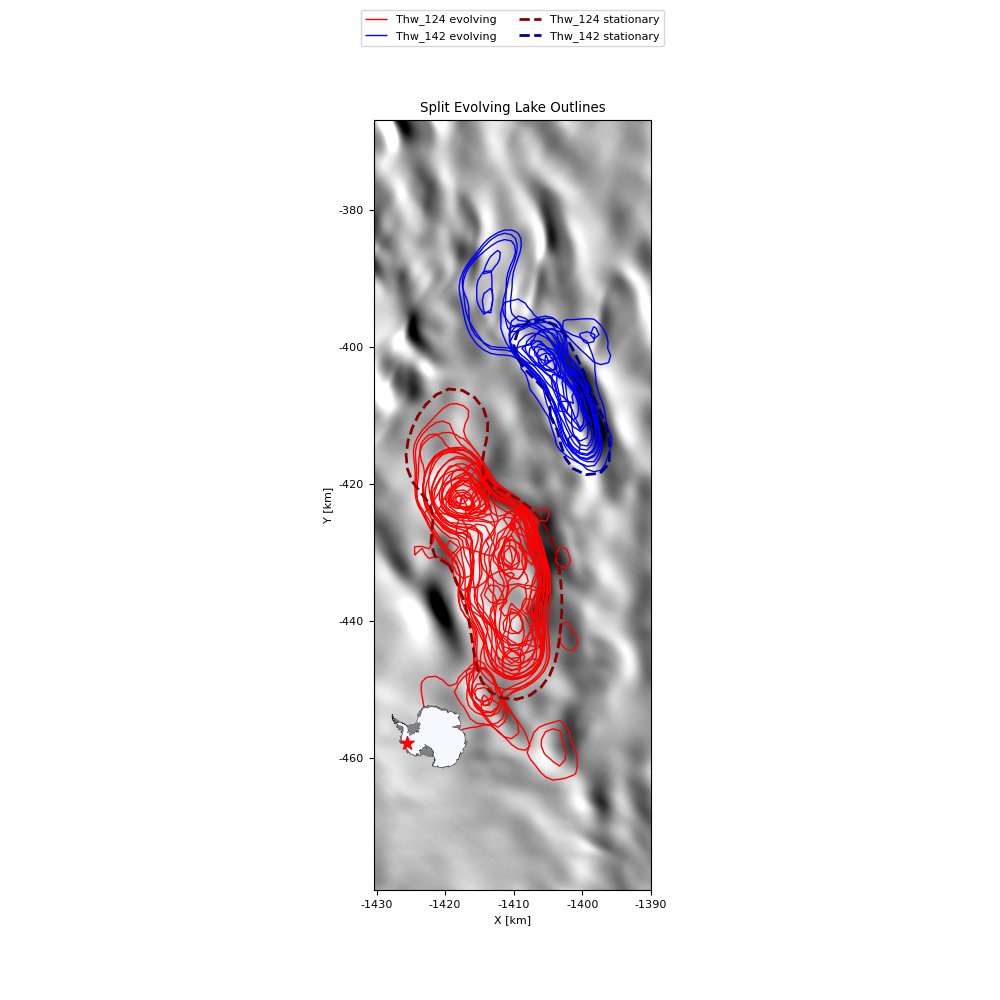

In [75]:
# Quick visualization to ensure outlines were split properly

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Get bounds for plot extent
total_bounds = Thw_124_Thw_142_evolving_outlines_gdf.total_bounds
x_min, y_min, x_max, y_max = total_bounds
buffer_factor = 0.2
x_buffer = (x_max - x_min) * buffer_factor
y_buffer = (y_max - y_min) * buffer_factor

# Plot MOA background
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
ax.imshow(moa_subset[0,:,:], cmap="gray", clim=[14000, 17000], 
         extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

# Plot the outlines
Thw_124_outlines_imported = gpd.read_file('output/lake_outlines/evolving_outlines/Thw_124.geojson')
Thw_142_outlines_imported = gpd.read_file('output/lake_outlines/evolving_outlines/Thw_142.geojson')
Thw_124_outlines_imported.boundary.plot(ax=ax, color='red', linewidth=1, label='Thw_124 evolving')
Thw_142_outlines_imported.boundary.plot(ax=ax, color='blue', linewidth=1, label='Thw_142 evolving')
    
# Plot stationary outlines
Thw_124_gdf.boundary.plot(ax=ax, color='darkred', linestyle='--', linewidth=2, label=f"{Thw_124_gdf['name'].iloc[0]} stationary")
Thw_142_gdf.boundary.plot(ax=ax, color='darkblue', linestyle='--', linewidth=2, label=f"{Thw_142_gdf['name'].iloc[0]} stationary")

# Add inset map
axins = ax.inset_axes([0.05, 0.05, 0.3, 0.3])
axins.set_aspect('equal')
moa_2014_coastline.plot(ax=axins, color='gray', edgecolor='k', linewidth=0.1)
moa_2014_groundingline.plot(ax=axins, color='ghostwhite', edgecolor='k', linewidth=0.1)
center_x = (x_min + x_max) / 2
center_y = (y_min + y_max) / 2
axins.scatter(center_x, center_y, c='red', marker='*', s=100, zorder=5)
axins.axis('off')

# Format main plot
km_scale = 1e3
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale)))
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
ax.set_title('Split Evolving Lake Outlines')

plt.show()

In [76]:
# Plot evolving outlines time series for Thw_124 and Thw_142
Thw_124_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_124']
Thw_142_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == 'Thw_142']
plot_evolving_outlines_time_series(Thw_124_gdf, Thw_124_outlines, Thw_124_offlake_outlines)
plot_evolving_outlines_time_series(Thw_142_gdf, Thw_142_outlines, Thw_142_offlake_outlines)

Creating evolving outlines time series plot for lake: Thw_124
Parameters: row_index=2, within_area_multiple=12, level=0.71
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/Thw_124_2-idx_0.71m-level_12x-within.png
Creating evolving outlines time series plot for lake: Thw_142
Parameters: row_index=2, within_area_multiple=12, level=0.71
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/Thw_142_2-idx_0.71m-level_12x-within.png


In [77]:
del Thw_124_gdf, Thw_124_outlines, Thw_124_offlake_outlines
del Thw_142_gdf, Thw_142_outlines, Thw_142_offlake_outlines

In [78]:
lakes_outputs_to_delete = [
    'Thw_124_Thw_142_Thw_170',
    'Thw_124_Thw_142'
]

In [79]:
for filename in lakes_outputs_to_delete:
    dir = OUTPUT_DIR + '/levels/'
    file_path = os.path.join(dir, f"{filename}.csv")
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Deleted: {file_path}")
    else:
        print(f"Not found: {file_path}")

    dir = 'output/lake_outlines/evolving_outlines/'
    for ext in ('.geojson', '.txt'):
        file_path = os.path.join(dir, f"{filename}{ext}")
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        else:
            print(f"Not found: {file_path}")

del dir, lakes_outputs_to_delete

Not found: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Thw_124_Thw_142_Thw_170.csv
Not found: output/lake_outlines/evolving_outlines/Thw_124_Thw_142_Thw_170.geojson
Not found: output/lake_outlines/evolving_outlines/Thw_124_Thw_142_Thw_170.txt
Deleted: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels/Thw_124_Thw_142.csv
Deleted: output/lake_outlines/evolving_outlines/Thw_124_Thw_142.geojson
Not found: output/lake_outlines/evolving_outlines/Thw_124_Thw_142.txt


# Revise stationary_outlines_gdf

We will revise stationary_outlines_gdf to not have Site_B and Site_C as individual lakes, but instead have Site_BC as a combined lake group.

In [59]:
# Create copy of stationary_outlines_gdf
revised_stationary_outlines_gdf = stationary_outlines_gdf.copy(deep=True)

# Create combined Site_B_Site_C row
site_bc_row = prepare_group_gdf(revised_stationary_outlines_gdf, ['Site_B', 'Site_C'])

# Copy the citation to new Site_B_Site_C row if Sites B and C have the same citation
if (revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_B']['cite'].iloc[0] == 
    revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_C']['cite'].iloc[0]):
    site_bc_row['cite'] = (revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_B']
                          ['cite'].iloc[0])

# Drop individual lakes we are replacing
revised_stationary_outlines_gdf = revised_stationary_outlines_gdf.drop(
    revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'].isin(['Site_B', 'Site_C'])].index)

# Get evolving outlines and calculate area for Site_BC
try:
    lake_name = 'Site_BC'
    
    evolving_outlines_gdf = gpd.read_file('output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
    
    # Get evolving outlines union
    evolving_union_gs = find_evolving_union(site_bc_row.iloc[0], evolving_outlines_gdf, incl_stationary=False)
    
    if evolving_union_gs is not None:
        # Create temporary GeoDataFrame with the union
        temp_gdf = gpd.GeoDataFrame(
            index=[0], 
            crs='EPSG:3031', 
            geometry=[evolving_union_gs.iloc[0]])
        
        # Convert to 4326 for area calculation
        temp_gdf = temp_gdf.to_crs('4326')
        
        # Calculate area
        area = calculate_geodesic_area(temp_gdf['geometry'].iloc[0])
        
        # Update site_bc_row with calculated area and geometry
        site_bc_row['area (m^2)'] = area if area is not None else None
        site_bc_row['geometry'] = evolving_union_gs.iloc[0]


    # Rename to follow combination naming convention used for at passed lakes Lake_78 and Slessor_23
    site_bc_row['name'] = 'Site_BC'
        
except Exception as e:
    print(f"Error processing {lake_name}: {str(e)}")

# Ensure that new entry isn't already in inventory before adding to avoid duplicate entry
gdf_diff = site_bc_row[~site_bc_row['name'].isin(revised_stationary_outlines_gdf['name'])]

# Add the new row to stationary_outlines_gdf
revised_stationary_outlines_gdf = pd.concat([revised_stationary_outlines_gdf, gdf_diff], ignore_index=True)

# Sort the GeoDataFrame alphabetically by the 'name' column; reset the index after sorting
revised_stationary_outlines_gdf = revised_stationary_outlines_gdf.sort_values('name').reset_index(drop=True)

# Print processing confirmation
print(f"\nProcessed {lake_name}")

Preparing group geodataframe for lake group: ['Site_B', 'Site_C']
Group CryoSat-2 SARIn time period determined as: 2010.5

Processed Site_BC


In [60]:
# View new row to ensure worked properly
revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Site_BC']

,name,area (m^2),cite,CS2_SARIn_start,geometry
125,Site_BC,3.741548e+08,"Wright & Siegert, 2012, Antarct. Sci., doi:10....",2010.5,"MULTIPOLYGON (((2224954.472 -992926.956, 22239..."


In [61]:
# Export
revised_stationary_outlines_gdf.to_file(
    'output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson',
    driver='GeoJSON')

In [51]:
# Import
revised_stationary_outlines_gdf = gpd.read_file(
    'output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')

# Review evolving outlines

In your OUTPUT_DIR/FigS1_lake_reexamination_methods, navigate to the `plot_evolving_outlines_time_series` folder. There you will see the time series of evolving outlines plotted in aggregate for each lake. Some lakes will have very few evolving outlines that don't appear much different from the off-lake outlines generated. We additionally looking at the data_counts, dh, and evolving outline video for each time lake in the `find_evolving_outlines` folder for each lake.

In these cases we cannot be certain the evolving outlines are indicative of lake behavior or just background height anomalies. So we delete these evolving outlines geojson files and conclude there were no evolving outlines found for these lakes.

Some deletions are due to a lake's evolving outlines being those of a close neighbor, (e.g., Mac5 evolving outlines were those of Mac4).

In [52]:
lake_outlines_to_discard = [
    'Bindschadler_1',
    'Bindschadler_3',
    'Bindschadler_4',
    'Bindschadler_5',
    'Bindschadler_6',
    'Byrd_s1',
    'Byrd_s5',
    'Byrd_s7',
    'Byrd_s14',
    'Cook_E1',
    'David_s4',
    'David_s5',
    'EAP_3',
    'EAP_5',
    'EAP_6',
    'EAP_7',
    'EAP_8',
    'EAP_9',
    'Foundation_2',
    'Foundation_4',
    'Foundation_9',
    'Foundation_14',
    'Institute_W1',
    'JG_Combined_D2_b_E1',
    'JG_D1_a',
    'JG_D2_a',
    'JG_F1',
    'Kamb_1',
    'Kamb_2',
    'Kamb_3',
    'Kamb_4',
    'Kamb_9',
    'Kamb_11',
    'Lambert_1',
    'LennoxKing_1',
    'Mac5',
    'Mac6',
    'Mertz_1',
    'Rec5',
    'Rec10',
    'Slessor_5',
    'Slessor_6',
    'Slessor_7',
    'TL122',
    'U1',
    'U3',
    'V1',
    'Whillans_8',
    'Wilkes_1',
]

In [53]:
# Discard outlines by moving out of git repo and into non-git repo
discard_lake_outlines(
    lake_outlines_to_discard=lake_outlines_to_discard,
    source_dir='output/lake_outlines/evolving_outlines',
    dest_dir=OUTPUT_DIR + '/find_evolving_outlines/discarded_outlines'
)

{'Bindschadler_1': (True, 'Successfully moved and replaced existing file'),
 'Bindschadler_3': (True, 'Successfully moved and replaced existing file'),
 'Bindschadler_4': (True, 'Successfully moved and replaced existing file'),
 'Bindschadler_5': (True, 'Successfully moved and replaced existing file'),
 'Bindschadler_6': (True, 'Successfully moved and replaced existing file'),
 'Byrd_s1': (True, 'Successfully moved and replaced existing file'),
 'Byrd_s5': (True, 'Successfully moved and replaced existing file'),
 'Byrd_s7': (True, 'Successfully moved and replaced existing file'),
 'Byrd_s14': (True, 'Successfully moved and replaced existing file'),
 'Cook_E1': (True, 'Successfully moved and replaced existing file'),
 'David_s4': (True, 'Successfully moved and replaced existing file'),
 'David_s5': (True, 'Successfully moved and replaced existing file'),
 'EAP_3': (True, 'Successfully moved and replaced existing file'),
 'EAP_5': (True, 'Successfully moved and replaced existing file'),


Similar to the lake groups, we try the next highest level for evolving outlines that appear flawed because of the number of off-lake outlines.

In [83]:
lakes_analyze_row_1 = [
    'Byrd_s10',
    'Byrd_s11',
    'Byrd_s13',
    'Byrd_s15',
    'ConwaySubglacialLake',
    'EngelhardtSubglacialLake',
    'Foundation_N1',
    'Foundation_N3',
    'KT2',
    'KT3',
    'L1',
    'Lake78',
    'Mac1',
    'Nimrod_2',
    'R1',
    'Rec1',
    'Rec2',
    'Rec6',
    'Slessor_4',
    'Slessor_23',
    'Thw_170',
    'UpperSubglacialLakeConway',
 ]

In [84]:
for lake in lakes_analyze_row_1:
    # Process the lake at the next highest level
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=1)

del lakes_analyze_row_1

Visualizing outlines for David_s1
Parameters: row_index=0, within_area_multiple=7, level=0.28, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/David_s1.geojson
Making video for David_s1

Attempt 1 of 3
Validating 57 images...
Video created successfully on attempt 1
Cleaned up folder: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/David_s1
Creating evolving outlines time series plot for lake: David_s1
Parameters: row_index=0, within_area_multiple=7, level=0.28
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/David_s1_0-idx_0.28m-level_7x-within.png


We assess these results (in `OUTPUT_DIR/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series` folder) and decide if 1) lakes analyzed at next highest dh level are satisfactory, or 2) outlines that can be deleted because they are too similar to background off-lake activity or 2) lakes that need to be visualized at the next level because they are too similar to background off-lake activity.

In [74]:
lakes_analyze_row_2 = [
    'ConwaySubglacialLake',
    'David_1',
    'EngelhardtSubglacialLake',
    'Lake78',
    'Mac1',
    'R1',
    'Rec1',
    'Rec2',
    'Slessor_4',
    'Slessor_23',
    'Thw_170',
 ]

In [75]:
for lake in lakes_analyze_row_2:
    # Process the lake at all other levels
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=2)
    
del lakes_analyze_row_2

Visualizing outlines for David_s1
Parameters: row_index=2, within_area_multiple=9, level=0.33, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/David_s1.geojson
Making video for David_s1

Attempt 1 of 3
Validating 57 images...
Video created successfully on attempt 1
Cleaned up folder: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/David_s1
Creating evolving outlines time series plot for lake: David_s1
Parameters: row_index=2, within_area_multiple=9, level=0.33
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/David_s1_2-idx_0.33m-level_9x-within.png


We assess these results (in `OUTPUT_DIR/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series` folder) and decide if 1) lakes analyzed at next highest dh level are satisfactory, or 2) outlines that can be deleted because they are too similar to background off-lake activity or 2) lakes that need to be visualized at the next level because they are too similar to background off-lake activity.

In [80]:
lake_outlines_to_discard = [
    'David_1',
]

In [81]:
# Discard outlines by moving out of git repo and into non-git repo
discard_lake_outlines(
    lake_outlines_to_discard=lake_outlines_to_discard,
    source_dir='output/lake_outlines/evolving_outlines',
    dest_dir=OUTPUT_DIR + '/find_evolving_outlines/discarded_outlines'
)

{'David_1': (True, 'Successfully moved and replaced existing file')}

In [76]:
lakes_analyze_row_3 = [
    'ConwaySubglacialLake',
    'Foundation_N1',
    'R1',
    'Rec2',
    'Slessor_4',
    'Thw_170'
]

In [77]:
for lake in lakes_analyze_row_3:
    # Process the lake at all other levels
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=3)
    
del lakes_analyze_row_3

Visualizing outlines for David_s1
Parameters: row_index=3, within_area_multiple=5, level=0.34, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/David_s1.geojson
Making video for David_s1

Attempt 1 of 3
Validating 57 images...
Video created successfully on attempt 1
Cleaned up folder: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/David_s1
Creating evolving outlines time series plot for lake: David_s1
Parameters: row_index=3, within_area_multiple=5, level=0.34
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/David_s1_3-idx_0.34m-level_5x-within.png


In [137]:
lakes_analyze_row_4 = [
    'ConwaySubglacialLake',
    'Rec2',
    'Slessor_4',
]

In [138]:
for lake in lakes_analyze_row_4:
    # Process the lake at all other levels
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=4)
    
del lakes_analyze_row_4

Visualizing outlines for ConwaySubglacialLake
Parameters: row_index=4, within_area_multiple=7, level=0.56, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/ConwaySubglacialLake.geojson
Making video for ConwaySubglacialLake

Attempt 1 of 3
Validating 57 images...
Video created successfully on attempt 1
Cleaned up folder: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/ConwaySubglacialLake
Creating evolving outlines time series plot for lake: ConwaySubglacialLake
Parameters: row_index=4, within_area_multiple=7, level=0.56
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/ConwaySubglacialLake_4-idx_0.56m-level_7x-within.png


In [139]:
lakes_analyze_row_5 = [
    'ConwaySubglacialLake',
    # 'Rec2',
    # 'Slessor_4',
]

In [140]:
for lake in lakes_analyze_row_5:
    # Process the lake at all other levels
    lake_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'] == lake]
    visualize_and_save_evolving_outlines(lake_gdf, row_index=5)
    
del lakes_analyze_row_5

Visualizing outlines for ConwaySubglacialLake
Parameters: row_index=5, within_area_multiple=2, level=0.58, doi(s)=doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/ATL15.004
Saved outlines to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/offlake_outlines/ConwaySubglacialLake.geojson
Making video for ConwaySubglacialLake

Attempt 1 of 3
Validating 57 images...
Video created successfully on attempt 1
Cleaned up folder: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/find_evolving_outlines/ConwaySubglacialLake
Creating evolving outlines time series plot for lake: ConwaySubglacialLake
Parameters: row_index=5, within_area_multiple=2, level=0.58
Successfully saved plot to: /home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/plot_evolving_outlines_time_series/ConwaySubglacialLake_5-idx_0.58m-level_2x-within.png


In [141]:
# Ensure there are no lakes with both geojson and txt file for evolving outlines
dir = OUTPUT_DIR + '/levels'
file_dict = defaultdict(list)

# Get all files in directory
for file_path in Path(dir).glob('**/*'):
    if file_path.is_file():
        # Get base name without extension
        base_name = file_path.stem
        # Add full filename to list under base name
        file_dict[base_name].append(file_path.name)

# Filter to only files with duplicates
duplicates = {k: v for k, v in file_dict.items() if len(v) > 1}
duplicates

{}

# Union outlines

In [71]:
# Create two new lakes geodataframe that are the union of 
# 1) the evolving outlines for each lake found to have evolving outlines
# 2) the evolving outlines and the stationary outline for lakes with activity (found to have evolving outlines)
# 3) the evolving outlines and the stationary outline for all lakes

# List all folders in target directory
folder_path = 'output/lake_outlines/evolving_outlines'

# Filter stationary_outlines_gdf to only include lakes that have evolving outlines found at them
stationary_outlines_gdf_evolving_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, folder_path, file_extension='geojson', exclude=False)

# Remove Site A, B, C, LSLM, and LSLC because their outlines were perfect circles created using their 
# point locations and approx. areas so should not be part of the union
exclude_list = ['Site_A', 'LowerConwaySubglacialLake', 'LowerMercerSubglacialLake']
stationary_outlines_gdf_evolving_lakes = stationary_outlines_gdf_evolving_lakes[~stationary_outlines_gdf_evolving_lakes['name'].isin(exclude_list)]
stationary_outlines_gdf_all_lakes = revised_stationary_outlines_gdf[~revised_stationary_outlines_gdf['name'].isin(exclude_list)]

# Create initial GDFs
evolving_outlines_union_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_evolving_lakes_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_all_lakes_gdf = stationary_outlines_gdf_all_lakes.copy(deep=True)

# Create initial GDFs
evolving_outlines_union_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_evolving_lakes_gdf = stationary_outlines_gdf_evolving_lakes.copy(deep=True)
evolving_stationary_outlines_union_all_lakes_gdf = stationary_outlines_gdf_all_lakes.copy(deep=True)

# First process lakes with evolving outlines
for idx, row in stationary_outlines_gdf_evolving_lakes.iterrows():
    try:
        lake_ps = stationary_outlines_gdf_evolving_lakes.loc[idx]
        lake_name = lake_ps['name']
        
        try:
            evolving_outlines_gdf = gpd.read_file('output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
        except Exception as e:
            print(f"Skipping because evolving outlines geojson file not found for {lake_name}.")
            continue
            
        # Process evolving outlines
        evolving_union_gs = find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=False)
        evolving_stationary_outlines_union_gs = find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=True)

        if evolving_stationary_outlines_union_gs is None or evolving_union_gs is None:
            print(f"Skipping {lake_name}: Could not create union of outlines")
            continue
            
        try:
            # Store polygon from geoseries in geodataframes with CRS
            evolving_outlines_union_gdf_idx = gpd.GeoDataFrame(
                index=[0], crs='EPSG:3031', geometry=[evolving_union_gs.iloc[0]])
            evolving_stationary_outlines_union_evolving_lakes_gdf_idx = gpd.GeoDataFrame(
                index=[0], crs='EPSG:3031', geometry=[evolving_stationary_outlines_union_gs.iloc[0]])
            
            # Convert GeoDataFrames to EPSG:4326 CRS for geodesic area calculation
            evolving_outlines_union_gdf_idx = evolving_outlines_union_gdf_idx.to_crs('4326')
            evolving_stationary_outlines_union_evolving_lakes_gdf_idx = evolving_stationary_outlines_union_evolving_lakes_gdf_idx.to_crs('4326')
            
            # Update geometries in union GDFs using the correct index
            evolving_outlines_union_gdf.loc[idx, 'geometry'] = evolving_union_gs.iloc[0]
            evolving_stationary_outlines_union_evolving_lakes_gdf.loc[idx, 'geometry'] = evolving_stationary_outlines_union_gs.iloc[0]
            
            # Calculate and store areas
            area1 = calculate_geodesic_area(evolving_outlines_union_gdf_idx['geometry'].iloc[0])
            area2 = calculate_geodesic_area(evolving_stationary_outlines_union_evolving_lakes_gdf_idx['geometry'].iloc[0])
            
            if area1 is not None:
                evolving_outlines_union_gdf.loc[idx, 'area (m^2)'] = area1
            if area2 is not None:
                evolving_stationary_outlines_union_evolving_lakes_gdf.loc[idx, 'area (m^2)'] = area2
                
            # Update the all_lakes GDF for this lake
            mask = evolving_stationary_outlines_union_all_lakes_gdf['name'] == lake_name
            if mask.any():
                evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'geometry'] = evolving_stationary_outlines_union_gs.iloc[0]
                evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'area (m^2)'] = area2
                
        except (IndexError, AttributeError) as e:
            print(f"Error processing geometries for {lake_name}: {str(e)}")
            continue
            
    except Exception as e:
        print(f"Unexpected error processing {lake_name}: {str(e)}")
        continue

# Then process remaining lakes for all_lakes GDF
remaining_lakes = set(stationary_outlines_gdf_all_lakes['name']) - set(stationary_outlines_gdf_evolving_lakes['name'])
for lake_name in remaining_lakes:
    try:
        # Get the lake's data using boolean indexing
        mask = evolving_stationary_outlines_union_all_lakes_gdf['name'] == lake_name
        if not mask.any():
            print(f"Lake {lake_name} not found in all_lakes GDF")
            continue
            
        lake_geom = evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'geometry'].iloc[0]
        
        # Convert to 4326 for area calculation
        temp_gdf = gpd.GeoDataFrame(
            index=[0], crs='EPSG:3031', geometry=[lake_geom])
        temp_gdf = temp_gdf.to_crs('4326')
        area = calculate_geodesic_area(temp_gdf['geometry'].iloc[0])
        
        if area is not None:
            evolving_stationary_outlines_union_all_lakes_gdf.loc[mask, 'area (m^2)'] = area
            
    except Exception as e:
        print(f"Error processing non-evolving lake {lake_name}: {str(e)}")
        continue

# Delete intermediary GDFs
del stationary_outlines_gdf_evolving_lakes, stationary_outlines_gdf_all_lakes

# Make additional_lakes_gdf for Site A, LSLM, and LSLC whose stationary outlines were removed 
# because they were approximations using point location and reported area instead of an actual outline
initial_lakes = ['Site_A', 'LowerConwaySubglacialLake', 'LowerEngelhardtSubglacialLake', 'LowerMercerSubglacialLake']
additional_lakes_gdf = stationary_outlines_gdf[stationary_outlines_gdf['name'].isin(initial_lakes)].copy()

# Add these additional lakes as rows to the union gdf's
for idx, row in additional_lakes_gdf.iterrows():
    try:
        lake_ps = additional_lakes_gdf.loc[idx]
        lake_name = lake_ps['name']
        
        try:
            evolving_outlines_gdf = gpd.read_file('output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name))
        except Exception as e:
            print(f"Skipping because evolving outlines geojson file not found for {lake_name}.")
            continue
           
        # Only get evolving outlines union since there's no stationary outline
        evolving_union_gs = find_evolving_union(lake_ps, evolving_outlines_gdf, incl_stationary=False)
        
        if evolving_union_gs is None:
            print(f"Skipping {lake_name}: Could not create union of outlines")
            continue
           
        try:
            # Create temporary GeoDataFrame with the union
            temp_gdf = gpd.GeoDataFrame(
                index=[0], 
                crs='EPSG:3031', 
                geometry=[evolving_union_gs.iloc[0]])
            
            # Convert to 4326 for area calculation
            temp_gdf = temp_gdf.to_crs('4326')
            
            # Calculate area
            area = calculate_geodesic_area(temp_gdf['geometry'].iloc[0])
            
            # Create new row from the current lake's data
            new_row_gdf = gpd.GeoDataFrame([{
                'name': lake_name,
                'area (m^2)': area if area is not None else None,
                'cite': lake_ps['cite'],
                'CS2_SARIn_start': lake_ps['CS2_SARIn_start'],
                'geometry': evolving_union_gs.iloc[0]
            }], crs='EPSG:3031')

            # For evolving_outlines_union_gdf
            if not lake_name in evolving_outlines_union_gdf['name'].values:
                evolving_outlines_union_gdf = pd.concat([
                    evolving_outlines_union_gdf, 
                    new_row_gdf
                ], ignore_index=True)
            else:
                print(f'Skipping {lake_name} for evolving_outlines_union_gdf - already exists')
                
            # Check if the lake is already in either GeoDataFrame and only append if it's new
            # For evolving_stationary_outlines_union_evolving_lakes_gdf
            if not lake_name in evolving_stationary_outlines_union_evolving_lakes_gdf['name'].values:
                evolving_stationary_outlines_union_evolving_lakes_gdf = pd.concat([
                    evolving_stationary_outlines_union_evolving_lakes_gdf, 
                    new_row_gdf], ignore_index=True)
            else:
                print(f'Skipping {lake_name} for evolving_stationary_outlines_union_evolving_lakes_gdf - already exists')

            # Check if the lake is already in either GeoDataFrame and only append if it's new
            # For evolving_stationary_outlines_union_evolving_lakes_gdf
            if not lake_name in evolving_stationary_outlines_union_all_lakes_gdf['name'].values:
                evolving_stationary_outlines_union_all_lakes_gdf = pd.concat([
                    evolving_stationary_outlines_union_all_lakes_gdf, 
                    new_row_gdf], ignore_index=True)
            else:
                print(f'Skipping {lake_name} for evolving_stationary_outlines_union_evolving_lakes_gdf - already exists')

           
        except (IndexError, AttributeError) as e:
            print(f"Error processing geometries for {lake_name}: {str(e)}")
            continue
           
    except Exception as e:
        print(f"Unexpected error processing {lake_name}: {str(e)}")
        continue

# Sort the GeoDataFrame alphabetically by the 'name' column; Reset the index after sorting; Reproject GeoDataFrame to EPSG:3031
evolving_outlines_union_gdf = evolving_outlines_union_gdf.sort_values('name').reset_index(drop=True).set_crs('3031')
evolving_stationary_outlines_union_evolving_lakes_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf.sort_values('name').reset_index(drop=True)
evolving_stationary_outlines_union_all_lakes_gdf = evolving_stationary_outlines_union_all_lakes_gdf.sort_values('name').reset_index(drop=True)

In [72]:
# Remove any rows where processing failed (geometry is None or invalid)
evolving_outlines_union_gdf = evolving_outlines_union_gdf[
    evolving_outlines_union_gdf.geometry.notna() & 
    evolving_outlines_union_gdf.geometry.is_valid]

evolving_stationary_outlines_union_evolving_lakes_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[
    evolving_stationary_outlines_union_evolving_lakes_gdf.geometry.notna() & 
    evolving_stationary_outlines_union_evolving_lakes_gdf.geometry.is_valid]

evolving_stationary_outlines_union_all_lakes_gdf = evolving_stationary_outlines_union_all_lakes_gdf[
    evolving_stationary_outlines_union_all_lakes_gdf.geometry.notna() & 
    evolving_stationary_outlines_union_all_lakes_gdf.geometry.is_valid]

In [73]:
# Print lengths of GDFs to ensure everything worked properly
print("Length of GDF's for all lakes:")
print(len(revised_stationary_outlines_gdf))
print(len(evolving_stationary_outlines_union_all_lakes_gdf))

# List all folders in target directory
folder_path = 'output/lake_outlines/evolving_outlines'

# Filter stationary_outlines_gdf to only include lakes that have evolving outlines found at them
stationary_outlines_gdf_evolving_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, folder_path, file_extension='geojson', exclude=False)
print("Length of GDF's for lakes that were found to have evolving outlines:")
print(len(stationary_outlines_gdf_evolving_lakes))
print(len(evolving_outlines_union_gdf))
print(len(evolving_stationary_outlines_union_evolving_lakes_gdf))

Length of GDF's for all lakes:
156
156
Length of GDF's for lakes that were found to have evolving outlines:
93
93
93


In [74]:
# FIXME
def compare_names(df1, df2):
    """
    Compare name columns between two dataframes and find unique entries.
    
    Parameters:
    df1, df2: pandas DataFrames containing a 'name' column
    
    Returns:
    tuple: (names_only_in_df1, names_only_in_df2)
    """
    # Find names that are in df1 but not in df2
    only_in_df1 = df1[~df1['name'].isin(df2['name'])]['name']
    
    # Find names that are in df2 but not in df1
    only_in_df2 = df2[~df2['name'].isin(df1['name'])]['name']
    
    return only_in_df1, only_in_df2

# Example usage:
names_df1_only, names_df2_only = compare_names(revised_stationary_outlines_gdf, evolving_stationary_outlines_union_all_lakes_gdf)
print("Names only in first dataframe:", names_df1_only.tolist())
print("Names only in second dataframe:", names_df2_only.tolist())

Names only in first dataframe: []
Names only in second dataframe: []


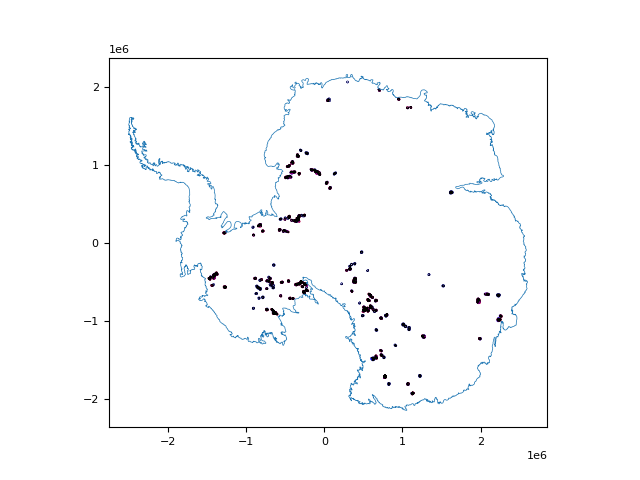

In [75]:
fig, ax = plt.subplots()
stationary_outlines_gdf.boundary.plot(ax=ax, color='blue')
evolving_outlines_union_gdf.boundary.plot(ax=ax, color='red')
evolving_stationary_outlines_union_evolving_lakes_gdf.boundary.plot(ax=ax, color='purple')
evolving_stationary_outlines_union_all_lakes_gdf.boundary.plot(ax=ax, color='k', linestyle='dashed')
Scripps_landice.boundary.plot(ax=ax, lw=0.5)
plt.show()

In [76]:
# Export
evolving_outlines_union_gdf.to_file('output/lake_outlines/evolving_outlines_union_gdf.geojson', driver='GeoJSON')
evolving_stationary_outlines_union_evolving_lakes_gdf.to_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson', driver='GeoJSON')
evolving_stationary_outlines_union_all_lakes_gdf.to_file('output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson', driver='GeoJSON')

INFO:pyogrio._io:Created 93 records
INFO:pyogrio._io:Created 93 records
INFO:pyogrio._io:Created 156 records


In [77]:
# Import to ensure saved properly
evolving_outlines_union_gdf = gpd.read_file(
    'output/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file(
    'output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')
evolving_stationary_outlines_union_all_lakes_gdf = gpd.read_file(
    'output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson')

# Geometric calculations

In [54]:
# Load geodataframes needed for this geometric calculations
revised_stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')
evolving_outlines_union_gdf = gpd.read_file('output/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')
evolving_stationary_outlines_union_all_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson')

In [55]:
# Create output directories before processing any lakes
os.makedirs('output/geometric_calcs/evolving_outlines_geom_calc', exist_ok=True)
os.makedirs('output/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes', exist_ok=True)
os.makedirs('output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes', exist_ok=True)
os.makedirs('output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes', exist_ok=True)
os.makedirs('output/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_evolving_lakes', exist_ok=True)
os.makedirs('output/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_all_lakes', exist_ok=True)

In [78]:
# Get list of remaining lakes left to process based on

# 1) Filter out lakes that have evolving outlines
folder_path = 'output/lake_outlines/evolving_outlines'
evolving_lakes_gdf = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, 
    folder_path, exclude=True, file_extension='txt')

# 2) Filter out lakes that have already been processed in each directory
folder_paths = [
    OUTPUT_DIR_GIT + '/geometric_calcs/evolving_outlines_geom_calc/',
    OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes/',
    OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes/',
    OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_evolving_lakes/',
]

# Create a list to store filtered GeoDataFrames
filtered_gdfs = []

# Filter the original GeoDataFrame for each directory and add to list
for folder_path in folder_paths:
    filtered_gdf = filter_gdf_by_folder_contents(evolving_lakes_gdf, folder_path)
    if not filtered_gdf.empty:
        filtered_gdfs.append(filtered_gdf)

# Concatenate all filtered GeoDataFrames and drop duplicates
if filtered_gdfs:
    remaining_lakes = pd.concat(filtered_gdfs, ignore_index=True)
    remaining_lakes = remaining_lakes.drop_duplicates(subset='name').reset_index(drop=True)
else:
    remaining_lakes = gpd.GeoDataFrame(columns=evolving_lakes_gdf.columns)

print(f"{len(remaining_lakes)} lake(s) to process.")

# Process geometric calculations on lakes
total_lakes = len(remaining_lakes)
processed_lakes = 0

for i in remaining_lakes.index:
    remaining_count = total_lakes - processed_lakes
    print(f"{remaining_count} lakes remain.")
    
    try:
        # Isolate lake from remaining_lakes as geodataframe
        stationary_outline_gdf = remaining_lakes.loc[[i]]
        lake_name = stationary_outline_gdf['name'].iloc[0]
        
        if stationary_outline_gdf.empty:
            print("Skipping empty lake entry")
            continue
        
        # Prepare data sets
        dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(stationary_outline_gdf, 30)
    
        # Check if lake has evolving outlines
        has_evolving_outlines = os.path.exists(os.path.join(
            os.getcwd(), 'output/lake_outlines/evolving_outlines', f"{stationary_outline_gdf['name'].iloc[0]}.geojson"))
        
        if has_evolving_outlines:
            # Calculate active area, dh, and dV for lakes with evolving outlines
            evolving_outlines_geom_calc(stationary_outline_gdf=stationary_outline_gdf,
                dataset1=dataset1_masked, dataset2=dataset2_masked)

            # And for stationary outlines (at evolving lakes only)
            stationary_outline_geom_calc(stationary_outline_gdf=stationary_outline_gdf,
               dataset1=dataset1_masked, dataset2=dataset2_masked, sub_dir='stationary_outlines_at_evolving_lakes')
            
            # And for evolving outlines union (at evolving lakes only)
            evolving_union_gdf = evolving_outlines_union_gdf[
                evolving_outlines_union_gdf['name'] == lake_name]
            if not evolving_union_gdf.empty:
                stationary_outline_geom_calc(stationary_outline_gdf=evolving_union_gdf,
                    dataset1=dataset1_masked, dataset2=dataset2_masked, sub_dir='evolving_union_at_evolving_lakes')
            else:
                print(f"No evolving union outline found for lake: {lake_name}")
            
            # And for evolving-stationary outlines union (at evolving lakes only)
            evolving_stationary_union_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[
                evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]
            if not evolving_stationary_union_gdf.empty:
                stationary_outline_geom_calc(stationary_outline_gdf=evolving_stationary_union_gdf,
                    dataset1=dataset1_masked, dataset2=dataset2_masked, sub_dir='evolving_stationary_union_at_evolving_lakes')
            else:
                print(f"No evolving-stationary union outline found for lake: {lake_name}")
            
        # Increment processing counter
        processed_lakes += 1
        # Clear output of each index
        clear_output(wait=True)
        
    except Exception as e:
        print(f"Error processing lake '{lake_name}' at index {i}: {str(e)}")
        continue

if processed_lakes == total_lakes:
    print("All remaining lakes have been processed.")
else:
    print(f"Processing complete. {total_lakes - processed_lakes} lakes were skipped due to errors.")

All remaining lakes have been processed.


In [79]:
# Get list of remaining lakes left to process based on

# Filter out lakes that have already been processed in each directory
folder_paths = [
    OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes/',
    OUTPUT_DIR_GIT + '/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_all_lakes/'
]

# Create a list to store filtered GeoDataFrames
filtered_gdfs = []

# Filter the original GeoDataFrame for each directory and add to list
for folder_path in folder_paths:
    filtered_gdf = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, folder_path)
    if not filtered_gdf.empty:
        filtered_gdfs.append(filtered_gdf)

# Concatenate all filtered GeoDataFrames and drop duplicates
if filtered_gdfs:
    remaining_lakes = pd.concat(filtered_gdfs, ignore_index=True)
    remaining_lakes = remaining_lakes.drop_duplicates(subset='name').reset_index(drop=True)
else:
    remaining_lakes = gpd.GeoDataFrame(columns=revised_stationary_outlines_gdf.columns)

print(f"{len(remaining_lakes)} lake(s) to process.")

# Process geometric calculations on lakes
total_lakes = len(remaining_lakes)
processed_lakes = 0

for i in remaining_lakes.index:
    remaining_count = total_lakes - processed_lakes
    print(f"{remaining_count} lakes remain.")
    
    try:
        # Isolate lake from remaining_lakes as geodataframe
        stationary_outline_gdf = remaining_lakes.loc[[i]]
        lake_name = stationary_outline_gdf['name'].iloc[0]
        
        if stationary_outline_gdf.empty:
            print("Skipping empty lake entry")
            continue
        
        # Prepare data sets
        dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(stationary_outline_gdf, 30)

        # And for stationary outlines (at all lakes)
        stationary_outline_geom_calc(stationary_outline_gdf=stationary_outline_gdf,
           dataset1=dataset1_masked, dataset2=dataset2_masked, sub_dir='stationary_outlines_at_all_lakes')
        # And for evolving-stationary outlines union (at all lakes)
        evolving_stationary_union_gdf = evolving_stationary_outlines_union_all_lakes_gdf[
            evolving_stationary_outlines_union_all_lakes_gdf['name'] == lake_name]
        if not evolving_stationary_union_gdf.empty:
            stationary_outline_geom_calc(stationary_outline_gdf=evolving_stationary_union_gdf,
                dataset1=dataset1_masked, dataset2=dataset2_masked, sub_dir='evolving_stationary_union_at_all_lakes')
        else:
            print(f"No evolving-stationary union outline found for lake: {lake_name}")
            
        # Increment processing counter
        processed_lakes += 1
        # Clear output of each index
        clear_output(wait=True)
        
    except Exception as e:
        print(f"Error processing lake '{lake_name}' at index {i}: {str(e)}")
        continue

if processed_lakes == total_lakes:
    print("All remaining lakes have been processed.")
else:
    print(f"Processing complete. {total_lakes - processed_lakes} lakes were skipped due to errors.")

0 lake(s) to process.
All remaining lakes have been processed.


# Visualizations of geometric data

In [52]:
# Load geodataframe needed
revised_stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')
evolving_outlines_union_gdf = gpd.read_file('output/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')

In [73]:
# # Get list of remaining lakes left to process based on
# # 1) lakes that have evolving outlines
# folder_path = 'output/lake_outlines/evolving_outlines'
# remaining_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, 
#     folder_path, exclude=True, file_extension='txt')

# # 2) lakes that have already be processed using the desired func
# folder_path = OUTPUT_DIR + '/plot_evolving_and_stationary_comparison'
# os.makedirs(folder_path, exist_ok=True)
# remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path, exclude=True)

# # Check if any lakes remain after initial filtering
# if remaining_lakes.empty:
#     print("All lakes processed.")
# else:
#     for i in range(len(remaining_lakes)):
#         print(f"{len(remaining_lakes)} lake(s) remain.")
        
#         # Get single lake and validate
#         lake_gdf = remaining_lakes.iloc[[i]]
#         lake_name = lake_gdf['name'].iloc[0]

#         if lake_gdf.empty:
#             print(f"Warning: Empty lake_gdf at index {i}. Skipping...")
#             continue
        
#         try:
#             plot_evolving_and_stationary_comparison(lake_gdf)
#         except Exception as e:
#             print(f"Error processing lake {lake_name}: {str(e)}")
#             continue
            
#         # Recheck remaining lakes with validation
#         new_remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path)
#         if new_remaining_lakes is None or new_remaining_lakes.empty:
#             print("No lakes remain after recheck.")
#             break
#         remaining_lakes = new_remaining_lakes

#         # Clear output of each index
#         clear_output(wait=True)

#     print("All lakes processed.")

In [81]:
# Get list of remaining lakes left to process based on
# 1) lakes that have evolving outlines
folder_path = 'output/lake_outlines/evolving_outlines'
remaining_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, 
    folder_path, exclude=True, file_extension='txt')

# 2) lakes that have already be processed using the desired func
folder_path = OUTPUT_DIR + '/plot_evolving_and_stationary_comparison'
os.makedirs(folder_path, exist_ok=True)
remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path, exclude=True)

# Reset index to avoid indexing issues
remaining_lakes = remaining_lakes.reset_index(drop=True)

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    while not remaining_lakes.empty:
        print(f"{len(remaining_lakes)} lake(s) remain.")
        
        # Always get the first lake to process
        lake_gdf = remaining_lakes.iloc[[0]]  # Always take the first row
        lake_name = lake_gdf['name'].iloc[0]

        if lake_gdf.empty:
            print("Warning: Empty lake_gdf. Skipping...")
            continue

        try:
            plot_evolving_and_stationary_comparison(lake_gdf)
        except Exception as e:
            print(f"Error processing lake {lake_name}: {str(e)}")
            continue

        # Recheck remaining lakes after processing
        remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path)

        if remaining_lakes is None or remaining_lakes.empty:
            print("No lakes remain after recheck.")
            break

        # Reset index to prevent index misalignment
        remaining_lakes = remaining_lakes.reset_index(drop=True)

        # Clear output of each index
        clear_output(wait=True)

    print("All lakes processed.")

1 lake(s) remain.
Processing lake: L1
No lakes remain after recheck.
All lakes processed.


In [91]:
# Get list of remaining lakes left to process based on

# 1) lakes that have evolving outlines
folder_path = 'output/lake_outlines/evolving_outlines'
remaining_lakes = filter_gdf_by_folder_contents(revised_stationary_outlines_gdf, 
    folder_path, file_extension='txt')

# 2) lakes that have already be processed
folder_path = OUTPUT_DIR + '/plot_evolving_and_stationary_comparison_sequential'
os.makedirs(folder_path, exist_ok=True)
remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path, file_extension='mp4')

if remaining_lakes.empty:
    print("All lakes processed.")
else:
    for i in range(len(remaining_lakes)):
        print(len(remaining_lakes), 'lake(s) remain.')
        
        # Process the lake
        lake_gdf = remaining_lakes.iloc[0:1]
        plot_evolving_and_stationary_comparison_sequential(lake_gdf)

        # Recheck which lakes still need processing
        remaining_lakes = filter_gdf_by_folder_contents(remaining_lakes, folder_path)

        # Clear output of each index
        clear_output(wait=True)

        if remaining_lakes.empty:
            print("All lakes processed.")
            break

All lakes processed.


# Final check that all lakes have been processed

In [54]:
# Load geodataframe needed
revised_stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')

In [92]:
# Ensure all lakes were reanalyzed
print('Analysis done on all previously identified lakes')

print(len(stationary_outlines_gdf), 'lakes reanalyzed')

dir = OUTPUT_DIR + '/levels'
print(len([f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]), 
      'lakes analyzed using find_and_save_optimal_paraters func')

# Breakdown of lakes where evolving outlines were found vs. not
print(len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.geojson')]),
      'lakes found to have evolving outlines')
print(len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.txt')]),
      'lakes found to have no evolving outlines')
print(len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.geojson')]) +
      len([f for f in os.listdir('output/lake_outlines/evolving_outlines') if f.endswith('.txt')]), 
      'sum of lakes found with and without evolving outlines')

# Analysis done on evolving lakes
print('\nAnalysis done only on previously identified lakes found to have evolving outlines')

# These directories will have four more csv files because of continental sums files for four sets of lakes
# so if this code is rerun after the 'Continental summations' section, the counts will be higher than expected

print(len(revised_stationary_outlines_gdf), 
    'lakes analyzed in revised inventory due to Site_B and Site_C being combined into Site_BC')

dir = 'output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes'
print(len([f for f in os.listdir(dir) if f.endswith('.csv')]),
      'lakes analyzed using stationary_outline_geom_calc/stationary_outlines_at_all_lakes')

dir = 'output/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_all_lakes'
print(len([f for f in os.listdir(dir) if f.endswith('.csv')]),
      'lakes analyzed using stationary_outline_geom_calc/evolving_stationary_union_at_all_lakes')

dir = 'output/geometric_calcs/evolving_outlines_geom_calc'
print(len([f for f in os.listdir(dir) if f.endswith('.csv') and not Path(f).stem.endswith('_sum')]),
      'lakes analyzed using evolving_outlines_geom_calc')

dir = 'output/geometric_calcs/stationary_outline_geom_calc/evolving_union_at_evolving_lakes'
print(len([f for f in os.listdir(dir) if f.endswith('.csv') and not Path(f).stem.endswith('_sum')]),
      'lakes analyzed using stationary_outline_geom_calc/evolving_union_at_evolving_lakes')

dir = 'output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes'
print(len([f for f in os.listdir(dir) if f.endswith('.csv') and not Path(f).stem.endswith('_sum')]),
      'lakes analyzed using stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes')

dir = 'output/geometric_calcs/stationary_outline_geom_calc/evolving_stationary_union_at_evolving_lakes'
print(len([f for f in os.listdir(dir) if f.endswith('.csv') and not Path(f).stem.endswith('_sum')]),
      'lakes analyzed using stationary_outline_geom_calc/evolving_stationary_union_at_evolving_lakes')

dir = OUTPUT_DIR + '/plot_evolving_and_stationary_comparison'
print(len([f for f in os.listdir(dir) if f.endswith('.png')]),
      'lakes analyzed using plot_evolving_and_stationary_comparison')

dir = OUTPUT_DIR + '/plot_evolving_and_stationary_comparison_sequential'
print(len([f for f in os.listdir(dir) if f.endswith('.mp4')]),
      'lakes analyzed using plot_evolving_and_stationary_comparison_sequential')

Analysis done on all previously identified lakes
157 lakes reanalyzed
156 lakes analyzed using find_and_save_optimal_paraters func
93 lakes found to have evolving outlines
63 lakes found to have no evolving outlines
156 sum of lakes found with and without evolving outlines

Analysis done only on previously identified lakes found to have evolving outlines
156 lakes analyzed in revised inventory due to Site_B and Site_C being combined into Site_BC
156 lakes analyzed using stationary_outline_geom_calc/stationary_outlines_at_all_lakes
156 lakes analyzed using stationary_outline_geom_calc/evolving_stationary_union_at_all_lakes
93 lakes analyzed using evolving_outlines_geom_calc
93 lakes analyzed using stationary_outline_geom_calc/evolving_union_at_evolving_lakes
93 lakes analyzed using stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes
93 lakes analyzed using stationary_outline_geom_calc/evolving_stationary_union_at_evolving_lakes
93 lakes analyzed using plot_evolving_and_st

# Continental summations

In [33]:
# Load geodataframe needed
revised_stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')

In [34]:
# List of comparison types
geom_calc_types = [
    'stationary_outline_geom_calc/stationary_outlines_at_all_lakes',
    'stationary_outline_geom_calc/evolving_stationary_union_at_all_lakes',
    'evolving_outlines_geom_calc',
    'stationary_outline_geom_calc/evolving_union_at_evolving_lakes',
    'stationary_outline_geom_calc/stationary_outlines_at_evolving_lakes',
    'stationary_outline_geom_calc/evolving_stationary_union_at_evolving_lakes',
]

# Process each comparison type
for geom_calc_type in geom_calc_types:
    process_continental_sums(geom_calc_type)

## Explaining continental sum trends

In [42]:
directory = 'output/geometric_calcs/evolving_outlines_geom_calc'

def create_interactive_plot(directory, stationary_outlines_gdf):
    # Load and process all lake data
    dfs = []
    lake_names = []
    
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            lake_name = os.path.splitext(file)[0]
            
            # Process each lake's data
            df['lake_name'] = lake_name
            df['datetime'] = pd.to_datetime(df['midcyc_datetime'])
            df['cumsum_vol'] = np.cumsum(df['evolving_outlines_dV_corr (m^3)'])
            dfs.append(df)
            lake_names.append(lake_name)
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Create plot using hvplot
    plot = combined_df.hvplot.line(
        x='datetime',
        y='cumsum_vol',
        by='lake_name',
        width=800,
        height=400,
        title='Lake Volume Changes Over Time',
        xlabel='Date',
        ylabel='Cumulative Volume Change (m³)',
        grid=True,
        legend=False
    )
    
    return plot

# Usage:
plot = create_interactive_plot(directory, stationary_outlines_gdf)
plot  # Display in notebook

:NdOverlay   [lake_name]
   :Curve   [datetime]   (cumsum_vol)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
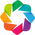

:HoloMap   [lake_name]
   :Curve   [datetime]   (cumsum_vol,lake_name)

In [46]:

directory = 'output/geometric_calcs/evolving_outlines_geom_calc'

def create_interactive_plot(directory, stationary_outlines_gdf):
    # Load and process all lake data
    dfs_subset_CS2_IS2_lakes = []
    lake_names = []
    
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            lake_name = os.path.splitext(file)[0]
            
            # Process each lake's data
            df['lake_name'] = lake_name
            df['datetime'] = pd.to_datetime(df['midcyc_datetime'])
            df['cumsum_vol'] = np.cumsum(np.divide(df['evolving_outlines_dV_corr (m^3)'], 1e9))
            dfs_subset_CS2_IS2_lakes.append(df)
            lake_names.append(lake_name)
    
    # Combine all dataframes
    combined_df = pd.concat(dfs_subset_CS2_IS2_lakes, ignore_index=True)
    
    # Create the plot using Dataset and Curve
    dataset = hv.Dataset(combined_df)
    curves = dataset.to(hv.Curve, 
                       kdims=['datetime'], 
                       vdims=['cumsum_vol', 'lake_name'],
                       groupby='lake_name')
    
    # Apply options to the plot
    plot = curves.opts(
        width=800,
        height=400,
        tools=['hover'],
        title='Lake Volume Changes Over Time',
        xlabel='Date',
        ylabel='Cumulative Volume Change (m³)',
        show_grid=True,
        toolbar='above'
    )
    
    return plot

# Usage:
plot = create_interactive_plot(directory, stationary_outlines_gdf)
plot  # Display in notebook

In [48]:
# Investigate the lakes driving the deviation of evolving and stationary 

evolving_directory = 'output/geometric_calcs/evolving_outlines_geom_calc'
stationary_directory = 'output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes'

def process_lake_data(directory, is_evolving=True):
    dfs = {}
    
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            lake_name = os.path.splitext(file)[0]
            
            # Process each lake's data
            df['lake_name'] = lake_name
            df['datetime'] = pd.to_datetime(df['midcyc_datetime'])
            
            # Calculate cumulative volume based on directory type
            if is_evolving:
                df['cumsum_vol'] = np.cumsum(df['evolving_outlines_dV_corr (m^3)'])
            else:
                df['cumsum_vol'] = np.cumsum(df['stationary_outline_dV_corr (m^3)'])
            
            dfs[lake_name] = df
    
    return dfs

def create_interactive_plot(evolving_directory, stationary_directory):
    # Load data from both directories
    evolving_dfs = process_lake_data(evolving_directory, is_evolving=True)
    stationary_dfs = process_lake_data(stationary_directory, is_evolving=False)
    
    # Initialize lists to store processed dataframes
    plot_dfs = []
    
    # Process common lakes
    common_lakes = set(evolving_dfs.keys()) & set(stationary_dfs.keys())
    for lake_name in common_lakes:
        evolving_df = evolving_dfs[lake_name].copy()
        stationary_df = stationary_dfs[lake_name].copy()
        
        # Calculate difference (evolving - stationary)
        merged_df = pd.merge(
            evolving_df[['datetime', 'cumsum_vol']], 
            stationary_df[['datetime', 'cumsum_vol']], 
            on='datetime', 
            suffixes=('_evolving', '_stationary')
        )
        merged_df['cumsum_vol'] = merged_df['cumsum_vol_evolving'] - merged_df['cumsum_vol_stationary']
        merged_df['lake_name'] = lake_name + '_difference'
        plot_dfs.append(merged_df[['datetime', 'cumsum_vol', 'lake_name']])
    
    # Process lakes only in stationary directory
    stationary_only = set(stationary_dfs.keys()) - set(evolving_dfs.keys())
    for lake_name in stationary_only:
        df = stationary_dfs[lake_name].copy()
        df['lake_name'] = lake_name + '_stationary'
        plot_dfs.append(df[['datetime', 'cumsum_vol', 'lake_name']])
    
    # Combine all dataframes
    combined_df = pd.concat(plot_dfs, ignore_index=True)
    
    # Create plot using hvplot
    plot = combined_df.hvplot.line(
        x='datetime',
        y='cumsum_vol',
        by='lake_name',
        width=800,
        height=400,
        title='Lake Volume Changes Over Time',
        xlabel='Date',
        ylabel='Cumulative Volume Change (m³)',
        grid=True,
        legend=False
    )
    
    return plot

# Usage:
plot = create_interactive_plot(evolving_directory, stationary_directory)
plot  # Display in notebook

:NdOverlay   [lake_name]
   :Curve   [datetime]   (cumsum_vol)

# Fig. S1

In [51]:
# Add something along the lines of code below to illustrate lake area/outline for evolving outline union boundary/area:
# # Plot polygons in the GeoDataFrame
# gdf.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1, label='Lake area')
# gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Lake outline')

# Add off-lake, lake (no corr.) to dh plot to illustrate correction

In [104]:
plt.rcParams.update({
    'font.family': 'DejaVu Sans',
    'font.size': 9,
    'axes.labelsize': 10,
    'axes.titlesize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'legend.fontsize': 9,
})

In [105]:
# Load datasets necessary for plotting
revised_stationary_outlines_gdf = gpd.read_file('output/lake_outlines/stationary_outlines/revised_stationary_outlines_gdf.geojson')
evolving_outlines_union_gdf = gpd.read_file('output/lake_outlines/evolving_outlines_union_gdf.geojson')
evolving_stationary_outlines_union_evolving_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_evolving_lakes_gdf.geojson')
evolving_stationary_outlines_union_all_lakes_gdf = gpd.read_file('output/lake_outlines/evolving_stationary_outlines_union_all_lakes_gdf.geojson')

In [106]:
# Make output directory for figures
os.makedirs(OUTPUT_DIR + '/figures', exist_ok=True)

# Select lake
lake_gdf = revised_stationary_outlines_gdf[revised_stationary_outlines_gdf['name'] == 'Institute_E1']

# Define lake name and polygon
lake_name = lake_gdf['name'].iloc[0]
lake_poly = lake_gdf['geometry'].iloc[0]

# Load evolving outlines as geodataframe
try:
    onlake_outlines_gdf = gpd.read_file(os.path.join(
        os.getcwd(), 'output/lake_outlines/evolving_outlines/{}.geojson'.format(lake_name)))
except fiona.errors.DriverError:
    print(f"File for {lake_name} not found.")

# Load off-lake evolving outlines as geodataframe
try:
    offlake_outlines_gdf = gpd.read_file(OUTPUT_DIR + '/find_evolving_outlines/offlake_outlines/{}.geojson'.format(lake_name))
except fiona.errors.DriverError:
    print(f"File for {lake_name} not found.")

# Ensure the result is a GeoDataFrame with proper geometry
evolving_outlines_gdf = gpd.GeoDataFrame(
    pd.concat([onlake_outlines_gdf, offlake_outlines_gdf], ignore_index=True),
    geometry='geometry', crs=onlake_outlines_gdf.crs)

# Load evolving outlines union
evolving_stationary_union_gdf = evolving_stationary_outlines_union_evolving_lakes_gdf[evolving_stationary_outlines_union_evolving_lakes_gdf['name'] == lake_name]
evolving_union_gdf = evolving_outlines_union_gdf[evolving_outlines_union_gdf['name'] == lake_name]

# Load evolving outlines search parameters
row_index=evolving_outlines_gdf['row_index'][0]
within_area_multiple=evolving_outlines_gdf['within_area_multiple'][0]
level=evolving_outlines_gdf['level'][0]

# Attempt to open the geometric calculations CSV files
try:
    evolving_geom_calcs_df = pd.read_csv(os.path.join(
        os.getcwd(), 'output/geometric_calcs/evolving_outlines_geom_calc/{}.csv'.format(lake_name)))
    stationary_geom_calcs_df = pd.read_csv(os.path.join(
        os.getcwd(), 
        'output/geometric_calcs/stationary_outline_geom_calc/stationary_outlines_at_all_lakes/{}.csv'.format(lake_name)))
except FileNotFoundError:
    print(f"CSV files for {lake_name} not found.")

# Convert of strings to datetime
evolving_geom_calcs_df['midcyc_datetime'] = pd.to_datetime(evolving_geom_calcs_df['midcyc_datetime'])
stationary_geom_calcs_df['midcyc_datetime'] = pd.to_datetime(stationary_geom_calcs_df['midcyc_datetime'])

# Prepare datasets - using larger buffer for initial masking
dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

dataset1_dh = dataset1_masked['delta_h'].diff('time')
dataset2_dh = dataset2_masked['delta_h'].diff('time')

# Select time step to show for CryoSat-2 (CS2) and ICESat-2 (IS2) eras
CS2_i = 1  
IS2_i = 12

# Isolate dh time steps
CS2_timestep = dataset1_masked['time'][CS2_i].values
IS2_timestep = dataset2_masked['time'][IS2_i].values

# Convert date_list to numpy array
CS2_cyc_start_dates_npa = np.array(cyc_start_dates, dtype='datetime64')
IS2_cyc_start_dates_npa = np.array(cyc_start_dates, dtype='datetime64')

# Find matching cyc_dates index
CS2_cyc_dates_idx = np.where(CS2_cyc_start_dates_npa == CS2_timestep)[0][0]
IS2_cyc_dates_idx = np.where(IS2_cyc_start_dates_npa == IS2_timestep)[0][0]

# Initialize empty lists for height anomalies
height_anom_pos = []
height_anom_neg = []

# Get height anomalies for CryoSat-2 timestep (i = 20)
if dataset1_masked is not None:
    if np.any(~np.isnan(dataset1_dh[CS2_i])):
        height_anom_pos.append(np.nanmax(dataset1_dh[CS2_i]))
        height_anom_neg.append(np.nanmin(dataset1_dh[CS2_i]))

# Get height anomalies for ICESat-2 timestep (i = 12)
if np.any(~np.isnan(dataset2_dh[IS2_i])):
    height_anom_pos.append(np.nanmax(dataset2_dh[IS2_i]))
    height_anom_neg.append(np.nanmin(dataset2_dh[IS2_i]))

# Find max height anomalies across both time slices
max_height_anom_pos = max(height_anom_pos)
max_height_anom_neg = min(height_anom_neg)
max_anom = max([max_height_anom_pos, abs(max_height_anom_neg)])
del height_anom_pos, height_anom_neg

# Create the diverging normalization for the colormap
divnorm = colors.TwoSlopeNorm(vmin=-max_anom, vcenter=0., vmax=max_anom)
del max_height_anom_pos, max_height_anom_neg

# Establish x_min, x_max, y_min, y_max
ROI_poly = area_multiple_buffer(lake_poly, 25)
x_min, y_min, x_max, y_max = ROI_poly.bounds
x_buffer, y_buffer = abs(x_max-x_min)*0.02, abs(y_max-y_min)*0.02

# Subsetting dataset
dataset1 = CS2_Smith2017
dataset2 = ATL15_dh

# Prepare datasets
dataset1_doi, dataset2_doi, search_extent_poly, (dataset1_masked, dataset2_masked) = prepare_datasets(lake_gdf, 25)

# Create figure with GridSpec - modified to include timeline panel
fig = plt.figure(figsize=(10,16))  # Increased height to accommodate new panel
gs = fig.add_gridspec(4, 2, height_ratios=[0.24, 1, 1, 1], hspace=0.3, wspace=0.3)

# Create remaining axes array excluding timeline row
axs = np.array([[fig.add_subplot(gs[i,j]) for j in range(2)] for i in range(1,4)])


# Panel - Satellite era timeline

# Add timeline panel spanning both columns
timeline_ax = fig.add_subplot(gs[0, :])

# Create timeline visualization
timeline_ax.set_xlim(cyc_start_dates[0], cyc_end_dates[-1])
timeline_ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
timeline_ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Plot colored bars for different satellite eras
for i, date in enumerate(cyc_dates['mid_cyc_dates']):
    dataset = cyc_dates['dataset'][i]
    color = 'lightblue' if dataset == 'CS2_Smith2017' else 'lightgreen'
    label = 'CryoSat-2' if dataset == 'CS2_Smith2017' else 'ICESat-2'
    
    if i == 0:  # Only add label for first occurrence of each dataset
        timeline_ax.axvspan(cyc_dates['cyc_start_dates'][i], cyc_dates['cyc_end_dates'][i], 
                          color=color, alpha=0.3, label=label)
    else:
        # Check if dataset changed from previous
        if cyc_dates['dataset'][i] != cyc_dates['dataset'][i-1]:
            timeline_ax.axvspan(cyc_dates['cyc_start_dates'][i], cyc_dates['cyc_end_dates'][i], 
                              color=color, alpha=0.3, label=label)
        else:
            timeline_ax.axvspan(cyc_dates['cyc_start_dates'][i], cyc_dates['cyc_end_dates'][i], 
                              color=color, alpha=0.3)

# Get the dates for our timesteps shown in top panels
# For CryoSat-2
cs2_start_date = cyc_start_dates[CS2_cyc_dates_idx]
cs2_end_date = cyc_end_dates[CS2_cyc_dates_idx]

# For ICESat-2
is2_start_date = cyc_start_dates[IS2_cyc_dates_idx]
is2_end_date = cyc_end_dates[IS2_cyc_dates_idx]

# Add vertical spans for the timesteps shown in top panels
# For CryoSat-2
timeline_ax.axvspan(mdates.date2num(cs2_start_date), 
                              mdates.date2num(cs2_end_date),
                              color='gray', alpha=0.3)

# For ICESat-2
timeline_ax.axvspan(mdates.date2num(is2_start_date),
                              mdates.date2num(is2_end_date),
                              color='gray', alpha=0.3)
# Create patches for legend
cs2_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='CryoSat-2')
is2_patch = mpatches.Patch(color='lightgreen', alpha=0.3, label='ICESat-2')
timestep_patch = mpatches.Patch(color='gray', alpha=0.3, label='displayed time step')

# Add legend with all patches
timeline_ax.legend(handles=[cs2_patch, is2_patch, timestep_patch], 
                  loc='upper right')

# Customize timeline appearance
# timeline_ax.legend(loc='upper right')
timeline_ax.set_title('Multi-mission satellite timeline')

# Remove y-axis ticks and labels
timeline_ax.set_yticks([])


# Panel - CryoSat-2 dh time step with evolving outlines and area multiple within evaluation lines

# Plot dh time step
img = axs[0,0].imshow(dataset1_dh[CS2_i], cmap='RdBu', norm=divnorm, 
                      origin='lower', extent=[x_min, x_max, y_min, y_max])

dt = mid_cyc_dates[CS2_cyc_dates_idx]
evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

if not evolving_outlines_gdf.empty:
    # Split into positive and negative dh values
    positive_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] > 0]
    negative_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] < 0]
    
    # Plot positive dh in blue
    if not positive_outlines.empty:
        positive_outlines.boundary.plot(ax=axs[0,0], color='blue', linewidth=1)
    
    # Plot negative dh in red
    if not negative_outlines.empty:
        negative_outlines.boundary.plot(ax=axs[0,0], color='red', linewidth=1)

# Plot inset map
axIns = axs[0,0].inset_axes([0.02, 0, 0.3, 0.3]) # [left, bottom, width, height] (fractional axes coordinates)
axIns.set_aspect('equal')
moa_2014_coastline.plot(ax=axIns, color='gray', edgecolor='k', linewidth=0.1)
moa_2014_groundingline.plot(ax=axIns, color='ghostwhite', edgecolor='k', linewidth=0.1)
axIns.axis('off')
# Plot red star to indicate location
axIns.scatter(((x_max+x_min)/2), ((y_max+y_min)/2), marker='*', 
    linewidth=1, color='k', s=75)

# Set a title for the axes
title_text = f'Height change from \n{date_to_quarter_year(mid_cyc_dates[CS2_cyc_dates_idx])} to {date_to_quarter_year(mid_cyc_dates[CS2_cyc_dates_idx+1])}'
axs[0,0].set_title(title_text, y=1)

# Create lines for legend
stationary_color = 'darkturquoise'
stationary_line = plt.Line2D([], [], color=stationary_color, linestyle='solid', linewidth=2)
within_eval_lines = plt.Line2D([], [], color='gray', linestyle='dotted', linewidth=2)
optimal_within_eval_line = plt.Line2D([], [], color='gray', linestyle='solid', linewidth=2)

# Plot legend
legend = axs[0,0].legend([stationary_line, 
                          within_eval_lines,
                          optimal_within_eval_line], 
    ['stationary outline', 
     'within evaluation boundaries',
     'optimal within boundary'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - ICESat-2 dh time step with evolving outlines and area multiple within evaluation lines  

# Plot dh time step
img = axs[0,1].imshow(dataset2_dh[IS2_i], cmap='RdBu', norm=divnorm, 
                      origin='lower', extent=[x_min, x_max, y_min, y_max])

dt = mid_cyc_dates[IS2_cyc_dates_idx]
evolving_outlines_dt = evolving_outlines_gdf[evolving_outlines_gdf['midcyc_datetime'] == dt]

if not evolving_outlines_gdf.empty:
    # Split into positive and negative dh values
    positive_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] > 0]
    negative_outlines = evolving_outlines_dt[evolving_outlines_dt['dh (m)'] < 0]
    
    # Plot positive dh in blue
    if not positive_outlines.empty:
        positive_outlines.boundary.plot(ax=axs[0,1], color='blue', linewidth=1)
    
    # Plot negative dh in red
    if not negative_outlines.empty:
        negative_outlines.boundary.plot(ax=axs[0,1], color='red', linewidth=1)

# Add colorbar space to both axes for consistent sizing
for ax in [axs[0,0], axs[0,1]]:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    if ax == axs[0,1]:  # Only add the actual colorbar to the second plot
        cb = fig.colorbar(img, cax=cax)
        cb.set_label('dh [m quarter$^{-1}$]')
    else:
        # Hide the empty axis for the first plot
        cax.set_visible(False)

# Set a title for the axes
title_text = f'Height change from \n{date_to_quarter_year(mid_cyc_dates[IS2_cyc_dates_idx])} to {date_to_quarter_year(mid_cyc_dates[IS2_cyc_dates_idx+1])}'
axs[0,1].set_title(title_text, y=1)

for ax in [axs[0,0], axs[0,1]]:
    ax.set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))

axs[0,1].sharey(axs[0,0])

# Create lines for legend
pos_dh_anom = plt.Line2D([], [], color='blue', linestyle='solid', linewidth=2)
neg_dh_anom = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)

# Plot legend
legend = axs[0,1].legend([pos_dh_anom, 
                          neg_dh_anom], 
    [f'pos. dh anomaly (>+{level} m)', 
     f'neg. dh anomaly (<−{level} m)'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - Evolving outlines time series plot ---------------------------------------------

# Set up colormap
cmap = plt.get_cmap('plasma', len(mid_cyc_dates)-1)

# Norm to time variable
norm = plt.Normalize(mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[0]), 
                     mdates.date2num(cyc_dates['mid_cyc_dates'].iloc[-1]))

# Zoom in slightly to bounds of optimal within evaluation boundary
# Establish x_min, x_max, y_min, y_max
optimal_within_eval_poly = area_multiple_buffer(lake_poly, within_area_multiple)
x_min, y_min, x_max, y_max = optimal_within_eval_poly.bounds
x_buffer, y_buffer = abs(x_max-x_min)*0.01, abs(y_max-y_min)*0.01

# Plot MOA surface imagery
mask_x = (moa_highres_da.x >= x_min-x_buffer) & (moa_highres_da.x <= x_max+x_buffer)
mask_y = (moa_highres_da.y >= y_min-y_buffer) & (moa_highres_da.y <= y_max+y_buffer)
moa_highres_da_subset = moa_highres_da.where(mask_x & mask_y, drop=True)
axs[1,0].imshow(moa_highres_da_subset[0,:,:], cmap='gray', clim=[14000, 17000], 
          extent=[x_min-x_buffer, x_max+x_buffer, y_min-y_buffer, y_max+y_buffer])

# Plot evolving outlines
onlake_lines, offlake_lines = [], []
for i, dt in enumerate(mid_cyc_dates):
    x, y = 1, 1
    onlake_line, = axs[1,0].plot(x, y, color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), linewidth=2)
    onlake_lines.append(onlake_line)
    offlake_line, = axs[1,0].plot(x, y, color=cmap(norm(date_to_quarter_year(mid_cyc_dates[i]))), linewidth=2, alpha=0.2)
    offlake_lines.append(offlake_line)
    
    onlake_outlines_dt = onlake_outlines_gdf[onlake_outlines_gdf['midcyc_datetime'] == dt]
    offlake_outlines_dt = offlake_outlines_gdf[offlake_outlines_gdf['midcyc_datetime'] == dt]
    
    if not onlake_outlines_dt.empty:
        onlake_outlines_dt.boundary.plot(ax=axs[1,0], 
            color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), 
            linewidth=1)
    if not offlake_outlines_dt.empty:
        offlake_outlines_dt.boundary.plot(ax=axs[1,0], 
            color=cmap(norm(mdates.date2num(mid_cyc_dates[i]))), 
            linewidth=1, alpha=0.5)

# Plot evolving outlines unary union
evolving_union_gdf.boundary.plot(ax=axs[1,0], color='k', linestyle='dotted', linewidth=2)

# Create stationary region and evolving outlines region and plot
stationary_region = area_multiple_buffer(lake_poly, 2)
stationary_region = stationary_region.difference(lake_poly)
evolving_union_region = area_multiple_buffer(evolving_union_gdf['geometry'], 2)
evolving_union_region = evolving_union_region.difference(evolving_union_gdf['geometry'].iloc[0])
gpd.GeoDataFrame(geometry=[stationary_region], crs='3031').plot(ax=axs[1,0], color=stationary_color, linewidth=2, alpha=0.2)
gpd.GeoDataFrame(geometry=[evolving_union_region], crs='3031').plot(ax=axs[1,0], color='k', linewidth=2, alpha=0.2)

# Create colorbar
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_array(np.array([mdates.date2num(date) for date in mid_cyc_dates]))
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('bottom', size='3%', pad=0.6)

# Define major and minor years
# major_years = [2012, 2014, 2016, 2018, 2020, 2022, 2024]
major_years = [2012, 2016, 2020, 2024]
minor_years = list(range(2011, 2025))
major_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in major_years]
minor_dates = [mdates.date2num(datetime.datetime(year, 1, 1)) for year in minor_years]

cbar = fig.colorbar(m, cax=cax, orientation='horizontal')
cbar.set_ticks(major_dates)
cbar.set_ticklabels(major_years)
cbar.ax.xaxis.set_minor_locator(ticker.FixedLocator(minor_dates))
cbar.set_label('evolving outline year', labelpad=5)

axs[1,0].set(xlim=(x_min-x_buffer, x_max+x_buffer), ylim=(y_min-y_buffer, y_max+y_buffer))
    
# Emphasize zeroth row_index within evaluation line selected for particular lake
gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(ax=ax, linestyle='solid', color='gray')

# Plot legend
evolving_union_line = plt.Line2D([], [], color='k', linestyle='dotted', linewidth=2)
stationary_region_patch = mpatches.Patch(color=stationary_color, alpha=0.2)
evolving_union_region_patch = mpatches.Patch(color='k', alpha=0.2)

legend = axs[1,0].legend([stationary_region_patch,
                       evolving_union_region_patch,
                       tuple(onlake_lines),
                       # tuple(offlake_lines),
                       evolving_union_line], 
    ['stationary region',
     'evolving union region',
     'evolving outlines',
     # f'evolving outlines ({evolving_outlines_gdf.level[0]} m)',
     # 'off-lake evolving outlines', 
     'evolving outlines union'],
    handlelength=3,
    handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')


# Panel - active area ---------------------------------------------
    
# Plot horizontal zero line for reference
axs[1,1].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outline and evolving outlines unary union areas
axs[1,1].axhline(np.divide(lake_gdf['area (m^2)'], 1e6).values, 
                 color=stationary_color, linestyle='solid', linewidth=2)
axs[1,1].axhline(np.divide(evolving_union_gdf['area (m^2)'], 1e6).values, 
                 color='k', linestyle='dotted', linewidth=2)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(evolving_geom_calcs_df['midcyc_datetime'])
y = np.divide(evolving_geom_calcs_df['evolving_outlines_area (m^2)'], 1e6)

# Plot evolving outlines time series using LineCollection from points/segments to plot multi-colored line
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)  # Set the values used for colormapping, using matplotlib dates for colors
lc.set_linewidth(2)
line = axs[1,1].add_collection(lc)
scatter = axs[1,1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Add legend
legend = axs[1,1].legend([stationary_line, 
                          evolving_union_line, 
                          tuple(onlake_lines)], 
    ['stationary outline',
     'evolving outlines union',
     'evolving outlines',],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
     loc='upper right')


# Panel - dh/dt -------------------------------------------------------

# Plot horizontal zero line for reference
axs[2,0].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outlines off-lake region dh
axs[2,0].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
    np.cumsum(stationary_geom_calcs_df['stationary_outline_region_dh (m)']),
    color='lightgray', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
    np.cumsum(stationary_geom_calcs_df['stationary_outline_region_dh (m)']),
    color='lightgray', linestyle='solid', linewidth=2, s=5)

# Plot evolving outlines off-lake region dh
axs[2,0].plot(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']), 
    np.cumsum(evolving_geom_calcs_df['evolving_outlines_region_dh (m)']), 
    color='dimgray', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']), 
    np.cumsum(evolving_geom_calcs_df['evolving_outlines_region_dh (m)']),
    color='dimgray', linestyle='solid', linewidth=2, s=5)

# Plot stationary outline time series
axs[2,0].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
    np.cumsum(stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), 
    color=stationary_color, linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
    np.cumsum(stationary_geom_calcs_df['stationary_outline_dh_corr (m)']),
    color=stationary_color, linestyle='solid', linewidth=2, s=5)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(evolving_geom_calcs_df['midcyc_datetime'])
y = np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)'])

# Plot evolving outlines time series using multi-colored LineCollection from points/segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = axs[2,0].add_collection(lc)
scatter = axs[2,0].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Plot bias
axs[2,0].plot(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']),
    np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)'] -
              stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), 
    color='red', linestyle='solid', linewidth=2)
axs[2,0].scatter(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']),
    np.cumsum(evolving_geom_calcs_df['evolving_outlines_dh_corr (m)'] -
              stationary_geom_calcs_df['stationary_outline_dh_corr (m)']), 
    color='red', linestyle='solid', linewidth=2, s=5)

# Add legend
evolving_region = plt.Line2D([], [], color='dimgray', linestyle='solid', linewidth=2)
stationary_region = plt.Line2D([], [], color='lightgray', linestyle='solid', linewidth=2)
bias = plt.Line2D([], [], color='red', linestyle='solid', linewidth=2)
legend = axs[2,0].legend(
    [evolving_region,
     stationary_region,
     tuple(onlake_lines),
     stationary_line,  
     bias],
    ['evolving outlines regional',
     'stationary outline regional',
     'evolving outlines',
     'stationary outline', 
     'bias (evolving − stationary)'],
     handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
     loc='upper right')


# Panel - dV/dt --------------------------------------------------

# Plot horizontal line at zero for reference
axs[2,1].axhline(0, color='k', linestyle='dashed', linewidth=1)

# Plot stationary outline time series
axs[2,1].plot(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
    np.divide(np.cumsum(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
    color=stationary_color, linestyle='solid', linewidth=2)
axs[2,1].scatter(mdates.date2num(stationary_geom_calcs_df['midcyc_datetime']), 
    np.divide(np.cumsum(stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)']), 1e9), 
    color=stationary_color, linestyle='solid', linewidth=2, s=5)

# Plot multi-colored line and scatter for data points
x = mdates.date2num(evolving_geom_calcs_df['midcyc_datetime'])
y = np.cumsum(np.divide(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'], 1e9))

# Plot evolving outlines time series using LineCollection from points/segments to plot multi-colored line
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, norm=norm, linestyle='solid')
lc.set_array(x)
lc.set_linewidth(2)
line = axs[2,1].add_collection(lc)
scatter = axs[2,1].scatter(x, y, c=x, cmap=cmap, norm=norm, s=9)

# Plot bias
axs[2,1].plot(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']),
    np.cumsum(np.divide(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'] -
                        stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
    color='red', linestyle='solid', linewidth=2)
axs[2,1].scatter(mdates.date2num(evolving_geom_calcs_df['midcyc_datetime']),
    np.cumsum(np.divide(evolving_geom_calcs_df['evolving_outlines_dV_corr (m^3)'] -
                        stationary_geom_calcs_df['stationary_outline_dV_corr (m^3)'], 1e9)), 
    color='red', linestyle='solid', linewidth=2, s=5)

# Add legend
legend = axs[2,1].legend([tuple(onlake_lines), stationary_line, bias],
    ['evolving outlines', 
     'stationary outline',
     'bias (evolving − stationary)'], 
    handlelength=3, handler_map={tuple: HandlerTuple(ndivide=None, pad=0)},
    loc='upper right')

# Adjust y-axis limits to avoid legend/data overlap
axs[1,1].set_ylim(-25, 625)
axs[2,0].set_ylim(-1, 8)
axs[2,1].set_ylim(-0.4, 0.4)

# Get the dates for our timesteps shown in top panels
# For CryoSat-2
cs2_start_date = cyc_start_dates[CS2_cyc_dates_idx]
cs2_end_date = cyc_end_dates[CS2_cyc_dates_idx]

# For ICESat-2
is2_start_date = cyc_start_dates[IS2_cyc_dates_idx]
is2_end_date = cyc_end_dates[IS2_cyc_dates_idx]

# Add vertical spans to time series plots
for ax in [axs[1,1], axs[2,0], axs[2,1]]:
    # Add vertical spans for both timesteps
    ax.axvspan(mdates.date2num(cs2_start_date), 
                         mdates.date2num(cs2_end_date),
                         color='gray', alpha=0.1)
    
    ax.axvspan(mdates.date2num(is2_start_date),
                         mdates.date2num(is2_end_date),
                         color='gray', alpha=0.1)

# Label the timeline panel
timeline_ax.text(0.01, 0.98, 'a', transform=timeline_ax.transAxes, 
                fontsize=20, va='top', ha='left')

# Plot elements common to more than one ax object
for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        # Set common tick size for all axes
        axs[i,j].tick_params(axis='both')
        
        # Add subplot labels (a, b, c, etc.)
        axs[i,j].text(0.02, 0.98, chr(97 + i*2 + j + 1), transform=axs[i,j].transAxes, 
                     fontsize=16, va='top', ha='left')

        # Special formatting for map plots (top row and [1,0])
        if (i == 0) or (i == 1 and j == 0):
            # Set x and y labels for map plots
            axs[i,j].set_xlabel('X [km]')
            if j == 0:  # Only for first column
                axs[i,j].set_ylabel('Y [km]')

            # Add map-specific elements
            revised_stationary_outlines_gdf.boundary.plot(ax=axs[i,j], 
                edgecolor=stationary_color, linestyle='solid', linewidth=2, zorder=0)
            
            # Convert meters to kilometers
            km_scale = 1e3
            ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/km_scale))
            axs[i,j].xaxis.set_major_formatter(ticks_x)
            axs[i,j].yaxis.set_major_formatter(ticks_y)

            # Add evaluation lines
            for within_area_multiple_i in range(2,16):
                gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple_i)).boundary.plot(
                    ax=axs[i,j], linestyle='dotted', color='gray')
            
            # Add emphasized evaluation line
            gpd.GeoSeries(area_multiple_buffer(lake_poly, within_area_multiple)).boundary.plot(
                ax=axs[i,j], linestyle='solid', color='gray')

        # Format time series plots
        else:
            axs[i,j].set_xlabel('year')
            
            # Set y labels for time series plots
            if j == 0:  # First column
                if i == 2:
                    axs[i,j].set_ylabel('cumulative dh [m]')
            elif j == 1:  # Second column
                if i == 1:
                    axs[i,j].set_ylabel('active area [km$^2$]')
                elif i == 2:
                    axs[i,j].set_ylabel('cumulative dV [km$^3$]')
            
            # Add date formatting for specific time series plots
            if (i == 1 and j == 1) or (i == 2):  # axs[1,1], axs[2,0], and axs[2,1]
                axs[i,j].xaxis.set_minor_locator(mdates.YearLocator(base=1))
                axs[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
                axs[i,j].set_xlim(cyc_start_dates[0], cyc_end_dates[-1])

# Save and close plot
plt.savefig(OUTPUT_DIR + '/figures/Figure_S1.png',
    dpi=300, bbox_inches='tight')
plt.close()
# plt.show()

In [107]:
plt.close('all')

# within_area_multiple, level distributions

In [115]:
# def combine_first_rows(folder_path):
#     """
#     Reads all CSV files in the specified folder and combines their first rows into a single DataFrame.
    
#     Parameters:
#     folder_path (str): Path to the folder containing CSV files
    
#     Returns:
#     pandas.DataFrame: DataFrame containing the first row from each CSV file
#     """
#     # List to store first rows
#     first_rows = []
    
#     # Iterate through all files in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith('.csv'):
#             file_path = os.path.join(folder_path, filename)
#             try:
#                 # Read the CSV file
#                 df = pd.read_csv(file_path)
                
#                 # Get the first row and add filename as a column
#                 if not df.empty:
#                     first_row = df.iloc[0:1].copy()
#                     first_row['source_file'] = filename
#                     first_rows.append(first_row)
                
#             except Exception as e:
#                 print(f"Error processing {filename}: {str(e)}")
    
#     # Combine all first rows into a single DataFrame
#     if first_rows:
#         result = pd.concat(first_rows, ignore_index=True)
#         return result
#     else:
#         return pd.DataFrame()

# # # Example usage:
# # folder_path = "/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels"
# # result_df = combine_first_rows(folder_path)

In [122]:
def combine_first_rows(folder_path):
    """
    Reads all CSV files in the specified folder and combines their first rows into a single DataFrame.
    
    Parameters:
    folder_path (str): Path to the folder containing CSV files
    
    Returns:
    pandas.DataFrame: DataFrame containing the first row from each CSV file
    """
    # List to store first rows
    first_rows = []
    
    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            try:
                # Read the CSV file
                df = pd.read_csv(file_path)
                
                # Get the first row and add filename as a column
                if not df.empty:
                    first_row = df.iloc[0:1].copy()
                    
                    # Add full filename and filename without extension as columns
                    first_row['source_file'] = filename
                    first_row['name'] = os.path.splitext(filename)[0]
                    
                    first_rows.append(first_row)
                
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    
    # Combine all first rows into a single DataFrame
    if first_rows:
        result = pd.concat(first_rows, ignore_index=True)
        return result
    else:
        return pd.DataFrame()

In [123]:
folder_path = "/home/jovyan/1_evolving_lakes/output/FigS1_lake_reexamination_methods/levels"
result_df = combine_first_rows(folder_path)
result_df

,within_area_multiple,level,within_percent,dataset_dois,source_file,name
0,12,0.10,100.0,doi:10.5067/ATLAS/ATL15.004,EAP_3.csv,EAP_3
1,3,0.09,96.0,doi:10.5067/ATLAS/ATL15.004,Byrd_s11.csv,Byrd_s11
2,12,0.19,95.0,doi:10.5067/ATLAS/ATL15.004,Byrd_s7.csv,Byrd_s7
3,13,0.26,100.0,doi:10.5067/ATLAS/ATL15.004,Bindschadler_3.csv,Bindschadler_3
4,4,0.10,100.0,doi:10.5067/ATLAS/ATL15.004,EAP_6.csv,EAP_6
...,...,...,...,...,...,...
138,5,0.27,95.0,doi:10.5067/ATLAS/ATL15.004,Rec4.csv,Rec4
139,2,0.34,100.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Wilkes_1.csv,Wilkes_1
140,8,0.37,95.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Wilkes_2.csv,Wilkes_2
141,18,0.09,95.0,doi:10.5067/ATLAS/ATL15.004,EAP_5.csv,EAP_5


In [113]:
import matplotlib.pyplot as plt

def plot_level_histogram(df, column='level', bins=10):
    """
    Creates a histogram of a specified column with enhanced styling
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing the data
    column (str): Name of the column to create histogram for
    bins (int): Number of bins for the histogram
    """
    # Create figure and axis objects with larger size
    plt.figure(figsize=(10, 6))
    
    # Create histogram
    plt.hist(df[column], bins=bins, color='skyblue', edgecolor='black')
    
    # Customize the plot
    plt.title(f'Distribution of {column}', pad=15, fontsize=14)
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Rotate x-axis labels if needed
    plt.xticks(rotation=0)
    
    # Adjust layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Example usage:
# plot_level_histogram(result_df, column='level', bins=35)
# plot_level_histogram(result_df, column='within_area_multiple', bins=35)

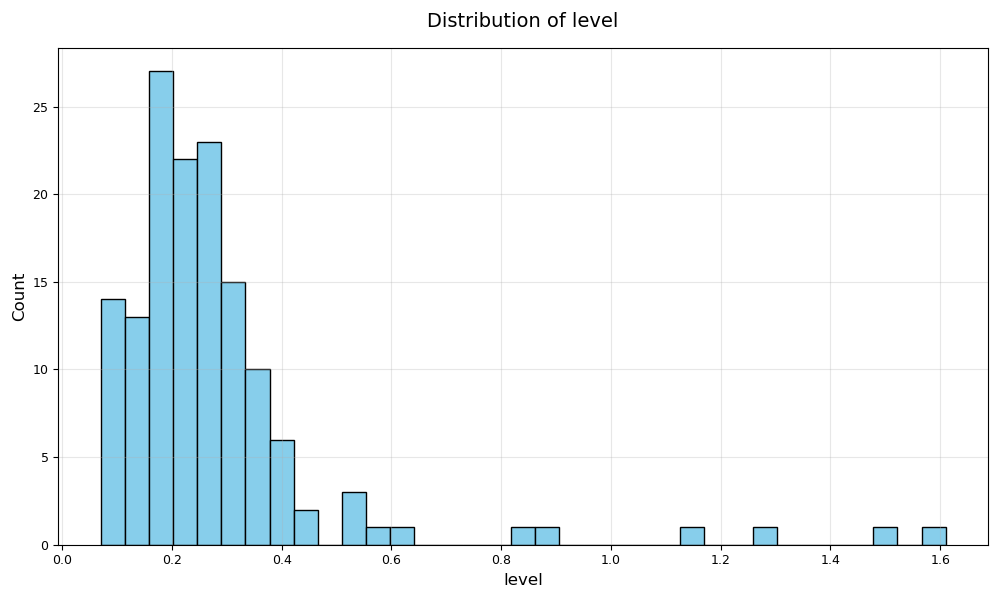

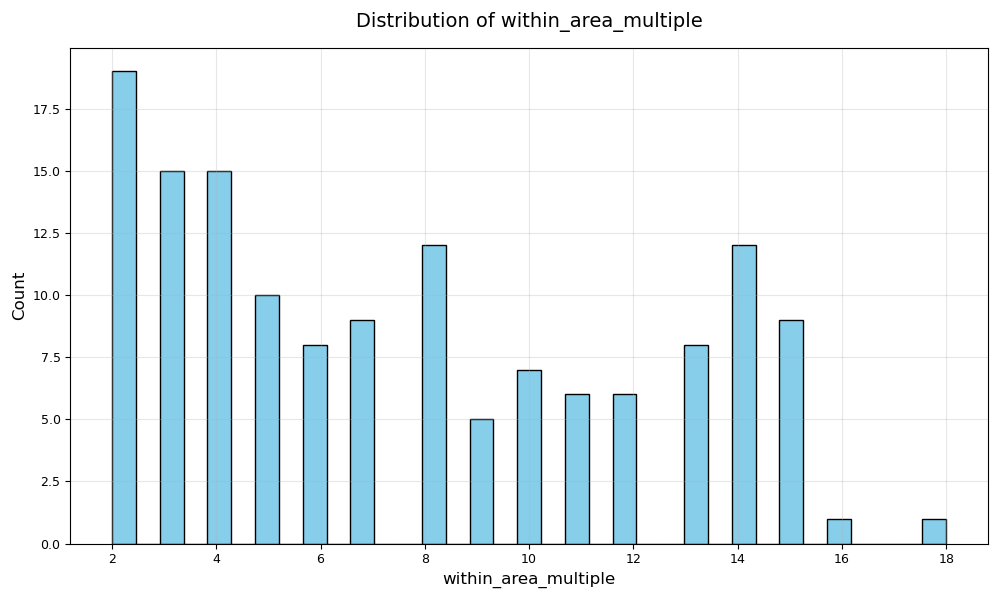

In [114]:
plot_level_histogram(result_df, column='level', bins=35)
plot_level_histogram(result_df, column='within_area_multiple', bins=35)

In [133]:
result_df[result_df['level'] > 0.3].sort_values('level', ascending=False)

,within_area_multiple,level,within_percent,dataset_dois,source_file,name
130,2,1.61,100.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Thw_142.csv,Thw_142
128,15,1.50,100.0,doi:10.5067/ATLAS/ATL15.004,Slessor_5.csv,Slessor_5
5,7,1.26,95.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Site_BC.csv,Site_BC
137,3,1.17,95.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Thw_70.csv,Thw_70
113,4,0.87,100.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Site_A.csv,Site_A
134,13,0.86,95.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Thw_124.csv,Thw_124
119,7,0.64,95.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Lambert_1.csv,Lambert_1
117,3,0.57,100.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",TL96.csv,TL96
126,4,0.54,96.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Slessor_23.csv,Slessor_23
122,5,0.54,95.0,"doi:10.5194/tc-11-451-2017, doi:10.5067/ATLAS/...",Thw_170.csv,Thw_170


# TODO: Export a final inventory